## FCFFST

In [ ]:
def _pct(x):
    """Accept 0.36 or 36 or '36%'; return decimal (0.36)."""
    if isinstance(x, str):
        x = x.strip().replace('%','')
    v = float(x)
    return v/100.0 if v > 1 else v

def fcff_stable_growth(
    ebit,                      # current EBIT
    tax_rate,                  # % or decimal
    capex,                     # current capex
    depreciation,              # current depreciation
    change_in_wc,              # if negative, treat as 0 (as in sheet note)
    use_capex_dep_ratio=False, # Yes/No in sheet
    capex_dep_ratio=None,      # e.g., 1.25 for 125%
    debt_ratio=0.0,            # D/V
    cost_of_equity=None,       # if None, compute via CAPM
    beta=None, risk_free=None, risk_premium=None,
    cost_of_debt_pre_tax=0.0,  # pre-tax
    expected_growth=0.03       # g
):
    # normalize %
    tax_rate              = _pct(tax_rate)
    debt_ratio            = _pct(debt_ratio)
    cost_of_debt_pre_tax  = _pct(cost_of_debt_pre_tax)
    expected_growth       = _pct(expected_growth)
    if cost_of_equity is not None: cost_of_equity = _pct(cost_of_equity)
    if risk_free is not None:      risk_free      = _pct(risk_free)
    if risk_premium is not None:   risk_premium   = _pct(risk_premium)
    if capex_dep_ratio is not None: capex_dep_ratio = _pct(capex_dep_ratio) # Normalize capex_dep_ratio here

    # Capex adjustment (if “change capex/dep ratio? = Yes”)
    capex_adj       = depreciation*capex_dep_ratio if use_capex_dep_ratio and capex_dep_ratio is not None else capex
    capex_minus_dep = capex_adj - depreciation

    # EBIT(1−T)
    ebit_after_tax      = ebit * (1 - tax_rate)

    # ΔWC (negative -> 0 per sheet)
    change_in_wc_used   = change_in_wc if change_in_wc > 0 else 0.0

    # FCFF₀
    fcff0               = ebit_after_tax - capex_minus_dep - change_in_wc_used

    # Cost of Equity: direct or CAPM
    if cost_of_equity is None:
        if None in (beta, risk_free, risk_premium):
            raise ValueError("Provide cost_of_equity OR CAPM inputs (beta, risk_free, risk_premium).")
        cost_of_equity = risk_free + beta*risk_premium

    # After-tax cost of debt
    cost_of_debt_after_tax = cost_of_debt_pre_tax * (1 - tax_rate)

    # WACC
    equity_ratio = 1 - debt_ratio
    wacc = equity_ratio*cost_of_equity + debt_ratio*cost_of_debt_after_tax
    if wacc <= expected_growth:
        raise ValueError("WACC must be > expected growth for the Gordon formula.")

    # Firm value (stable growth, FCFF₁/(WACC−g))
    firm_value = fcff0*(1 + expected_growth) / (wacc - expected_growth)

    return {
        "EBIT_after_tax": ebit_after_tax,
        "Capex_adjusted": capex_adj,
        "Capex_minus_Dep": capex_minus_dep,
        "Change_in_WC_used": change_in_wc_used,
        "FCFF0": fcff0,
        "Cost_of_Equity": cost_of_equity,
        "Cost_of_Debt_after_tax": cost_of_debt_after_tax,
        "WACC": wacc,
        "g": expected_growth,
        "Firm_Value": firm_value
    }

def print_fcff_report(res, decimals=2):
    cur = lambda x: f"${x:,.{decimals}f}"
    pct = lambda x: f"{x*100:.2f}%"
    print("This is the output from the Model")
    print(f"EBIT (1- tax rate) =\t\t\t{cur(res['EBIT_after_tax'])}")
    print(f" - (Capital Spending - Depreciation)\t{cur(res['Capex_minus_Dep'])}")
    print(f" - Change in Working Capital\t\t{cur(res['Change_in_WC_used'])}")
    print(f"Free Cashflow to Firm =\t\t\t{cur(res['FCFF0'])}\n")
    print(f"Cost of Equity =\t{pct(res['Cost_of_Equity'])}")
    print(f"Cost of Debt =\t\t{pct(res['Cost_of_Debt_after_tax'])}")
    print(f"Cost of Capital =\t{pct(res['WACC'])}")
    print(f"Expected Growth rate =\t{pct(res['g'])}\n")
    print(f"Value of Firm\t\t\t{cur(res['Firm_Value'])}")

def print_sensitivity(res, growth_list=(0.07,0.06,0.05,0.04,0.03,0.02,0.01)):
    print("\nGrowth rate\tValue")
    fcff0, wacc = res["FCFF0"], res["WACC"]
    for g in growth_list:
        val = fcff0*(1+g)/(wacc-g) if wacc > g else float('nan')
        print(f"{g*100:.2f}%\t\t${val:,.2f}")

In [ ]:
res = fcff_stable_growth(
    ebit=1535.00,
    tax_rate="36%",
    capex=550.00,
    depreciation=400.00,
    change_in_wc=160.00,
    use_capex_dep_ratio=True,
    capex_dep_ratio="125%",      # sheet uses 125% of Depreciation
    debt_ratio="29.97%",
    cost_of_equity=None,         # use CAPM instead (as in sheet: “No”)
    beta=1.1, risk_free="7%", risk_premium="5.50%",
    cost_of_debt_pre_tax="8.50%",
    expected_growth="5%"
)

print_fcff_report(res)
print_sensitivity(res)


This is the output from the Model
EBIT (1- tax rate) =			$982.40
 - (Capital Spending - Depreciation)	$100.00
 - Change in Working Capital		$160.00
Free Cashflow to Firm =			$722.40

Cost of Equity =	13.05%
Cost of Debt =		5.44%
Cost of Capital =	10.77%
Expected Growth rate =	5.00%

Value of Firm			$13,147.56

Growth rate	Value
7.00%		$20,507.03
6.00%		$16,055.75
5.00%		$13,147.56
4.00%		$11,098.61
3.00%		$9,577.10
2.00%		$8,402.60
1.00%		$7,468.55


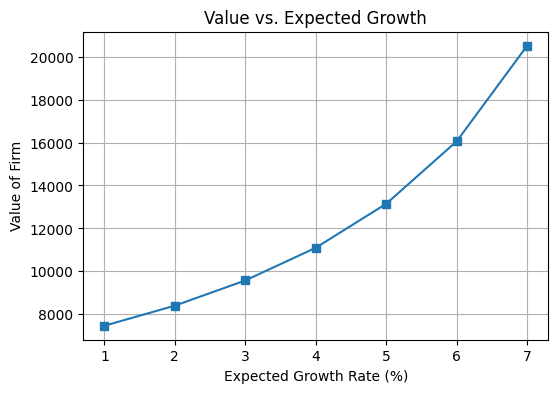

In [ ]:
# --- Plot: Value vs Expected Growth (FCFF Stable-Growth) ---
import numpy as np
import matplotlib.pyplot as plt

# Use existing results if present; else fall back to sheet example.
try:
    fcff0 = float(res["FCFF0"])
    wacc  = float(res["WACC"])
except Exception:
    fcff0 = 722.40   # from your sheet
    wacc  = 0.1077   # 10.77% from your sheet

# Growth points (same as the table): 7% → 1%
growths = np.array([0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01])
values  = fcff0 * (1.0 + growths) / (wacc - growths)

plt.figure(figsize=(6,4))
plt.plot(growths * 100.0, values, marker="s")
plt.title("Value vs. Expected Growth")
plt.xlabel("Expected Growth Rate (%)")
plt.ylabel("Value of Firm")
plt.grid(True)

# (Optional) save the chart
# plt.savefig("value_vs_expected_growth.png", dpi=160, bbox_inches="tight")
plt.show()


## FCFF2ST

In [ ]:
def _pct(x):
    """Accept 0.2849 or 28.49 or '28.49%'; return decimal (0.2849)."""
    if isinstance(x, str):
        x = x.strip().replace('%','')
    v = float(x)
    return v/100.0 if v > 1 else v

def _cur(x, d=2):  # pretty print currency
    return f"${x:,.{d}f}"

def _pp(x, d=2):  # pretty print percent from decimal
    return f"{x*100:.{d}f}%"


In [ ]:
from dataclasses import dataclass
from typing import Optional, Dict, Any, List

@dataclass
class TwoStageInputs:
    # Base financials
    ebit: float
    interest_expense: float
    tax_rate: float                # % or decimal
    capex: float
    depreciation: float
    revenues: float
    change_in_wc_last_year: float  # for display only; model recomputes ΔWC going forward
    working_capital_pct_of_revenue: Optional[float] = None  # if None and keep_current_wc_pct=False, you must pass ΔWC directly

    # Capital structure & component costs
    is_public: bool = True
    share_price: Optional[float] = None
    shares_out: Optional[float] = None
    market_value_debt: Optional[float] = None
    use_book_debt_ratio: bool = False
    book_debt: Optional[float] = None
    book_equity: Optional[float] = None
    override_debt_ratio: Optional[float] = None # decimal (e.g., 0.30)

    enter_cost_equity_direct: bool = False
    cost_of_equity: Optional[float] = None      # % or decimal; used only if enter_cost_equity_direct=True
    beta: Optional[float] = None
    risk_free: Optional[float] = None           # % or decimal
    risk_premium: Optional[float] = None        # % or decimal
    cost_of_debt_pre_tax: float = 0.0           # % or decimal

    # High-growth phase
    years_high: int = 5
    use_hist_growth: bool = False
    ebit_5y_ago: Optional[float] = None
    have_outside_growth_estimate: bool = False
    outside_growth: Optional[float] = None      # % or decimal
    use_fundamental_growth: bool = True
    roc_high: Optional[float] = None            # % or decimal
    reinvest_rate_high: Optional[float] = None  # % or decimal
    weights_growth_sources: Dict[str, float] = None  # {"hist":0.0,"outside":0.0,"fundamental":1.0}

    grow_ops_with_earnings: bool = True         # CapEx, Dep grow with earnings in high period
    g_rev_high: Optional[float] = None          # revenue growth in high period (if None -> use g_high)

    # Stable phase
    g_stable: float = 0.03                      # % or decimal
    change_beta_in_stable: bool = False
    beta_stable: Optional[float] = None
    change_cost_debt_in_stable: bool = False
    cost_debt_stable_pre_tax: Optional[float] = None
    change_debt_ratio_in_stable: bool = False
    debt_ratio_stable: Optional[float] = None

    keep_current_wc_pct: bool = True            # keep WC% of revenue fixed
    capex_offset_depr_in_stable: bool = False   # if True -> CapEx ≈ Dep in stable period
    reinvest_from_fundamentals_stable: bool = True
    roc_stable: Optional[float] = 0.12          # % or decimal (only if reinvest_from_fundamentals_stable=True)
    capex_as_pct_of_dep_stable: Optional[float] = 1.20  # used only if reinvest_from_fundamentals_stable=False

    # Balance sheet & option adjustments for equity value
    cash_and_marketable: float = 0.0
    value_equity_options: float = 0.0


def two_stage_fcff(inputs: TwoStageInputs) -> Dict[str, Any]:
    # --- normalize percents ---
    τ  = _pct(inputs.tax_rate)
    gS = _pct(inputs.g_stable)
    rf = _pct(inputs.risk_free) if inputs.risk_free is not None else None
    rp = _pct(inputs.risk_premium) if inputs.risk_premium is not None else None
    ke_direct = _pct(inputs.cost_of_equity) if (inputs.enter_cost_equity_direct and inputs.cost_of_equity is not None) else None
    kd_pre = _pct(inputs.cost_of_debt_pre_tax)
    roc_high = _pct(inputs.roc_high) if inputs.roc_high is not None else None
    rrate_high = _pct(inputs.reinvest_rate_high) if inputs.reinvest_rate_high is not None else None
    roc_stable = _pct(inputs.roc_stable) if inputs.roc_stable is not None else None
    kd_stable_pre = _pct(inputs.cost_debt_stable_pre_tax) if inputs.cost_debt_stable_pre_tax is not None else kd_pre
    wc_pct = _pct(inputs.working_capital_pct_of_revenue) if inputs.working_capital_pct_of_revenue is not None else None
    g_rev_high = _pct(inputs.g_rev_high) if inputs.g_rev_high is not None else None

    # --- weights (capital structure) ---
    if inputs.override_debt_ratio is not None:
        D_over_V = _pct(inputs.override_debt_ratio)
    elif inputs.is_public and inputs.share_price is not None and inputs.shares_out is not None and inputs.market_value_debt is not None:
        MV_E = inputs.share_price * inputs.shares_out
        MV_D = inputs.market_value_debt
        V = MV_E + MV_D
        D_over_V = MV_D / V if V > 0 else 0.0
    elif inputs.use_book_debt_ratio and inputs.book_debt is not None and inputs.book_equity is not None:
        Vb = inputs.book_debt + inputs.book_equity
        D_over_V = inputs.book_debt / Vb if Vb > 0 else 0.0
    else:
        raise ValueError("Provide capital-structure info: (public MV equity+debt) OR book ratio OR override_debt_ratio.")
    E_over_V = 1.0 - D_over_V

    # --- component costs ---
    if inputs.enter_cost_equity_direct:
        if ke_direct is None:
            raise ValueError("Enter cost_of_equity when enter_cost_equity_direct=True.")
        ke = ke_direct
    else:
        if None in (inputs.beta, rf, rp):
            raise ValueError("Provide beta, risk_free, risk_premium for CAPM KE.")
        ke = rf + inputs.beta * rp

    kd_at = kd_pre * (1 - τ)

    # --- high-growth g (weighted across sources) ---
    g_hist = None
    if inputs.use_hist_growth and inputs.ebit_5y_ago:
        g_hist = (inputs.ebit / inputs.ebit_5y_ago) ** (1/5) - 1

    g_out = _pct(inputs.outside_growth) if (inputs.have_outside_growth_estimate and inputs.outside_growth is not None) else None

    g_fund = None
    if inputs.use_fundamental_growth and (roc_high is not None) and (rrate_high is not None):
        g_fund = roc_high * rrate_high

    # weights
    w = inputs.weights_growth_sources or {"hist":0.0,"outside":0.0,"fundamental":1.0}
    # safe normalize
    sw = sum(w.values()) or 1.0
    for k in w: w[k] = w[k]/sw

    parts = []
    if g_hist is not None: parts.append(w["hist"]*g_hist)
    if g_out  is not None: parts.append(w["outside"]*g_out)
    if g_fund is not None: parts.append(w["fundamental"]*g_fund)
    if not parts:
        raise ValueError("No growth source available. Provide at least one of: historical/outside/fundamental.")
    gH = sum(parts)

    # revenue growth for ΔWC
    if g_rev_high is None:
        g_rev_high = gH

    # --- WACC (high period) ---
    wacc_high = E_over_V*ke + D_over_V*kd_at

    # --- base NOPAT, CapEx-Dep, Revenue ---
    nopat0 = inputs.ebit * (1 - τ)                # EBIT(1-t)
    cnd0   = inputs.capex - inputs.depreciation   # (CapEx - Dep) now
    rev0   = inputs.revenues

    # --- simulate high-growth years ---
    years = []
    pv_sum_high = 0.0
    rev = rev0
    nopat = nopat0
    cnd   = cnd0

    for y in range(1, inputs.years_high+1):
        # grow drivers
        nopat = nopat * (1 + gH)
        if inputs.grow_ops_with_earnings:
            cnd = cnd * (1 + gH)
        # revenue path for ΔWC
        prev_rev = rev
        rev = rev * (1 + g_rev_high)
        d_rev = rev - prev_rev

        d_wc = (wc_pct * d_rev) if (inputs.keep_current_wc_pct and wc_pct is not None) else max(inputs.change_in_wc_last_year, 0.0)

        fcff = nopat - cnd - d_wc
        disc = (1.0 / ((1 + wacc_high)**y))
        pv   = fcff * disc
        pv_sum_high += pv

        years.append({
            "year": y,
            "NOPAT": nopat,
            "CapEx_minus_Dep": cnd,
            "ΔWC": d_wc,
            "FCFF": fcff,
            "PV": pv
        })

    # --- stable phase inputs ---
    beta_stable = (inputs.beta_stable if inputs.change_beta_in_stable and inputs.beta_stable is not None else inputs.beta)
    kd_stable_pre = (kd_stable_pre if inputs.change_cost_debt_in_stable and inputs.cost_debt_stable_pre_tax is not None else kd_pre)
    kd_stable_at = kd_stable_pre * (1 - τ)

    if inputs.change_debt_ratio_in_stable and inputs.debt_ratio_stable is not None:
        D_over_V_stable = _pct(inputs.debt_ratio_stable)
        E_over_V_stable = 1 - D_over_V_stable
    else:
        D_over_V_stable = D_over_V
        E_over_V_stable = E_over_V

    # KE stable (CAPM with possibly changed beta; same rf,rp)
    ke_stable = (_pct(inputs.cost_of_equity) if inputs.enter_cost_equity_direct and inputs.cost_of_equity is not None
                 else rf + beta_stable * rp)

    wacc_stable = E_over_V_stable*ke_stable + D_over_V_stable*kd_stable_at

    # terminal year (t = years_high + 1)
    nopat_term = years[-1]["NOPAT"] * (1 + gS)

    # revenue for terminal ΔWC
    rev_term = rev * (1 + gS)
    d_wc_term = (wc_pct * (rev_term - rev)) if (inputs.keep_current_wc_pct and wc_pct is not None) else 0.0

    if inputs.reinvest_from_fundamentals_stable and roc_stable is not None and roc_stable > 0:
        reinvest_rate_stable = gS / roc_stable
        reinvest_amt = nopat_term * reinvest_rate_stable
        cnd_term = max(reinvest_amt - d_wc_term, 0.0)
    else:
        # fallback: CapEx as % of Dep; here we just keep CND proportion using that %; not used in your example
        cnd_term = years[-1]["CapEx_minus_Dep"] * (inputs.capex_as_pct_of_dep_stable or 1.0)

    fcff_term = nopat_term - cnd_term - d_wc_term
    if wacc_stable <= gS:
        raise ValueError("Stable WACC must exceed stable growth g for the Gordon formula.")
    tv_at_tN = fcff_term / (wacc_stable - gS)           # value at end of year N (undiscounted)
    pv_terminal = tv_at_tN / ((1 + wacc_high) ** inputs.years_high)

    firm_value = pv_sum_high + pv_terminal

    # equity bridge (Damodaran style used in your sheet)
    equity_pre_options = firm_value + inputs.cash_and_marketable - (inputs.market_value_debt or 0.0)
    equity_after_options = equity_pre_options - inputs.value_equity_options

    result = {
        # component costs & weights
        "Cost_of_Equity": ke,
        "AfterTax_Cost_of_Debt": kd_at,
        "WACC_high": wacc_high,
        "WACC_stable": wacc_stable,
        "E_over_V": E_over_V, "D_over_V": D_over_V,

        # current FCFF decomposition (for display)
        "NOPAT0": nopat0, "CND0": cnd0,
        "ΔWC0_display": max(inputs.change_in_wc_last_year, 0.0),
        "FCFF0_display": nopat0 - cnd0 - max(inputs.change_in_wc_last_year, 0.0),

        # growths used
        "g_high": gH, "g_rev_high": g_rev_high, "g_stable": gS,
        "roc_high": roc_high, "reinvest_rate_high": rrate_high,
        "roc_stable": roc_stable,

        # path & terminal
        "years": years,
        "PV_high_sum": pv_sum_high,
        "Terminal_FCFF_(tN+1)": fcff_term,
        "Terminal_Value_at_tN": tv_at_tN,
        "PV_terminal": pv_terminal,

        # firm & equity
        "Firm_Value": firm_value,
        "Equity_Value_pre_options": equity_pre_options,
        "Equity_Value_after_options": equity_after_options
    }
    return result


In [ ]:
import pandas as pd

def print_two_stage_report(res: Dict[str, Any], cash=0.0, mv_debt=0.0, options=0.0, shares=None):
    print("Output from the program")
    print(f"Cost of Equity =\t\t{_pp(res['Cost_of_Equity'])}")
    print(f"Equity/(Debt+Equity ) =\t{_pp(res['E_over_V'])}")
    print(f"After-tax Cost of debt =\t{_pp(res['AfterTax_Cost_of_Debt'])}")
    print(f"Debt/(Debt +Equity) =\t{_pp(res['D_over_V'])}")
    print(f"Cost of Capital =\t\t{_pp(res['WACC_high'])}\n")

    print(f"Current EBIT * (1 - tax rate) =\t{_cur(res['NOPAT0'])}")
    print(f" - (Capital Spending - Depreciation) =\t{_cur(res['CND0'])}")
    print(f" - Change in Working Capital =\t\t{_cur(res['ΔWC0_display'])}")
    print(f"Current FCFF =\t\t\t\t{_cur(res['FCFF0_display'])}\n")

    yr_df = pd.DataFrame(res["years"])
    if not yr_df.empty:
        display(yr_df.style.format({"NOPAT":"${:,.2f}","CapEx_minus_Dep":"${:,.2f}",
                                    "ΔWC":"${:,.2f}","FCFF":"${:,.2f}","PV":"${:,.2f}"}))

    print(f"Growth Rate in Stable Phase =\t{_pp(res['g_stable'])}")
    print(f"FCFF in Stable Phase =\t\t{_cur(res['Terminal_FCFF_(tN+1)'])}")
    print(f"Cost of Capital in Stable Phase =\t{_pp(res['WACC_stable'])}")
    print(f"Value at the end of growth phase =\t{_cur(res['Terminal_Value_at_tN'])}\n")

    print(f"Present Value of FCFF in high growth phase =\t{_cur(res['PV_high_sum'])}")
    print(f"Present Value of Terminal Value of Firm =\t{_cur(res['PV_terminal'])}")
    print(f"Value of the firm =\t\t\t\t{_cur(res['Firm_Value'])}")

    eq_pre = res["Equity_Value_pre_options"]
    print(f"Cash and Marketable Securities =\t\t{_cur(cash)}")
    print(f"Market Value of outstanding debt =\t\t{_cur(mv_debt)}")
    print(f"Market Value of Equity =\t\t\t{_cur(eq_pre)}")
    print(f"Value of Equity options issued by the company =\t{_cur(options)}")
    eq_after = eq_pre - options
    print(f"Market Value of Equity (post options) =\t{_cur(eq_after)}")
    if shares:
        print(f"Market Value of Equity/share =\t\t{_cur(eq_after / shares)}")


In [ ]:
inp = TwoStageInputs(
    # Inputs to the model
    ebit=5186.00,
    interest_expense=118.00,
    tax_rate="28.49%",
    capex=2152.00,
    depreciation=1228.00,
    revenues=16701.00,
    change_in_wc_last_year=499.00,

    # Capital structure & costs
    is_public=True,
    share_price=125.50,
    shares_out=993.57,
    market_value_debt=1822.00,

    enter_cost_equity_direct=False,
    beta=0.8, risk_free="5.30%", risk_premium="5.50%",
    cost_of_debt_pre_tax="5.50%",

    # High growth
    years_high=5,
    use_hist_growth=False,
    have_outside_growth_estimate=True,
    outside_growth="12.50%",
    use_fundamental_growth=True,
    roc_high="27.53%",
    reinvest_rate_high="38.37%",
    weights_growth_sources={"hist":0.0,"outside":0.0,"fundamental":1.0},

    grow_ops_with_earnings=True,
    g_rev_high=None,   # default: use g_high

    # Stable phase
    g_stable="6.00%",
    change_beta_in_stable=False,
    change_cost_debt_in_stable=False,
    change_debt_ratio_in_stable=False,

    keep_current_wc_pct=True,
    working_capital_pct_of_revenue="22.48%",
    capex_offset_depr_in_stable=False,
    reinvest_from_fundamentals_stable=True,
    roc_stable="12%",

    # Balance sheet & option adjustments
    cash_and_marketable=500.00,
    value_equity_options=1500.00
)

res = two_stage_fcff(inp)

# Display (matches sheet sections & numbers)
print_two_stage_report(
    res,
    cash=inp.cash_and_marketable,
    mv_debt=inp.market_value_debt,
    options=inp.value_equity_options,
    shares=inp.shares_out
)


Output from the program
Cost of Equity =		9.70%
Equity/(Debt+Equity ) =	98.56%
After-tax Cost of debt =	3.93%
Debt/(Debt +Equity) =	1.44%
Cost of Capital =		9.62%

Current EBIT * (1 - tax rate) =	$3,708.51
 - (Capital Spending - Depreciation) =	$924.00
 - Change in Working Capital =		$499.00
Current FCFF =				$2,285.51



,year,NOPAT,CapEx_minus_Dep,ΔWC,FCFF,PV
0,1,"$4,100.25","$1,021.60",$396.59,"$2,682.06","$2,446.75"
1,2,"$4,533.37","$1,129.52",$438.48,"$2,965.37","$2,467.88"
2,3,"$5,012.24","$1,248.83",$484.80,"$3,278.61","$2,489.18"
3,4,"$5,541.70","$1,380.75",$536.01,"$3,624.94","$2,510.67"
4,5,"$6,127.08","$1,526.60",$592.63,"$4,007.85","$2,532.35"


Growth Rate in Stable Phase =	6.00%
FCFF in Stable Phase =		$3,247.35
Cost of Capital in Stable Phase =	9.62%
Value at the end of growth phase =	$89,781.56

Present Value of FCFF in high growth phase =	$12,446.83
Present Value of Terminal Value of Firm =	$56,728.15
Value of the firm =				$69,174.98
Cash and Marketable Securities =		$500.00
Market Value of outstanding debt =		$1,822.00
Market Value of Equity =			$67,852.98
Value of Equity options issued by the company =	$1,500.00
Market Value of Equity (post options) =	$66,352.98
Market Value of Equity/share =		$66.78


## FCFF3ST

In [ ]:
def _pct(x):
    """Accept 0.36, 36, or '36%'; return decimal (0.36)."""
    if isinstance(x, str):
        x = x.strip().replace('%','').replace(',','')
    v = float(x)
    return v/100.0 if v > 1 else v

def _cur(x, d=2):  # format currency
    return f"${x:,.{d}f}"

def _pp(x, d=2):  # format percent from decimal
    return f"{x*100:.{d}f}%"


In [ ]:
from dataclasses import dataclass
from typing import List, Optional, Dict, Any

@dataclass
class InputsValuation:
    # Base level (t=0)
    rev0: float
    ebit0: float
    capex0: float
    dep0: float
    wc_change_last_year: float  # only for display; ΔWC is computed going forward
    debt_outstanding: float     # market value (subtracted to get equity)
    cash: float                 # added in equity bridge
    options_val: float          # subtracted after equity
    shares: float               # for per-share

    # High-growth block (years 1..5 in the sheet)
    years_high: int            # 5
    g_rev_high: float          # e.g., 30%
    g_dep_high: float          # often same as g_rev_high
    pretax_margin0: float      # e.g., 6.89%
    pretax_margin_y5: float    # e.g., 30%
    wc_pct_of_rev: float       # e.g., 7.5%
    tax_rate: float            # e.g., 36%

    # CAPM & debt costs for high period
    beta_high: float
    rf: float
    mrp: float
    cost_debt_high_pre: float  # pre-tax

    # Stable/transition block (years 6..10) & terminal
    g_rev_stable: float             # e.g., 6%
    pretax_margin_stable: float     # e.g., 25%
    beta_stable: float              # e.g., 1.10
    cost_debt_stable_pre: float     # e.g., 7.5% pre-tax
    debt_ratio_stable: float        # D/V target in stable (e.g., 5%)

    reinvest_from_fundamentals: bool = True  # terminal FCFF = NOPAT*(1 - g/ROC)
    roc_stable: float = 0.12                 # stable ROC used for terminal

def value_10y_fcff(inputs: InputsValuation,
                   capex_series: Optional[List[float]] = None
                   ) -> Dict[str, Any]:
    """Replicates the 10-year FCFF sheet with WACC glide + terminal."""
    T = 10
    YH = inputs.years_high
    steps = T - YH

    # ---- Growth schedules (1..10) ----
    g_rev = [inputs.g_rev_high]*YH + [
        (1 - i/steps)*inputs.g_rev_high + (i/steps)*inputs.g_rev_stable
        for i in range(1, steps+1)
    ]
    g_dep = [inputs.g_dep_high]*YH + g_rev[YH:]   # same as revenues in the example

    # ---- Pretax operating margin glide ----
    margins = [
        (1 - y/YH)*inputs.pretax_margin0 + (y/YH)*inputs.pretax_margin_y5
        for y in range(1, YH+1)
    ] + [
        (1 - i/steps)*inputs.pretax_margin_y5 + (i/steps)*inputs.pretax_margin_stable
        for i in range(1, steps+1)
    ]

    # ---- Capital structure & component costs (glides) ----
    betas = [inputs.beta_high]*YH + [
        (1 - i/steps)*inputs.beta_high + (i/steps)*inputs.beta_stable
        for i in range(1, steps+1)
    ]
    # D/V: 0% over high period, linearly to target over the last 5 years
    D_over_V = [0.0]*YH + [inputs.debt_ratio_stable*(i/steps) for i in range(1, steps+1)]
    E_over_V = [1 - d for d in D_over_V]

    kd_pre = [inputs.cost_debt_high_pre]*YH + [
        (1 - i/steps)*inputs.cost_debt_high_pre + (i/steps)*inputs.cost_debt_stable_pre
        for i in range(1, steps+1)
    ]
    kd_at = [k*(1 - inputs.tax_rate) for k in kd_pre]    # after-tax cost of debt
    ke    = [inputs.rf + b*inputs.mrp for b in betas]    # CAPM
    wacc  = [E_over_V[i]*ke[i] + D_over_V[i]*kd_at[i] for i in range(T)]

    # ---- Project the statements ----
    rev = [inputs.rev0]
    dep = [inputs.dep0]
    cap = [inputs.capex0]

    for t in range(T):
        rev.append(rev[-1]*(1 + g_rev[t]))
        dep.append(dep[-1]*(1 + g_dep[t]))
        if capex_series is None or t >= len(capex_series):
            cap.append(cap[-1]*(1 + g_dep[t]))        # default: grow capex with depreciation
        else:
            cap.append(capex_series[t])

    rev = rev[1:]; dep = dep[1:]; cap = cap[1:]       # 10 values

    EBIT  = [margins[t] * rev[t] for t in range(T)]
    NOPAT = [e * (1 - inputs.tax_rate) for e in EBIT]

    # ΔWC = WC% * ΔRevenue
    dRev = [rev[0] - inputs.rev0] + [rev[t] - rev[t-1] for t in range(1, T)]
    dWC  = [inputs.wc_pct_of_rev * dr for dr in dRev]

    # FCFF = NOPAT + Dep - Capex - ΔWC
    FCFF = [NOPAT[t] + dep[t] - cap[t] - dWC[t] for t in range(T)]

    # ---- Terminal value (perpetuity, reinvestment from fundamentals) ----
    rev_T1   = rev[-1]*(1 + inputs.g_rev_stable)
    EBIT_T1  = inputs.pretax_margin_stable * rev_T1
    NOPAT_T1 = EBIT_T1 * (1 - inputs.tax_rate)

    reinvest_rate = (inputs.g_rev_stable/inputs.roc_stable) if inputs.reinvest_from_fundamentals else 0.0
    FCFF_T1 = NOPAT_T1 * (1 - reinvest_rate)
    wacc_T  = wacc[-1]
    if wacc_T <= inputs.g_rev_stable:
        raise ValueError("Stable WACC must be greater than stable growth.")

    TV = FCFF_T1 / (wacc_T - inputs.g_rev_stable)  # terminal at t=10 (undiscounted)

    # ---- Discounting with year-specific WACC (cumulative) ----
    cum = []
    prod = 1.0
    for r in wacc:
        prod *= (1 + r)
        cum.append(prod)

    PV = [FCFF[t] / cum[t] for t in range(T)]
    PV[-1] += TV / cum[-1]   # terminal added to year 10 PV

    firm_value = sum(PV)
    equity_value = firm_value + inputs.cash - inputs.debt_outstanding
    equity_after_options = equity_value - inputs.options_val
    price_per_share = equity_after_options / inputs.shares

    return {
        # series
        "revenues": rev, "depreciation": dep, "capex": cap,
        "EBIT": EBIT, "NOPAT": NOPAT, "dWC": dWC, "FCFF": FCFF,
        # costs & weights
        "ke": ke, "kd_at": kd_at, "wacc": wacc, "D_over_V": D_over_V, "E_over_V": E_over_V,
        # discounting and value
        "cum_factors": cum, "PV": PV, "TV": TV,
        "firm_value": firm_value, "equity_value": equity_value,
        "equity_after_options": equity_after_options, "price_per_share": price_per_share
    }


In [ ]:
# ---- Fill inputs from the screenshot ----
iv = InputsValuation(
    # Current inputs
    rev0=12406.0,
    ebit0=855.0,
    capex0=233.0,
    dep0=298.0,
    wc_change_last_year=115.0,
    debt_outstanding=0.0,         # “$ –” in the sheet
    cash=850.0,
    options_val=1500.0,
    shares=1500.0,

    # High growth (years 1..5)
    years_high=5,
    g_rev_high=_pct("30%"),
    g_dep_high=_pct("30%"),
    pretax_margin0=_pct("6.89%"),
    pretax_margin_y5=_pct("30%"),
    wc_pct_of_rev=_pct("7.50%"),
    tax_rate=_pct("36%"),

    # Costs (high period)
    beta_high=1.25,
    rf=_pct("6.50%"),
    mrp=_pct("5.50%"),
    cost_debt_high_pre=_pct("8.50%"),

    # Stable/transition and terminal
    g_rev_stable=_pct("6%"),
    pretax_margin_stable=_pct("25%"),
    beta_stable=1.10,
    cost_debt_stable_pre=_pct("7.50%"),
    debt_ratio_stable=_pct("5%"),
    reinvest_from_fundamentals=True,
    roc_stable=_pct("12.00%")
)

# IMPORTANT:
# The sheet’s “CapEx” series changes its rule after year 5.
# To replicate the screenshot exactly, pass the observed values (years 1..10):
capex_override = [303, 394, 512, 665, 865, 2573, 4281, 5990, 7698, 9406]

res = value_10y_fcff(iv, capex_series=capex_override)

# ---- Print a compact report (same sections as the sheet) ----
print("COSTS OF EQUITY AND CAPITAL (by year 1..10)")
for t in range(10):
    print(f"y{t+1:>2}: KE={_pp(res['ke'][t])}  D%={_pp(res['D_over_V'][t])}  Kd(at)={_pp(res['kd_at'][t])}  WACC={_pp(res['wacc'][t])}")

print("\nCURRENT FCFF BREAKDOWN (year 0 → year 1)")
print(f"EBIT(1-t) = {_cur(res['NOPAT'][0])}")
print(f"+ Dep     = {_cur(res['depreciation'][0])}")
print(f"- CapEx   = {_cur(res['capex'][0])}")
print(f"- ΔWC     = {_cur(res['dWC'][0])}")
print(f"= FCFF    = {_cur(res['FCFF'][0])}")

print("\nDISCOUNTED CASHFLOWS")
for t, pv in enumerate(res["PV"], start=1):
    print(f"PV(y{t}) = {_cur(pv)}" + ("  (includes Terminal)" if t==10 else ""))

print("\nFIRM VALUATION")
print(f"Value of Firm = {_cur(res['firm_value'])}")
print(f"+ Cash & Mkt Sec = {_cur(iv.cash)}")
print(f"- Value of Debt  = {_cur(iv.debt_outstanding)}")
print(f"Value of Equity  = {_cur(res['equity_value'])}")
print(f"- Value of Options = {_cur(iv.options_val)}")
print(f"Equity (post options) = {_cur(res['equity_after_options'])}")
print(f"Value per Share = {_cur(res['price_per_share'])}")


COSTS OF EQUITY AND CAPITAL (by year 1..10)
y 1: KE=13.38%  D%=0.00%  Kd(at)=5.44%  WACC=13.38%
y 2: KE=13.38%  D%=0.00%  Kd(at)=5.44%  WACC=13.38%
y 3: KE=13.38%  D%=0.00%  Kd(at)=5.44%  WACC=13.38%
y 4: KE=13.38%  D%=0.00%  Kd(at)=5.44%  WACC=13.38%
y 5: KE=13.38%  D%=0.00%  Kd(at)=5.44%  WACC=13.38%
y 6: KE=13.21%  D%=1.00%  Kd(at)=5.31%  WACC=13.13%
y 7: KE=13.05%  D%=2.00%  Kd(at)=5.18%  WACC=12.89%
y 8: KE=12.88%  D%=3.00%  Kd(at)=5.06%  WACC=12.65%
y 9: KE=12.72%  D%=4.00%  Kd(at)=4.93%  WACC=12.40%
y10: KE=12.55%  D%=5.00%  Kd(at)=4.80%  WACC=12.16%

CURRENT FCFF BREAKDOWN (year 0 → year 1)
EBIT(1-t) = $1,188.24
+ Dep     = $387.40
- CapEx   = $303.00
- ΔWC     = $279.14
= FCFF    = $993.51

DISCOUNTED CASHFLOWS
PV(y1) = $876.30
PV(y2) = $1,487.22
PV(y3) = $2,258.69
PV(y4) = $3,224.63
PV(y5) = $4,424.62
PV(y6) = $4,079.56
PV(y7) = $3,740.04
PV(y8) = $3,338.20
PV(y9) = $2,834.89
PV(y10) = $40,402.47  (includes Terminal)

FIRM VALUATION
Value of Firm = $66,666.63
+ Cash & Mkt Sec

## FCFFEVA

In [ ]:
def _pct(x):
    """Accept 0.36, 36, or '36%'; return decimal like 0.36."""
    if isinstance(x, str):
        x = x.strip().replace('%', '').replace(',', '')
    v = float(x)
    return v/100.0 if v > 1 else v

def _cur(x, d=2):  # currency
    return f"${x:,.{d}f}"

def _pp(x, d=2):  # percent from decimal
    return f"{x*100:.{d}f}%"


In [ ]:
from dataclasses import dataclass
from typing import Optional, Dict, Any, List

@dataclass
class OpexModelInputs:
    # Current/base
    rev0: float
    dep0: float
    capex0: float
    wc_change_last_year: float      # for display only
    debt_outstanding: float         # MV debt (for equity bridge)
    shares: float

    # High growth block (years 1..5)
    years_high: int                 # 5
    g_rev_high: float               # e.g., 25%
    g_dep_high: float               # usually same as g_rev_high
    opex_pct_high: float            # e.g., 70% (Operating expenses / Revenue)
    wc_pct_of_rev: float            # e.g., 7.5%
    tax_rate: float                 # e.g., 36%

    # Costs (CAPM & debt) during the whole horizon with a glide into stable
    beta_high: float
    beta_stable: float
    rf: float
    mrp: float
    kd_pre_high: float              # pre-tax cost of debt in high
    kd_pre_stable: float            # pre-tax cost of debt in stable
    debt_ratio_stable: float        # D/V target reached by year 10

    # Stable block (years 6..10) + terminal
    g_rev_stable: float             # 6%
    opex_pct_stable: float          # 75% (so EBIT margin = 25%)
    capex_vs_dep_stable: float      # e.g., 2.0 => CapEx = 200% of Dep in terminal

def value_fcff_opex(inputs: OpexModelInputs) -> Dict[str, Any]:
    T, YH = 10, inputs.years_high
    steps = T - YH

    # ----- growth schedules -----
    g_rev = [inputs.g_rev_high]*YH + [
        (1 - i/steps)*inputs.g_rev_high + (i/steps)*inputs.g_rev_stable
        for i in range(1, steps+1)
    ]
    g_dep = [inputs.g_dep_high]*YH + g_rev[YH:]  # same pattern as sheet

    # ----- opex% schedule (70% for 1..5; glide to 75% over 6..10) -----
    opex_pct = [inputs.opex_pct_high]*YH + [
        (1 - i/steps)*inputs.opex_pct_high + (i/steps)*inputs.opex_pct_stable
        for i in range(1, steps+1)
    ]

    # ----- capital structure / component cost glides -----
    betas = [inputs.beta_high]*YH + [
        (1 - i/steps)*inputs.beta_high + (i/steps)*inputs.beta_stable
        for i in range(1, steps+1)
    ]
    D_over_V = [0.0]*YH + [inputs.debt_ratio_stable*(i/steps) for i in range(1, steps+1)]
    E_over_V = [1 - d for d in D_over_V]
    kd_pre   = [inputs.kd_pre_high]*YH + [
        (1 - i/steps)*inputs.kd_pre_high + (i/steps)*inputs.kd_pre_stable
        for i in range(1, steps+1)
    ]
    kd_at    = [k*(1 - inputs.tax_rate) for k in kd_pre]
    ke       = [inputs.rf + b*inputs.mrp for b in betas]
    wacc     = [E_over_V[i]*ke[i] + D_over_V[i]*kd_at[i] for i in range(T)]

    # ----- project revenues, dep, capex -----
    rev = [inputs.rev0]
    dep = [inputs.dep0]
    cap = [inputs.capex0]
    for t in range(T):
        rev.append(rev[-1]*(1 + g_rev[t]))
        dep.append(dep[-1]*(1 + g_dep[t]))
        cap.append(cap[-1]*(1 + g_dep[t]))  # CapEx grows with Depreciation, as in the table
    rev, dep, cap = rev[1:], dep[1:], cap[1:]

    # ----- operating line items -----
    opex_dollars = [opex_pct[t]*rev[t] for t in range(T)]
    EBIT  = [rev[t] - opex_dollars[t] for t in range(T)]  # EBIT = Revenue - Operating Expenses
    NOPAT = [EBIT[t]*(1 - inputs.tax_rate) for t in range(T)]

    # ΔWC = WC% * ΔRev
    dRev = [rev[0] - inputs.rev0] + [rev[t] - rev[t-1] for t in range(1, T)]
    dWC  = [inputs.wc_pct_of_rev * dr for dr in dRev]

    FCFF = [NOPAT[t] + dep[t] - cap[t] - dWC[t] for t in range(T)]

    # ----- terminal (t=10 → T+1) with CapEx = (% of Dep) -----
    rev_T1  = rev[-1]*(1 + inputs.g_rev_stable)
    dep_T1  = dep[-1]*(1 + inputs.g_rev_stable)
    cap_T1  = inputs.capex_vs_dep_stable * dep_T1
    opex_T1 = inputs.opex_pct_stable * rev_T1
    EBIT_T1 = rev_T1 - opex_T1
    NOPAT_T1 = EBIT_T1*(1 - inputs.tax_rate)
    dWC_T1   = inputs.wc_pct_of_rev * (rev_T1 - rev[-1])
    FCFF_T1  = NOPAT_T1 + dep_T1 - cap_T1 - dWC_T1

    if wacc[-1] <= inputs.g_rev_stable:
        raise ValueError("Stable WACC must be greater than stable growth for terminal value.")
    TV = FCFF_T1 / (wacc[-1] - inputs.g_rev_stable)

    # ----- discounting with year-specific WACC (cumulative) -----
    cum = []
    prod = 1.0
    for r in wacc:
        prod *= (1 + r)
        cum.append(prod)
    PV = [FCFF[t]/cum[t] for t in range(T)]
    PV[-1] += TV/cum[-1]  # add terminal at year 10

    firm_value = sum(PV)
    equity_value = firm_value - inputs.debt_outstanding
    price_per_share = equity_value / inputs.shares

    return {
        "revenues": rev, "dep": dep, "capex": cap, "opex_pct": opex_pct,
        "EBIT": EBIT, "NOPAT": NOPAT, "dWC": dWC, "FCFF": FCFF,
        "ke": ke, "kd_at": kd_at, "wacc": wacc, "cum": cum,
        "TV": TV, "PV": PV, "firm_value": firm_value,
        "equity_value": equity_value, "pps": price_per_share
    }

In [ ]:
inp = OpexModelInputs(
    # Current
    rev0=12406.0,
    dep0=233.0,
    capex0=298.0,
    wc_change_last_year=115.0,
    debt_outstanding=0.0,
    shares=1500.0,

    # High growth (1..5)
    years_high=5,
    g_rev_high=_pct("25%"),
    g_dep_high=_pct("25%"),
    opex_pct_high=_pct("70%"),     # operating expenses / revenue
    wc_pct_of_rev=_pct("7.5%"),
    tax_rate=_pct("36%"),

    # Costs & glides
    beta_high=1.25, beta_stable=1.10,
    rf=_pct("6.50%"), mrp=_pct("5.50%"),
    kd_pre_high=_pct("8.50%"), kd_pre_stable=_pct("7.50%"),
    debt_ratio_stable=_pct("5%"),

    # Stable & terminal
    g_rev_stable=_pct("6%"),
    opex_pct_stable=_pct("75%"),
    capex_vs_dep_stable=2.0        # 200% of Dep in terminal
)

res = value_fcff_opex(inp)

# --- key outputs (should match your sheet) ---
print("COSTS OF EQUITY AND CAPITAL (years 1..10)")
for t in range(10):
    print(f"y{t+1:>2}: KE={_pp(res['ke'][t])}  D%={_pp(1 - (res['ke'][t]-res['wacc'][t])/(res['kd_at'][t] if res['kd_at'][t]!=0 else 1))}  WACC={_pp(res['wacc'][t])}")

print("\nCURRENT FCFF DECOMPOSITION (base → year 1)")
print(f"EBIT(1-t) = {_cur(res['NOPAT'][0])}")
print(f"+ Dep     = {_cur(res['dep'][0])}")
print(f"- CapEx   = {_cur(res['capex'][0])}")
print(f"- ΔWC     = {_cur(res['dWC'][0])}")
print(f"= FCFF    = {_cur(res['FCFF'][0])}")

print("\nDISCOUNTED CASHFLOWS")
for t, pv in enumerate(res["PV"], start=1):
    print(f"PV(y{t}) = {_cur(pv)}" + ("  (includes Terminal)" if t==10 else ""))

print("\nFIRM VALUATION")
print(f"Value of Firm = {_cur(res['firm_value'])}")          # ≈ $80,367
print(f"Value of Equity (no debt) = {_cur(res['equity_value'])}")
print(f"Value per Share = {_cur(res['pps'])}")               # ≈ $53.58


COSTS OF EQUITY AND CAPITAL (years 1..10)
y 1: KE=13.38%  D%=100.00%  WACC=13.38%
y 2: KE=13.38%  D%=100.00%  WACC=13.38%
y 3: KE=13.38%  D%=100.00%  WACC=13.38%
y 4: KE=13.38%  D%=100.00%  WACC=13.38%
y 5: KE=13.38%  D%=100.00%  WACC=13.38%
y 6: KE=13.21%  D%=98.51%  WACC=13.13%
y 7: KE=13.05%  D%=96.97%  WACC=12.89%
y 8: KE=12.88%  D%=95.36%  WACC=12.65%
y 9: KE=12.72%  D%=93.68%  WACC=12.40%
y10: KE=12.55%  D%=91.93%  WACC=12.16%

CURRENT FCFF DECOMPOSITION (base → year 1)
EBIT(1-t) = $2,977.44
+ Dep     = $291.25
- CapEx   = $372.50
- ΔWC     = $232.61
= FCFF    = $2,663.58

DISCOUNTED CASHFLOWS
PV(y1) = $2,349.35
PV(y2) = $2,590.24
PV(y3) = $2,855.84
PV(y4) = $3,148.66
PV(y5) = $3,471.51
PV(y6) = $3,621.27
PV(y7) = $3,667.00
PV(y8) = $3,601.27
PV(y9) = $3,426.57
PV(y10) = $52,548.86  (includes Terminal)

FIRM VALUATION
Value of Firm = $81,280.58
Value of Equity (no debt) = $81,280.58
Value per Share = $54.19


## FCFFGEN

In [ ]:
from dataclasses import dataclass
from typing import List, Optional, Dict, Any

def _pct(x):
    """Accept 0.35, 35, or '35%'; return decimal (0.35)."""
    if isinstance(x, str):
        x = x.strip().replace('%','').replace(',','')
    v = float(x)
    return v/100.0 if v > 1 else v

def _cur(x, d=2):
    return f"${x:,.{d}f}"

def _pp(x, d=2):
    return f"{x*100:.{d}f}%"


In [ ]:
@dataclass
class NStageInputs:
    # Current / base
    rev0: float
    ebit0: float
    dep0: float
    capex0: float
    wc0: float                    # current working capital (can be negative)
    d_wc_last_year: float        # prior-year ΔWC (display only)
    tax_rate: float              # base tax rate (decimal)
    nol_start: float = 0.0       # beginning NOL balance

    # Market structure at t=0 (to infer initial D/V if desired)
    is_public: bool = True
    price: Optional[float] = None
    shares: Optional[float] = None
    mv_debt0: Optional[float] = None      # market value of debt
    options_value: float = 0.0            # subtract after equity

    # Component costs
    rf: float = 0.0
    mrp: float = 0.0
    kd_pre: float = 0.0                   # pre-tax cost of debt (base)

    # Horizon & year-specific arrays (length = N)
    N: int = 10
    g_rev: List[float] = None             # revenue growth by year
    opex_pct: List[float] = None          # operating expenses as % of revenue (ex-Dep)
    g_capex: List[float] = None           # CapEx growth by year
    g_dep: List[float] = None             # Depreciation growth by year
    wc_pct_of_rev: List[float] = None     # WC as % of revenue by year

    # Glides / overrides for WACC
    beta_years: Optional[List[float]] = None      # beta per year (len N)
    d_over_v_years: Optional[List[float]] = None  # D/V per year (len N)
    kd_pre_years: Optional[List[float]] = None    # pre-tax cost of debt per year (len N)
    tax_rate_years: Optional[List[float]] = None  # statutory tax per year (len N)

    # Stable phase (for terminal, at t=N)
    g_stable: float = 0.03
    opex_pct_stable: float = 0.90
    wc_pct_stable: float = 0.03
    beta_stable: float = 1.00
    d_over_v_stable: float = 0.15
    kd_pre_stable: float = 0.08
    capex_vs_dep_stable: float = 1.10     # CapEx = X * Depreciation in perpetuity

def general_fcff_nstage(inp: NStageInputs) -> Dict[str, Any]:
    N = inp.N

    # ----- per-year WACC inputs -----
    beta = inp.beta_years or [inp.beta_stable]*N
    d_over_v = (inp.d_over_v_years or [0.0]*N)
    kd_pre = inp.kd_pre_years or [inp.kd_pre]*N
    tr = inp.tax_rate_years or [inp.tax_rate]*N

    # If public with market values, use year0 D/V; then linearly glide to stable by year N
    if inp.is_public and inp.price is not None and inp.shares is not None and inp.mv_debt0 is not None and (inp.d_over_v_years is None):
        mv_e0 = inp.price * inp.shares
        dv0 = inp.mv_debt0 / (mv_e0 + inp.mv_debt0) if (mv_e0 + inp.mv_debt0) > 0 else 0.0
        # keep dv0 for early years unless you've provided your own; simple glide to stable by year N
        for t in range(N):
            frac = (t+1)/N
            d_over_v[t] = dv0*(1-frac) + inp.d_over_v_stable*frac

    # If beta_years not supplied, glide from current beta (implied by first value) to stable
    if inp.beta_years is None:
        b0 = beta[0] if beta else inp.beta_stable
        for t in range(N):
            frac = (t+1)/N
            beta[t] = b0*(1-frac) + inp.beta_stable*frac

    # If kd_pre_years not supplied, glide from base to stable
    if inp.kd_pre_years is None:
        for t in range(N):
            frac = (t+1)/N
            kd_pre[t] = inp.kd_pre*(1-frac) + inp.kd_pre_stable*frac

    # ----- cost of capital per year -----
    ke = [inp.rf + beta[t]*inp.mrp for t in range(N)]
    kd_at = [kd_pre[t]*(1 - tr[t]) for t in range(N)]
    e_over_v = [1 - d_over_v[t] for t in range(N)]
    wacc = [e_over_v[t]*ke[t] + d_over_v[t]*kd_at[t] for t in range(N)]

    # ----- project statements -----
    rev = [inp.rev0]
    dep = [inp.dep0]
    cap = [inp.capex0]
    wc  = [inp.wc0]

    for t in range(N):
        rev.append(rev[-1]*(1 + inp.g_rev[t]))
        dep.append(dep[-1]*(1 + inp.g_dep[t]))
        cap.append(cap[-1]*(1 + inp.g_capex[t]))
        wc.append(inp.wc_pct_of_rev[t] * rev[-1])

    rev = rev[1:]; dep = dep[1:]; cap = cap[1:]; wc = wc[1:]

    # EBIT = Revenues - Opex(ex-Dep) - Depreciation
    opex_dollars = [inp.opex_pct[t] * rev[t] for t in range(N)]
    ebit = [rev[t] - opex_dollars[t] - dep[t] for t in range(N)]

    # NOL and taxes (FCFF taxes are on EBIT; NOL reduces taxable EBIT; taxes >= 0)
    nol = inp.nol_start
    tax_paid = []
    nol_trace = []
    nopat = []
    for t in range(N):
        taxable = max(ebit[t], 0.0)
        if nol > 0 and taxable > 0:
            use = min(nol, taxable)
            taxable -= use
            nol -= use
        elif ebit[t] < 0:
            nol += -ebit[t]
        tax = tr[t] * taxable
        tax_paid.append(tax)
        nol_trace.append(nol)
        nopat.append(ebit[t] - tax)   # EBIT - tax

    # ΔWC = WC_t - WC_{t-1}
    d_wc = [wc[0] - inp.wc0] + [wc[t] - wc[t-1] for t in range(1, N)]

    # FCFF = NOPAT + Dep - Capex - ΔWC
    fcff = [nopat[t] + dep[t] - cap[t] - d_wc[t] for t in range(N)]

    # ----- terminal at year N (t=N+1 flows) -----
    rev_T1  = rev[-1] * (1 + inp.g_stable)
    dep_T1  = dep[-1] * (1 + inp.g_stable)
    cap_T1  = inp.capex_vs_dep_stable * dep_T1
    opex_T1 = inp.opex_pct_stable * rev_T1
    ebit_T1 = rev_T1 - opex_T1 - dep_T1

    # taxes in terminal (no further NOL in perpetuity)
    tax_T1  = tr[-1] * max(ebit_T1, 0.0)
    nopat_T1 = ebit_T1 - tax_T1
    d_wc_T1  = inp.wc_pct_stable * (rev_T1 - rev[-1])
    fcff_T1  = nopat_T1 + dep_T1 - cap_T1 - d_wc_T1

    if wacc[-1] <= inp.g_stable:
        raise ValueError("Stable WACC must exceed stable growth for Gordon terminal.")

    TV = fcff_T1 / (wacc[-1] - inp.g_stable)   # value at end of year N

    # ----- discounting with year-specific WACC -----
    cum = []
    prod = 1.0
    for r in wacc:
        prod *= (1 + r)
        cum.append(prod)

    pv = [fcff[t] / cum[t] for t in range(N)]
    pv[-1] += TV / cum[-1]   # add terminal value at year N

    firm_value = sum(pv)

    # equity bridge
    if inp.is_public and inp.price is not None and inp.shares is not None:
        mv_debt = inp.mv_debt0 or 0.0
        equity_value = firm_value - mv_debt
        equity_after_options = equity_value - inp.options_value
        price_per_share = equity_after_options / inp.shares
    else:
        equity_value = firm_value - (inp.mv_debt0 or 0.0)
        equity_after_options = equity_value - inp.options_value
        price_per_share = None

    return {
        "ke": ke, "kd_at": kd_at, "wacc": wacc,
        "revenues": rev, "opex": opex_dollars, "dep": dep, "capex": cap,
        "ebit": ebit, "tax_paid": tax_paid, "nopat": nopat,
        "wc": wc, "d_wc": d_wc, "fcff": fcff,
        "nol_path": nol_trace, "TV": TV, "pv": pv, "cum": cum,
        "firm_value": firm_value,
        "equity_value": equity_value,
        "equity_after_options": equity_after_options,
        "pps": price_per_share
    }

In [ ]:
# Year-specific inputs from the table (length = 10)
g_rev = [_pct(x) for x in ["150%","100%","75%","50%","30%","25.20%","20.40%","15.60%","10.80%","6.00%"]]
opex_pct = [_pct(x) for x in ["115%","102%","100%","99%","98%","96.40%","94.80%","93.20%","91.60%","90%"]]
g_capex = [_pct(x) for x in ["75%","50%","30%","25%","20%","16%","11%","6%","6%","6%"]]
g_dep   = [_pct(x) for x in ["100%","75%","50%","30%","25%","20%","16%","11%","6%","6%"]]
wc_pct  = [_pct("3%")]*10

# Beta glide (from the sheet’s “Cost of Capital Computation” row)
beta_y = [1.60,1.60,1.60,1.60,1.60,1.48,1.36,1.24,1.12,1.00]
# Debt ratio glide: start ~1.2% → 15%
d_over_v_y = [_pct(x) for x in ["1.20%","1.20%","1.20%","1.20%","1.20%","3.96%","6.72%","9.48%","12.24%","15.00%"]]
# Pre-tax cost of debt (sheet keeps 8% pre-tax throughout)
kd_pre_y = [_pct("8.00%")]*10
# Tax rate per year (sheet shows 35%; you can change if needed)
tax_y = [_pct("35%")]*10

inp = NStageInputs(
    # Base/current
    rev0=1117.00,
    ebit0=-410.00,
    dep0=30.67,
    capex0=242.67,
    wc0=-110.50,
    d_wc_last_year=-63.00,
    tax_rate=_pct("35%"),
    nol_start=1500.00,

    # Market structure to seed D/V year0
    is_public=True,
    price=84.00,
    shares=340.79,
    mv_debt0=349.00,
    options_value=2891.94,

    # Component costs
    rf=_pct("6.50%"),
    mrp=_pct("4.00%"),
    kd_pre=_pct("8.00%"),

    # Horizon & arrays
    N=10,
    g_rev=g_rev,
    opex_pct=opex_pct,
    g_capex=g_capex,
    g_dep=g_dep,
    wc_pct_of_rev=wc_pct,

    # WACC glides / overrides
    beta_years=beta_y,
    d_over_v_years=d_over_v_y,
    kd_pre_years=kd_pre_y,
    tax_rate_years=tax_y,

    # Terminal settings
    g_stable=_pct("6%"),
    opex_pct_stable=_pct("90%"),
    wc_pct_stable=_pct("3%"),
    beta_stable=1.00,
    d_over_v_stable=_pct("15%"),
    kd_pre_stable=_pct("8.00%"),
    capex_vs_dep_stable=1.10
)

res = general_fcff_nstage(inp)

# ---- compact report (key lines like the sheet) ----
print("Costs of Capital (year 1..10):")
for t in range(inp.N):
    print(f" y{t+1:>2}  KE={_pp(res['ke'][t])}  D%={_pp(d_over_v_y[t])}  Kd(at)={_pp(res['kd_at'][t])}  WACC={_pp(res['wacc'][t])}")

print("\nSelected rows:")
print(f"Terminal Value at t=10: {_cur(res['TV'])}")
print(f"Present value sum (incl. terminal): {_cur(sum(res['pv']))}")
print(f"Firm Value: {_cur(res['firm_value'])}")
print(f"Equity (pre options): {_cur(res['equity_value'])}")
print(f"Equity (after options): {_cur(res['equity_after_options'])}")
print(f"Value per Share: {_cur(res['pps'])}")

# (Optional) show the year table
import pandas as pd
tbl = pd.DataFrame({
    "Revenue": res["revenues"],
    "Opex$": res["opex"],
    "Dep": res["dep"],
    "CapEx": res["capex"],
    "EBIT": res["ebit"],
    "TaxPaid": res["tax_paid"],
    "NOPAT": res["nopat"],
    "ΔWC": res["d_wc"],
    "FCFF": res["fcff"],
    "PV": res["pv"],
    "NOL": res["nol_path"],
})
tbl.round(2)


Costs of Capital (year 1..10):
 y 1  KE=12.90%  D%=1.20%  Kd(at)=5.20%  WACC=12.81%
 y 2  KE=12.90%  D%=1.20%  Kd(at)=5.20%  WACC=12.81%
 y 3  KE=12.90%  D%=1.20%  Kd(at)=5.20%  WACC=12.81%
 y 4  KE=12.90%  D%=1.20%  Kd(at)=5.20%  WACC=12.81%
 y 5  KE=12.90%  D%=1.20%  Kd(at)=5.20%  WACC=12.81%
 y 6  KE=12.42%  D%=3.96%  Kd(at)=5.20%  WACC=12.13%
 y 7  KE=11.94%  D%=6.72%  Kd(at)=5.20%  WACC=11.49%
 y 8  KE=11.46%  D%=9.48%  Kd(at)=5.20%  WACC=10.87%
 y 9  KE=10.98%  D%=12.24%  Kd(at)=5.20%  WACC=10.27%
 y10  KE=10.50%  D%=15.00%  Kd(at)=5.20%  WACC=9.71%

Selected rows:
Terminal Value at t=10: $60,895.05
Present value sum (incl. terminal): $16,322.04
Firm Value: $16,322.04
Equity (pre options): $15,973.04
Equity (after options): $13,081.10
Value per Share: $38.38


,Revenue,Opex$,Dep,CapEx,EBIT,TaxPaid,NOPAT,ΔWC,FCFF,PV,NOL
0,2792.50,3211.37,61.34,424.67,-480.21,0.00,-480.21,194.27,-1037.82,-919.99,1980.21
1,5585.00,5696.70,107.34,637.01,-219.04,0.00,-219.04,83.78,-832.48,-654.18,2199.26
2,9773.75,9773.75,161.02,828.11,-161.02,0.00,-161.02,125.66,-953.77,-664.40,2360.28
3,14660.62,14514.02,209.32,1035.14,-62.72,0.00,-62.72,146.61,-1035.14,-639.21,2422.99
4,19058.81,18677.64,261.65,1242.17,119.52,0.00,119.52,131.95,-992.94,-543.54,2303.47
5,23861.63,23002.61,313.98,1440.91,545.03,0.00,545.03,144.08,-725.98,-354.40,1758.44
6,28729.41,27235.48,364.22,1599.41,1129.71,0.00,1129.71,146.03,-251.52,-110.13,628.73
7,33211.19,30952.83,404.29,1695.38,1854.08,428.87,1425.20,134.45,-0.34,-0.14,0.00
8,36798.00,33706.97,428.54,1797.10,2662.49,931.87,1730.62,107.60,254.45,91.14,0.00
9,39005.88,35105.29,454.26,1904.93,3446.33,1206.22,2240.12,66.24,723.21,20116.90,0.00


## FCFFGINZU

In [ ]:
from dataclasses import dataclass
from typing import Optional, List, Dict, Any, Tuple
import numpy as np

def pct(x):
    """Accept 0.36, 36 or '36%'. Return decimal 0.36."""
    if x is None: return None
    if isinstance(x, str):
        x = x.strip().replace('%','').replace(',','')
    v = float(x)
    return v/100.0 if v > 1 else v

def clamp(x, lo, hi): return max(lo, min(hi, x))

# ---------- “Master inputs” ----------
@dataclass
class MasterInputs:
    # Current / base
    revenue0: float
    ebit0: float                  # current operating income (post normalizations if you use them)
    tax_rate: float              # statutory / normalized effective, decimal
    invested_capital0: float     # current operating invested capital (net), after any adjustments
    cash: float = 0.0            # non-operating cash & equivalents
    mv_debt: float = 0.0         # market value of interest-bearing debt (for equity bridge)
    shares_out: Optional[float] = None
    options_value: float = 0.0   # subtract after equity if you want option overhang

    # If you prefer “components” FCFF (Dep/CapEx/ΔWC paths); otherwise set reinvestment via fundamentals
    dep0: Optional[float] = None
    capex0: Optional[float] = None
    wc_revenue_pct0: Optional[float] = None  # working capital % of revenue (for ΔWC = % * ΔRevenue)

# ---------- high / transition / stable regimes ----------
@dataclass
class Regime:
    years: int
    # top-line & margin
    rev_growth: float            # revenue CAGR for this block (can be per-year list too; see advanced)
    target_ebit_margin: float    # target EBIT margin by the END of this block (glide from prior)
    # capital structure & component costs
    beta: float
    risk_free: float
    equity_risk_premium: float
    pre_tax_cost_of_debt: float
    debt_ratio: float            # D/V for WACC weights in this block
    # reinvestment controls (choose ONE path: fundamentals OR components)
    use_fundamentals: bool = True
    roc: Optional[float] = None              # return on capital for reinvestment math
    sales_to_capital: Optional[float] = None # alt to roc: ΔRevenue / Reinvestment
    # components path (if use_fundamentals=False)
    dep_growth: Optional[float] = None
    capex_growth: Optional[float] = None
    wc_revenue_pct: Optional[float] = None   # WC% of revenue in this block

@dataclass
class StableRegime:
    rev_growth: float
    ebit_margin: float
    beta: float
    risk_free: float
    equity_risk_premium: float
    pre_tax_cost_of_debt: float
    debt_ratio: float
    # reinvestment choice in perpetuity
    use_fundamentals: bool = True
    roc: Optional[float] = None
    capex_as_pct_of_dep: Optional[float] = None
    wc_revenue_pct: Optional[float] = None


In [ ]:
# ----- Earnings normalizer (simple scaffolding) -----
def normalize_ebit(raw_ebit: float,
                   addbacks: Dict[str, float] = None,
                   nonrecurring_charges: List[float] = None,
                   cyclical_adjustment: float = 1.0) -> float:
    """
    Start from reported EBIT, add back non-recurring items & tweak for cycle.
    - addbacks: {'stock_comp':..., 'restructuring':..., ...}
    - nonrecurring_charges: [.. negative one-offs ..] -> add them back
    - cyclical_adjustment: multiplier to move toward mid-cycle
    """
    x = float(raw_ebit)
    if addbacks:
        x += sum(addbacks.values())
    if nonrecurring_charges:
        x -= sum([c for c in nonrecurring_charges if c < 0])  # remove negatives
    return x * float(cyclical_adjustment)

# ----- Capitalize R&D (needs historical R&D; amortize over N years) -----
def capitalize_rd(rd_series: List[float], amort_years: int = 5, tax_rate: float = 0.0) -> Tuple[float, float]:
    """
    Given last N years of R&D expense (oldest -> newest), build capitalized R&D asset and amortization.
    Returns: (capitalized_asset, current_year_amortization)
    """
    rd = list(rd_series)[-amort_years:]
    asset = 0.0
    amort = 0.0
    for age, spend in enumerate(reversed(rd), start=1):  # age 1 = newest
        unamortized = spend * (1 - (age-1)/amort_years)
        asset += max(unamortized, 0.0)
        amort += spend / amort_years if age == 1 else 0.0  # current-year amortization from last year's cohort
    # After-tax EBIT effect would add back R&D expense and subtract amortization
    return asset, amort

# ----- Capitalize operating leases (very simple PV using a multiple of current lease expense) -----
def lease_debt_from_expense(lease_expense: float, pre_tax_cost_of_debt: float, growth: float = 0.0) -> float:
    """
    Approximate lease debt as PV of a growing perpetuity of lease expense at pre-tax debt rate.
    Matches Damodaran shortcut when detailed commitments are absent.
    """
    r = pre_tax_cost_of_debt
    g = growth
    if r <= g: g = r - 1e-3
    return lease_expense * (1 + g) / (r - g)

# ----- Bottom-up beta estimator -----
def levered_beta(beta_unlevered: float, debt: float, equity: float, tax_rate: float) -> float:
    """
    Hamada-ish relation for bottom-up beta:
      beta_L = beta_U * [1 + (1 - tax) * D/E]
    """
    if equity <= 0: return beta_unlevered
    return beta_unlevered * (1.0 + (1.0 - tax_rate) * debt / equity)


In [ ]:
def wacc(beta, rf, erp, kd_pre, tax, d_over_v):
    ke = rf + beta * erp
    kd_at = kd_pre * (1 - tax)
    e_over_v = 1 - d_over_v
    return ke, kd_at, (e_over_v * ke + d_over_v * kd_at)

def glide(start, end, n):
    """Linear glide path from start (exclusive) to end (inclusive) over n steps."""
    if n <= 0: return []
    return [start + (end - start) * (i+1)/n for i in range(n)]

def plan_blocks(high: Regime, transition: Optional[Regime], stable: StableRegime) -> Dict[str, List[float]]:
    """
    Build per-year schedules up to len(high)+len(transition), then a terminal (stable) year.
    Returns per-year vectors for: g_rev, margin, beta, kd_pre, d_over_v, rf, erp, wc%, depg, capg, s2c, roc, flags.
    """
    blocks = []
    for block in [high, transition] if transition else [high]:
        blocks.append({
            "years": block.years,
            "g_rev": [block.rev_growth]*block.years if isinstance(block.rev_growth, (int,float)) else block.rev_growth,
            "margin": None,  # to be glided
            "beta": [block.beta]*block.years,
            "rf": [block.risk_free]*block.years,
            "erp":[block.equity_risk_premium]*block.years,
            "kd_pre":[block.pre_tax_cost_of_debt]*block.years,
            "d_over_v":[block.debt_ratio]*block.years,
            "wc_pct":[block.wc_revenue_pct]*block.years if block.wc_revenue_pct is not None else [None]*block.years,
            "dep_g":[block.dep_growth]*block.years if block.dep_growth is not None else [None]*block.years,
            "cap_g":[block.capex_growth]*block.years if block.capex_growth is not None else [None]*block.years,
            "use_fund":[block.use_fundamentals]*block.years,
            "roc":[block.roc]*block.years if block.roc is not None else [None]*block.years,
            "s2c":[block.sales_to_capital]*block.years if block.sales_to_capital is not None else [None]*block.years,
            "target_margin": block.target_ebit_margin
        })
    # Set margins with glides block-to-block
    margins = []
    prev = None
    for blk in blocks:
        if prev is None:
            # glide from current margin (we’ll supply at runtime) to blk["target_margin"]
            margins.append(("to", blk["target_margin"], blk["years"]))
        else:
            # glide from last target to new target
            margins.append(("from_to", prev, blk["target_margin"], blk["years"]))
        prev = blk["target_margin"]

    return {"blocks": blocks, "margin_glides": margins, "stable": stable}

def fcff_model(master: MasterInputs,
               high: Regime,
               stable: StableRegime,
               transition: Optional[Regime] = None,
               use_components: bool = False,
               max_horizon: int = 30,
               verbose: bool = False) -> Dict[str, Any]:
    """
    General FCFF engine (2-stage or 3-stage).
    If transition=None -> 2-stage; otherwise 3-stage (high -> transition -> stable terminal).
    Choose reinvestment path:
      - use_components=False: fundamentals path (FCFF = NOPAT * (1 - g/ROC)) unless sales_to_capital is set
      - use_components=True : components path (Dep/CapEx/ΔWC) if you provided dep0/capex0/wc% in master + growth paths in regimes
    """
    sched = plan_blocks(high, transition, stable)
    blocks = sched["blocks"]

    # Build per-year schedules
    g_rev, beta, rf, erp, kd_pre, d_over_v = [], [], [], [], [], []
    wc_pct, dep_g, cap_g, use_fund, roc, s2c = [], [], [], [], [], []
    target_margins, years = [], 0
    for i, blk in enumerate(blocks):
        years += blk["years"]
        g_rev += blk["g_rev"]
        beta  += blk["beta"]
        rf    += blk["rf"]
        erp   += blk["erp"]
        kd_pre+= blk["kd_pre"]
        d_over_v += blk["d_over_v"]
        wc_pct += blk["wc_pct"]
        dep_g  += blk["dep_g"]
        cap_g  += blk["cap_g"]
        use_fund += blk["use_fund"]
        roc    += blk["roc"]
        s2c    += blk["s2c"]
        target_margins.append(blk["target_margin"])

    if years > max_horizon:
        raise ValueError("Too many projection years for safety; lower 'years' or raise max_horizon.")

    # Margin glide: from current margin to first target, then to next target (if transition present)
    current_margin = master.ebit0 / master.revenue0 if master.revenue0 else 0.0
    margins = []
    # first block glide
    m1 = glide(current_margin, target_margins[0], blocks[0]["years"])
    margins += m1
    # second block (if any)
    if len(blocks) > 1:
        m2 = glide(target_margins[0], target_margins[1], blocks[1]["years"])
        margins += m2

    # ---- project revenues & NOPAT ----
    rev = [master.revenue0]
    for t in range(years):
        rev.append(rev[-1] * (1 + g_rev[t]))
    rev = rev[1:]
    ebit = [margins[t] * rev[t] for t in range(years)]
    nopat = [ebit[t] * (1 - master.tax_rate) for t in range(years)]

    # ---- reinvestment & FCFF ----
    fcff = []
    dep_series = []
    capex_series = []
    dwc_series = []

    if not use_components:
        # Fundamentals path:
        # Option A: via sales-to-capital (Reinvestment = ΔRevenue / S2C)
        # Option B: via ROC (Reinvestment rate = g/ROC => FCFF = NOPAT*(1 - g/ROC))
        for t in range(years):
            if s2c[t] is not None and s2c[t] > 0:
                delta_rev = (rev[t] - (rev[t-1] if t>0 else master.revenue0))
                reinvest = delta_rev / s2c[t]
                fcff_t = nopat[t] - reinvest
            elif roc[t] is not None and roc[t] > 0:
                g = g_rev[t]
                reinvest_rate = clamp(g / roc[t], -10, 10)
                fcff_t = nopat[t] * (1 - reinvest_rate)
            else:
                raise ValueError("Provide either sales_to_capital or roc for each year (fundamentals path).")
            fcff.append(fcff_t)
            dep_series.append(np.nan); capex_series.append(np.nan); dwc_series.append(np.nan)
    else:
        # Components path (needs dep0, capex0, wc% seeds)
        if master.dep0 is None or master.capex0 is None:
            raise ValueError("Components path needs dep0 and capex0 in MasterInputs.")
        if master.wc_revenue_pct0 is None and all(v is None for v in wc_pct):
            raise ValueError("Provide WC% (either master.wc_revenue_pct0 or per-year in Regime).")

        dep = [master.dep0]
        cap = [master.capex0]
        wc_pct_eff = []
        for t in range(years):
            dep_g_t = dep_g[t] if dep_g[t] is not None else g_rev[t]  # fallback: grow with revenue
            cap_g_t = cap_g[t] if cap_g[t] is not None else g_rev[t]
            wc_pct_t = wc_pct[t] if wc_pct[t] is not None else (master.wc_revenue_pct0 if t==0 else wc_pct_eff[-1])

            dep.append(dep[-1] * (1 + dep_g_t))
            cap.append(cap[-1] * (1 + cap_g_t))
            wc_pct_eff.append(wc_pct_t)

        dep = dep[1:]; cap = cap[1:]
        # ΔWC = wc% * ΔRevenue
        dwc = []
        for t in range(years):
            base_rev = master.revenue0 if t==0 else rev[t-1]
            dwc.append(wc_pct_eff[t] * (rev[t] - base_rev))

        for t in range(years):
            fcff_t = nopat[t] + dep[t] - cap[t] - dwc[t]
            fcff.append(fcff_t)
            dep_series.append(dep[t]); capex_series.append(cap[t]); dwc_series.append(dwc[t])

    # ---- per-year WACC and discounting ----
    ke, kd_at, wacc_series = [], [], []
    for t in range(years):
        _ke, _kd_at, _w = wacc(beta[t], rf[t], erp[t], kd_pre[t], master.tax_rate, d_over_v[t])
        ke.append(_ke); kd_at.append(_kd_at); wacc_series.append(_w)

    # cumulative discount factors
    cum = []
    prod = 1.0
    for w in wacc_series:
        prod *= (1 + w)
        cum.append(prod)

    pv = [fcff[t] / cum[t] for t in range(years)]

    # ---- terminal year at T = years ----
    # stable N+1 flows using stable regime
    # revenue, margin, nopat
    rev_T1 = rev[-1] * (1 + stable.rev_growth)
    ebit_T1 = stable.ebit_margin * rev_T1
    nopat_T1 = ebit_T1 * (1 - master.tax_rate)

    # reinvestment in perpetuity
    if stable.use_fundamentals:
        if not stable.roc or stable.roc <= 0:
            raise ValueError("Stable ROC must be > 0 when use_fundamentals=True.")
        reinv_rate = stable.rev_growth / stable.roc
        fcff_T1 = nopat_T1 * (1 - reinv_rate)
    else:
        # components style: CapEx = k * Dep, ΔWC = wc% * ΔRev
        if master.dep0 is None:
            raise ValueError("Need dep0 to build terminal dep if not using fundamentals.")
        dep_T1 = (dep_series[-1] if dep_series[-1] == dep_series[-1] else master.dep0) * (1 + stable.rev_growth)
        cap_T1 = (stable.capex_as_pct_of_dep or 1.0) * dep_T1
        dwc_T1 = (stable.wc_revenue_pct or (master.wc_revenue_pct0 or 0.0)) * (rev_T1 - rev[-1])
        fcff_T1 = nopat_T1 + dep_T1 - cap_T1 - dwc_T1

    # stable WACC
    ke_s, kd_at_s, wacc_s = wacc(stable.beta, stable.risk_free, stable.equity_risk_premium,
                                 stable.pre_tax_cost_of_debt, master.tax_rate, stable.debt_ratio)
    if wacc_s <= stable.rev_growth:
        raise ValueError("Stable WACC must exceed stable growth for a finite terminal value.")
    TV = fcff_T1 / (wacc_s - stable.rev_growth)
    pv_terminal = TV / cum[-1]
    firm_value = sum(pv) + pv_terminal

    equity_value = firm_value + master.cash - master.mv_debt
    equity_after_options = equity_value - master.options_value
    pps = (equity_after_options / master.shares_out) if master.shares_out else None

    return {
        "years": years,
        "rev": rev, "margins": margins, "ebit": ebit, "nopat": nopat,
        "fcff": fcff, "PV": pv, "cum": cum,
        "dep": dep_series, "capex": capex_series, "dWC": dwc_series,
        "ke": ke, "kd_at": kd_at, "wacc": wacc_series,
        "TV": TV, "PV_terminal": pv_terminal,
        "firm_value": firm_value,
        "equity_value": equity_value,
        "equity_after_options": equity_after_options,
        "price_per_share": pps
    }


In [ ]:
# ---------- Fill this block with your *master inputs* (from the “master inputs” sheet) ----------
M = MasterInputs(
    revenue0 = 1_000.0,
    ebit0    = 100.0,          # already normalized if you used the normalizer
    tax_rate = pct("25%"),
    invested_capital0 = 800.0,
    cash=50.0, mv_debt=300.0, shares_out=100.0,
    # If you prefer components FCFF, seed these:
    dep0=40.0, capex0=55.0, wc_revenue_pct0=pct("5%")
)

# ---------- High-growth regime (say, 10 years) ----------
HIGH = Regime(
    years=10,
    rev_growth=pct("12%"),            # can be a list of 10 numbers if you want year-by-year
    target_ebit_margin=pct("18%"),
    beta=1.3, risk_free=pct("4.0%"), equity_risk_premium=pct("5.0%"),
    pre_tax_cost_of_debt=pct("6.5%"), debt_ratio=pct("20%"),
    # Use fundamentals path with ROC (FCFF = NOPAT * (1 - g/ROC))
    use_fundamentals=True, roc=pct("14%"),
    # OR, if you prefer sales-to-capital (comment ROC, set S2C):
    # use_fundamentals=True, sales_to_capital=2.5,
    # OR components path (set use_fundamentals=False and provide growths & WC%):
    # use_fundamentals=False, dep_growth=pct("10%"), capex_growth=pct("12%"), wc_revenue_pct=pct("5%")
)

# ---------- (Optional) transition regime to glide inputs to stable ----------
TRANS = Regime(
    years=5,
    rev_growth=pct("8%"),
    target_ebit_margin=pct("16%"),
    beta=1.15, risk_free=pct("4.0%"), equity_risk_premium=pct("5.0%"),
    pre_tax_cost_of_debt=pct("6.0%"), debt_ratio=pct("25%"),
    use_fundamentals=True, roc=pct("12%")
)

# ---------- Stable regime (perpetuity) ----------
STABLE = StableRegime(
    rev_growth=pct("3.0%"),
    ebit_margin=pct("15%"),
    beta=1.00, risk_free=pct("4.0%"), equity_risk_premium=pct("5.0%"),
    pre_tax_cost_of_debt=pct("5.5%"), debt_ratio=pct("30%"),
    # Fundamentals terminal (Damodaran):
    use_fundamentals=True, roc=pct("10%"),
    # OR components terminal:
    # use_fundamentals=False, capex_as_pct_of_dep=1.1, wc_revenue_pct=pct("5%")
)

# ---------- Run (3-stage example) ----------
res = fcff_model(M, HIGH, STABLE, transition=TRANS, use_components=False)
print(f"Firm Value: ${res['firm_value']:,.0f}")
print(f"Equity Value: ${res['equity_value']:,.0f}")
print(f"Equity (post options): ${res['equity_after_options']:,.0f}")
print(f"Price / Share: {('N/A' if res['price_per_share'] is None else f'${res['price_per_share']:.2f}')}")


Firm Value: $2,662
Equity Value: $2,412
Equity (post options): $2,412
Price / Share: $24.12


In [ ]:
def pct(x):
    """Accept 0.25, 25, or '25%'; return 0.25."""
    if isinstance(x, str):
        x = x.strip().replace('%','').replace(',','')
    v = float(x)
    return v/100.0 if v > 1 else v

def cur(x, d=2): return f"${x:,.{d}f}"
def pp(x, d=2):  return f"{x*100:.{d}f}%"


In [ ]:
from dataclasses import dataclass

@dataclass
class SheetInputs:
    # current financials (millions)
    EBIT0: float
    tax_eff0: float        # effective tax for NOPAT
    RF: float              # risk-free rate
    ERP: float             # equity risk premium
    beta_high: float
    kd_pre: float          # pre-tax cost of debt
    tax_marginal: float    # for after-tax cost of debt

    # “fundamentals” for growth and reinvestment
    ROC_high: float        # return on capital (high period)
    reinvest_high: float   # reinvestment rate (implied); used only to verify g_high
    years_high: int
    gradual_adjust: bool

    # capital structure/taxes in high & stable
    d_over_v_high: float
    d_over_v_stable: float
    tax_eff_stable: float

    # stable regime
    g_stable: float
    ROC_stable: float
    beta_stable: float

    # equity bridge
    cash: float
    non_operating: float
    mv_debt: float
    minority: float
    shares: float

def make_schedules(S: SheetInputs):
    N = S.years_high
    half = N // 2

    # 1) growth in operating income
    g_high = S.ROC_high * S.reinvest_high   # should match sheet’s “computed from inputs”
    g_first = [g_high]*half
    g_second = [g_high + (S.g_stable - g_high)*((i+1)/ (N-half)) for i in range(N-half)]
    g = g_first + g_second

    # 2) ROC glide (to stable ROC in years 6–10)
    roc_first = [S.ROC_high]*half
    roc_second = [S.ROC_high + (S.ROC_stable - S.ROC_high)*((i+1)/(N-half)) for i in range(N-half)]
    roc = roc_first + roc_second

    # 3) beta, D/V, effective tax (for NOPAT) glides
    beta_first = [S.beta_high]*half
    beta_second= [S.beta_high + (S.beta_stable - S.beta_high)*((i+1)/(N-half)) for i in range(N-half)]
    beta = beta_first + beta_second

    dv_first = [S.d_over_v_high]*half
    dv_second= [S.d_over_v_high + (S.d_over_v_stable - S.d_over_v_high)*((i+1)/(N-half)) for i in range(N-half)]
    d_over_v = dv_first + dv_second

    tax_eff_first = [S.tax_eff0]*half
    tax_eff_second= [S.tax_eff0 + (S.tax_eff_stable - S.tax_eff0)*((i+1)/(N-half)) for i in range(N-half)]
    tax_eff = tax_eff_first + tax_eff_second

    # 4) costs of capital by year
    ke = [S.RF + b*S.ERP for b in beta]
    kd_at = [S.kd_pre*(1 - S.tax_marginal)]*N
    wacc = [(1-d)*ke[t] + d*kd_at[t] for t,d in enumerate(d_over_v)]

    return dict(N=N, g=g, roc=roc, beta=beta, d_over_v=d_over_v, tax_eff=tax_eff, ke=ke, kd_at=kd_at, wacc=wacc)


In [ ]:
def value_fcff_fundamentals(S: SheetInputs):
    sch = make_schedules(S)
    N = sch["N"]; g, roc, tax_eff = sch["g"], sch["roc"], sch["tax_eff"]
    wacc, ke, kd_at, d_over_v = sch["wacc"], sch["ke"], sch["kd_at"], sch["d_over_v"]

    # Base NOPAT (after tax) from current EBIT & effective tax for operating income
    nopat = [S.EBIT0*(1 - S.tax_eff0)]
    for t in range(N):
        nopat.append(nopat[-1]*(1 + g[t]))
    nopat = nopat[1:]  # years 1..N

    # FCFF_t = NOPAT_t * (1 - g_t/ROC_t)
    reinv_rate = [g[t]/roc[t] for t in range(N)]
    fcff = [nopat[t]*(1 - reinv_rate[t]) for t in range(N)]

    # discount each year with that year’s WACC
    cum = []
    prod = 1.0
    for w in wacc:
        prod *= (1 + w)
        cum.append(prod)
    pv = [fcff[t]/cum[t] for t in range(N)]

    # terminal year (N+1 flow) in STABLE regime
    nopat_T1 = nopat[-1]*(1 + S.g_stable)
    fcff_T1  = nopat_T1*(1 - S.g_stable/S.ROC_stable)

    ke_s   = S.RF + S.beta_stable*S.ERP
    kd_at_s= S.kd_pre*(1 - S.tax_marginal)
    wacc_s = (1 - S.d_over_v_stable)*ke_s + S.d_over_v_stable*kd_at_s

    if wacc_s <= S.g_stable:
        raise ValueError("Stable WACC must exceed stable growth.")
    TV = fcff_T1/(wacc_s - S.g_stable)
    pv_TV = TV/cum[-1]

    firm_value = sum(pv) + pv_TV

    # Equity bridge (Damodaran style)
    equity_value = firm_value + S.cash + S.non_operating - S.mv_debt - S.minority
    pps = equity_value / S.shares

    return {
        "series": {**sch, "NOPAT": nopat, "ReinvRate": reinv_rate, "FCFF": fcff, "PV": pv, "Cum": cum},
        "terminal": {"FCFF_T1": fcff_T1, "WACC_stable": wacc_s, "TV": TV, "PV_TV": pv_TV},
        "values": {"Firm": firm_value, "Equity": equity_value, "PerShare": pps}
    }


In [ ]:
S = SheetInputs(
    # current financials (millions)
    EBIT0=7040.0,
    tax_eff0=pct("20.05%"),

    # market params
    RF=pct("4.50%"),
    ERP=pct("4.91%"),
    beta_high=1.01,
    kd_pre=pct("5.09%"),
    tax_marginal=pct("25%"),

    # fundamentals (from the sheet “computed from inputs” block)
    ROC_high=pct("20.43%"),
    reinvest_high=pct("88.11%"),   # gives g_high ≈ 18.0009%
    years_high=10,
    gradual_adjust=True,

    # capital structure & taxes (glide to these)
    d_over_v_high=pct("3.20%"),
    d_over_v_stable=pct("20%"),
    tax_eff_stable=pct("25%"),

    # stable regime
    g_stable=pct("4%"),
    ROC_stable=pct("15%"),
    beta_stable=1.00,

    # equity bridge (millions)
    cash=2928.0,
    non_operating=3052.0,
    mv_debt=25226.0,
    minority=92.0,
    shares=950.41
)

res = value_fcff_fundamentals(S)

# ----- concise report -----
v = res["values"]; t = res["terminal"]; s = res["series"]
print("COSTS OF CAPITAL (first & last year)")
print(f"  y1:  Ke={pp(s['ke'][0])}  Kd(at)={pp(s['kd_at'][0])}  D/V={pp(s['d_over_v'][0])}  WACC={pp(s['wacc'][0])}")
print(f" y10:  Ke={pp(s['ke'][-1])} Kd(at)={pp(s['kd_at'][-1])}  D/V={pp(s['d_over_v'][-1])} WACC={pp(s['wacc'][-1])}")
print("\nTERMINAL")
print(f"  FCFF_(T+1) = {cur(t['FCFF_T1'])} ;  WACC_stable = {pp(t['WACC_stable'])}")
print(f"  TV (at T)   = {cur(t['TV'])}")

print("\nVALUATION")
print(f"  Firm Value      = {cur(v['Firm'])}")
print(f"  Equity Value    = {cur(v['Equity'])}")
print(f"  Value / Share   = {cur(v['PerShare'])}")


COSTS OF CAPITAL (first & last year)
  y1:  Ke=9.46%  Kd(at)=3.82%  D/V=3.20%  WACC=9.28%
 y10:  Ke=9.41% Kd(at)=3.82%  D/V=20.00% WACC=8.29%

TERMINAL
  FCFF_(T+1) = $15,480.77 ;  WACC_stable = 8.29%
  TV (at T)   = $360,731.08

VALUATION
  Firm Value      = $177,103.96
  Equity Value    = $157,765.96
  Value / Share   = $166.00


In [ ]:
def pct(x):
    if isinstance(x, str):
        x = x.replace('%','').replace(',','').strip()
    v = float(x)
    return v/100.0 if v>1 else v

def glide(start, end, n):  # linear glide across n steps (end inclusive)
    return [start + (end-start)*(i+1)/n for i in range(n)]

def fmt(x,d=0):  # compact currency
    return f"${x:,.{d}f}"


In [ ]:
from dataclasses import dataclass
from typing import List, Dict

@dataclass
class InputsSummaryMode:
    # current (already “adjusted” as in the sheet)
    ebit0: float                 # starting EBIT (pre-tax) used in the table’s first column
    rev0: float                  # current revenues
    wc_pct: float                # Working Capital as % of revenues (constant here)
    d_wc_last: float             # last year ΔWC shown in the sheet’s “Current” column

    # growth & reinvestment schedules for Y1..Y10
    g_list: List[float]          # Expected growth rate of EBIT/Revenue
    reinv_rate_list: List[float] # Reinvestment rate each year (Reinvestment / NOPAT)
    tax_eff_0: float             # effective tax for year 1 base (glides to tax_eff_10)
    tax_eff_10: float            # effective tax in year 10

    # cost of capital inputs
    rf: float
    erp: float
    beta_0: float
    beta_10: float
    kd_pre: float
    tax_marginal: float
    d_over_v_0: float
    d_over_v_10: float

    # stable (terminal) block
    g_stable: float
    reinv_rate_stable: float
    beta_stable: float
    d_over_v_stable: float

def build_sheet(i: InputsSummaryMode) -> Dict[str, List[float]]:
    N = len(i.g_list)

    # glides for taxes, beta, D/V
    tax_eff = glide(i.tax_eff_0, i.tax_eff_10, N)
    beta    = glide(i.beta_0, i.beta_10, N)
    d_over_v= glide(i.d_over_v_0, i.d_over_v_10, N)

    # costs
    ke   = [i.rf + b*i.erp for b in beta]
    kd_at= [i.kd_pre*(1 - i.tax_marginal)]*N
    wacc = [(1-d)*ke[t] + d*kd_at[t] for t,d in enumerate(d_over_v)]

    # revenues, EBIT, NOPAT
    rev = [i.rev0]
    ebit= [i.ebit0]
    for t in range(N):
        rev.append(rev[-1]*(1 + i.g_list[t]))
        ebit.append(ebit[-1]*(1 + i.g_list[t]))
    rev, ebit = rev[1:], ebit[1:]
    nopat = [ebit[t]*(1 - tax_eff[t]) for t in range(N)]

    # ΔWC = WC% * ΔRevenue
    d_rev = [rev[0]-i.rev0] + [rev[t]-rev[t-1] for t in range(1,N)]
    d_wc  = [i.wc_pct * d for d in d_rev]
    d_wc[0] = i.d_wc_last  # keep the exact “Current” column value

    # Reinvestment = reinv_rate * NOPAT; then split:
    reinv = [nopat[t]*i.reinv_rate_list[t] for t in range(N)]
    capex_minus_dep = [reinv[t] - d_wc[t] for t in range(N)]

    # FCFF = NOPAT - (CapEx-Dep) - ΔWC
    fcff = [nopat[t] - capex_minus_dep[t] - d_wc[t] for t in range(N)]  # = NOPAT*(1 - reinv_rate)

    # discounting
    cum = []
    prod = 1.0
    for r in wacc:
        prod *= (1 + r)
        cum.append(prod)
    pv = [fcff[t]/cum[t] for t in range(N)]

    # terminal (year N+1)
    # NOPAT_{T+1}
    nopat_T1 = nopat[-1]*(1 + i.g_stable)
    fcff_T1  = nopat_T1*(1 - i.reinv_rate_stable)
    ke_s     = i.rf + i.beta_stable*i.erp
    kd_at_s  = i.kd_pre*(1 - i.tax_marginal)
    wacc_s   = (1 - i.d_over_v_stable)*ke_s + i.d_over_v_stable*kd_at_s
    TV       = fcff_T1/(wacc_s - i.g_stable)
    pv_TV    = TV/cum[-1]

    return {
        "tax_eff": tax_eff, "ke": ke, "kd_at": kd_at, "wacc": wacc,
        "rev": rev, "ebit": ebit, "nopat": nopat,
        "d_wc": d_wc, "capex_minus_dep": capex_minus_dep,
        "fcff": fcff, "pv": pv, "cum": cum,
        "fcff_T1": fcff_T1, "wacc_s": wacc_s, "TV": TV, "pv_TV": pv_TV
    }


In [ ]:
# Expected growth (Y1..Y10)
g_list = [pct("18%")]*5 + [pct("15.20%"), pct("12.40%"), pct("9.60%"), pct("6.80%"), pct("4.00%")]
# Reinvestment rate path (Y1..Y10)
reinv_list = [pct("88.11%")]*5 + [pct("75.82%"), pct("63.53%"), pct("51.25%"), pct("38.96%"), pct("26.67%")]

inp = InputsSummaryMode(
    ebit0=15554.0,                 # Backed out from 12,435 = 15,554*(1-20.05%)
    rev0=34124.0,
    wc_pct=pct("7.07%"),
    d_wc_last=2225.0,

    g_list=g_list,
    reinv_rate_list=reinv_list,
    tax_eff_0=pct("20.55%"),       # as in the table for year 1
    tax_eff_10=pct("25.00%"),

    rf=pct("4.50%"),
    erp=pct("4.91%"),
    beta_0=1.01,
    beta_10=1.00,
    kd_pre=pct("5.09%"),
    tax_marginal=pct("25%"),       # for after-tax Kd
    d_over_v_0=pct("3.20%"),
    d_over_v_10=pct("20.00%"),

    g_stable=pct("4.00%"),
    reinv_rate_stable=pct("26.67%"),
    beta_stable=1.00,
    d_over_v_stable=pct("20.00%")
)

out = build_sheet(inp)

# --- quick sanity prints that line up with the screenshot ---
print("Cost of Equity y1 / y10:", round(out["ke"][0]*100,2), "% /", round(out["ke"][-1]*100,2), "%")
print("AT Cost of Debt:", round(out["kd_at"][0]*100,2), "%")
print("WACC y1..y10:", [round(x*100,2) for x in out["wacc"]])

print("\nFCFF rows (Current shown in table is after-tax EBIT today; year 1 is first projected year):")
for t in range(10):
    print(f"y{t+1}: NOPAT={fmt(out['nopat'][t],0)}  CapEx-Dep={fmt(out['capex_minus_dep'][t],0)}  ΔWC={fmt(out['d_wc'][t],0)}  FCFF={fmt(out['fcff'][t],0)}  PV={fmt(out['pv'][t],0)}")

print("\nTerminal:")
print("  FCFF in Stable Phase (t+1) =", fmt(out["fcff_T1"],2))
print("  WACC in Stable Phase      =", f"{out['wacc_s']*100:.2f}%")
print("  Value at end of growth    =", fmt(out["TV"],2))
print("  PV of Terminal            =", fmt(out['pv_TV'],2))


Cost of Equity y1 / y10: 9.45 % / 9.41 %
AT Cost of Debt: 3.82 %
WACC y1..y10: [9.18, 9.08, 8.98, 8.88, 8.78, 8.68, 8.59, 8.49, 8.39, 8.29]

FCFF rows (Current shown in table is after-tax EBIT today; year 1 is first projected year):
y1: NOPAT=$14,500  CapEx-Dep=$10,551  ΔWC=$2,225  FCFF=$1,724  PV=$1,579
y2: NOPAT=$17,014  CapEx-Dep=$14,479  ΔWC=$512  FCFF=$2,023  PV=$1,699
y3: NOPAT=$19,963  CapEx-Dep=$16,985  ΔWC=$605  FCFF=$2,374  PV=$1,829
y4: NOPAT=$23,422  CapEx-Dep=$19,924  ΔWC=$714  FCFF=$2,785  PV=$1,971
y5: NOPAT=$27,480  CapEx-Dep=$23,370  ΔWC=$842  FCFF=$3,267  PV=$2,125
y6: NOPAT=$31,474  CapEx-Dep=$23,025  ΔWC=$839  FCFF=$7,610  PV=$4,555
y7: NOPAT=$35,172  CapEx-Dep=$21,556  ΔWC=$788  FCFF=$12,827  PV=$7,070
y8: NOPAT=$38,324  CapEx-Dep=$18,955  ΔWC=$686  FCFF=$18,683  PV=$9,492
y9: NOPAT=$40,690  CapEx-Dep=$15,320  ΔWC=$533  FCFF=$24,837  PV=$11,642
y10: NOPAT=$42,068  CapEx-Dep=$10,885  ΔWC=$335  FCFF=$30,848  PV=$13,353

Terminal:
  FCFF in Stable Phase (t+1) = $32,08

## FCFFVSFCFE

In [ ]:
def pct(x):
    if isinstance(x, str):
        x = x.strip().replace("%","")
    v = float(x)
    return v/100 if v > 1 else v

def _cur(x, d=2): return f"${x:,.{d}f}"


In [ ]:
from dataclasses import dataclass
from typing import Dict, List

@dataclass
class ToyInputs:
    EBIT0: float                 # current EBIT
    g_high: float                # 10% for 5 yrs
    g_stable: float              # 5% after year 5
    years_high: int              # 5
    tax: float                   # 40%
    debt_ratio: float            # 20% of value (D/V)
    ke: float                    # cost of equity (12%)
    kd_pre: float                # pre-tax cost of debt (7%)
    roc_high: float              # 12%
    roc_stable: float            # 10% (for terminal reinvestment)

def two_stage_fcff_fcfe(inp: ToyInputs) -> Dict[str, List[float]]:
    T = inp.years_high
    # constant WACC (as in the sheet)
    kd_at = inp.kd_pre*(1 - inp.tax)
    wacc  = (1-inp.debt_ratio)*inp.ke + inp.debt_ratio*kd_at

    # growth/reinvestment paths
    g = [inp.g_high]*T
    reinv = [inp.g_high/inp.roc_high]*T                  # = 10%/12% = 83.33%
    reinv_T = inp.g_stable/inp.roc_stable                # = 5%/10%   = 50%

    # EBIT, NOPAT, FCFF (years 1..T)
    ebit  = []
    for t in range(1, T+1):
        ebit.append(inp.EBIT0*(1+inp.g_high)**t)
    nopat = [x*(1 - inp.tax) for x in ebit]
    fcff  = [nopat[t]*(1 - reinv[t]) for t in range(T)]

    # Terminal (at end of year T)
    nopat_T1 = nopat[-1]*(1 + inp.g_stable)
    fcff_T1  = nopat_T1*(1 - reinv_T)
    TV = fcff_T1/(wacc - inp.g_stable)

    # Present values
    disc = [(1+wacc)**t for t in range(1, T+1)]
    pv_fcff = [fcff[t]/disc[t] for t in range(T)]        # PV at t=0
    pv_TV   = TV/((1+wacc)**T)
    firm_value_0 = sum(pv_fcff) + pv_TV

    # “Value of firm at start of each year” (needed for debt schedule/interest)
    # value_t = value of remaining flows at time t (before paying year t+1 FCFF)
    value_t = []
    for j in range(T+1):
        # recompute remaining PV at time j
        rem = sum(fcff[k]/((1+wacc)**(k+1-j)) for k in range(j, T))
        rem += TV/((1+wacc)**(T-j))
        value_t.append(rem)

    # Debt path (end of each year = D/V * value at that time)
    debt_end = [inp.debt_ratio*v for v in value_t[:T+1]]

    # FCFE block
    # Interest in year t uses prior-year debt * pre-tax Kd (as in the sheet)
    interest = [inp.kd_pre*debt_end[t] for t in range(T)]         # y1 uses D0
    ebt = [ebit[t] - interest[t] for t in range(T)]
    taxes_on_ebt = [inp.tax*x for x in ebt]
    net_income = [ebt[t] - taxes_on_ebt[t] for t in range(T)]
    reinvest = [nopat[t]*reinv[t] for t in range(T)]
    new_debt = [debt_end[t+1]-debt_end[t] for t in range(T)]      # ΔDebt
    fcfe = [net_income[t] - reinvest[t] + new_debt[t] for t in range(T)]

    # Terminal equity value = Equity share of firm terminal value (80% of TV)
    equity_ratio = 1 - inp.debt_ratio
    TV_equity = equity_ratio * TV
    pv_fcfe = [fcfe[t]/disc[t] for t in range(T)]
    pv_TV_equity = TV_equity/((1+wacc)**T)
    equity_value_0 = sum(pv_fcfe) + pv_TV_equity

    return {
        "wacc": wacc, "kd_at": kd_at,
        "g": g, "reinv": reinv + [reinv_T],
        "EBIT": ebit, "NOPAT": nopat, "FCFF": fcff,
        "PV_FCFF": pv_fcff, "TV": TV, "PV_TV": pv_TV,
        "FirmValue0": firm_value_0,
        "Debt_end": debt_end, "Interest": interest,
        "EBT": ebt, "Taxes_on_EBT": taxes_on_ebt, "NI": net_income,
        "Reinvestment": reinvest, "NewDebt": new_debt, "FCFE": fcfe,
        "PV_FCFE": pv_fcfe, "TV_Equity": TV_equity, "PV_TV_Equity": pv_TV_equity,
        "EquityValue0": equity_value_0
    }

In [ ]:
inp = ToyInputs(
    EBIT0=100.0,
    g_high=pct("10%"),
    g_stable=pct("5%"),
    years_high=5,
    tax=pct("40%"),
    debt_ratio=pct("20%"),
    ke=pct("12%"),
    kd_pre=pct("7%"),
    roc_high=pct("12%"),
    roc_stable=pct("10%")
)

res = two_stage_fcff_fcfe(inp)

print("WACC:", f"{res['wacc']*100:.2f}%  (Ke=12%, Kd(at)=4.20%, D/V=20%)")
print("\nFCFF series & PVs (y1..y5):")
for t in range(5):
    print(f" y{t+1}: FCFF={_cur(res['FCFF'][t],2)}  PV={_cur(res['PV_FCFF'][t],2)}")
print(" Terminal FCFF_(T+1) =", _cur(res["TV"]*(res["wacc"]-pct('5%')),2))
print(" TV (at y5)          =", _cur(res["TV"],2))
print(" PV(TV)              =", _cur(res["PV_TV"],2))
print("\nFirm Value (t=0):", _cur(res["FirmValue0"],2))
print("Equity Value (t=0):", _cur(res["EquityValue0"],2))
print("Debt Value  (t=0):", _cur(inp.debt_ratio*res["FirmValue0"],2))

print("\nFCFE block (y1..y5):")
for t in range(5):
    print(f" y{t+1}: NI={_cur(res['NI'][t],2)}  -Reinv={_cur(res['Reinvestment'][t],2)}  +ΔDebt={_cur(res['NewDebt'][t],2)}  => FCFE={_cur(res['FCFE'][t],2)}")

print("\nDebt at end of year (y0..y5):", [round(x,2) for x in res["Debt_end"][:6]])
print("\nTerminal Equity Value (at y5):", _cur(res["TV_Equity"],2))
print("PV of Equity Terminal:", _cur(res["PV_TV_Equity"],2))


WACC: 10.44%  (Ke=12%, Kd(at)=4.20%, D/V=20%)

FCFF series & PVs (y1..y5):
 y1: FCFF=$11.00  PV=$9.96
 y2: FCFF=$12.10  PV=$9.92
 y3: FCFF=$13.31  PV=$9.88
 y4: FCFF=$14.64  PV=$9.84
 y5: FCFF=$16.11  PV=$9.80
 Terminal FCFF_(T+1) = $50.73
 TV (at y5)          = $932.56
 PV(TV)              = $567.60

Firm Value (t=0): $617.01
Equity Value (t=0): $527.35
Debt Value  (t=0): $123.40

FCFE block (y1..y5):
 y1: NI=$60.82  -Reinv=$55.00  +ΔDebt=$10.68  => FCFE=$16.50
 y2: NI=$66.97  -Reinv=$60.50  +ΔDebt=$11.58  => FCFE=$18.05
 y3: NI=$73.74  -Reinv=$66.55  +ΔDebt=$12.55  => FCFE=$19.74
 y4: NI=$81.20  -Reinv=$73.21  +ΔDebt=$13.59  => FCFE=$21.58
 y5: NI=$89.42  -Reinv=$80.53  +ΔDebt=$14.71  => FCFE=$23.60

Debt at end of year (y0..y5): [123.4, 134.08, 145.66, 158.21, 171.8, 186.51]

Terminal Equity Value (at y5): $746.05
PV of Equity Terminal: $454.08


In [ ]:
# ---------- variable-name sanitizer ----------
import re

def _sanitize(name: str) -> str:
    s = (name
         .replace('$', 'dollor')
         .replace('%', 'perc')
         .replace('/', '_per_')
         .encode('ascii', 'ignore').decode('ascii') # Remove non-ASCII characters
         )
    s = re.sub(r'[^0-9a-zA-Z_]', '_', s)  # anything weird -> '_'
    s = re.sub(r'_+', '_', s).strip('_').lower()
    if s and s[0].isdigit():
        s = f'v_{s}'
    return s or 'value'

def make_vars(raw: dict, to_globals: bool = True):
    """Turn a dict with human keys (may contain $, %) into safe python vars."""
    out = {}
    for k, v in raw.items():
        out[_sanitize(k)] = v
    if to_globals:
        globals().update(out)
    return out

def perc(x):  # 35 -> 0.35 ; 0.35 -> 0.35
    x = float(x)
    return x/100 if x > 1 else x

In [ ]:
raw_inputs = {
    "Current EBIT $":               -1396.00,
    "Current Net Income $":         -1667.00,
    "Current Interest Expense $":    390.00,
    "Current Capital Spending $":   4289.00,
    "Current Depreciation $":       1381.00,
    "Tax Rate on Income %":           35.00,
    "Current Revenues $":           3789.00,
    "Current Working Capital $":     -110.50,
    "Change in Working Capital $":    -63.00,
    "Cash & Non-operating assets $": 1477.00,
    "Book Value of Debt $":         7271.00,
    "Book Value of Equity $":      15807.00,
    "NOL carried forward $":        2075.00,

    # market / costs
    "Is Public?": True,
    "Length of high growth years": 10,
    "Beta (high)": 2.0,
    "Riskfree rate %": 5.40,
    "Risk Premium %": 4.00,
    "Pre-tax Cost of Debt %": 8.90,

    # stable settings
    "Stable growth %": 5.00,
    "Stable EBITDA/Revenue %": 33.00,
    "Stable WC as % of Revenue": 3.00,
    "Beta (stable)": 1.0,
    "Stable Cost of Debt %": 8.00,
    "Stable ROC %": 9.00,
    "Capex as % of Dep in steady state %": 110.0,

    # Year-wise (example series exactly like sheet)
    "Growth in Revenue % (y1..y10)": [30,25,20,10,10,10,8,6,5,5],
    "EBITDA/Revenue % (y1..y10)":    [7.5,15,22.5,30,30.6,31.2,31.8,32.4,33,33],
    "Capex growth % (y1..y10)":      [-20,-50,-50,-50,5,5,5,5,5,5],
    "Depreciation growth % (y1..y10)":[10,10,10,-50,-50,5,5,5,5,5],
    "WC as % of Revenue (y1..y10)":  [3,3,3,3,3,3,3,3,3,3],
}

# create clean python variables:
vars_created = make_vars(raw_inputs)
print("OK — variables created:", ", ".join(list(vars_created.keys())[:6]), "...")


OK — variables created: current_ebit_dollor, current_net_income_dollor, current_interest_expense_dollor, current_capital_spending_dollor, current_depreciation_dollor, tax_rate_on_income_perc ...


In [ ]:
# ========== PATCH: synonym resolver for sanitized keys ==========

def _find_series(*candidates, contains_all=None, endswith="y1__y10", require_perc=False):
    """
    Try explicit candidate names first; if missing, do fuzzy search.
    - contains_all = list of substrings that must all appear in the key
    - endswith     = suffix to target list series (default y1..y10)
    """
    # 1) exact candidates
    for c in candidates:
        if c in globals():
            return globals()[c]
    # 2) fuzzy
    pool = [k for k in globals().keys() if k.endswith(endswith)]
    if require_perc:
        pool = [k for k in pool if "perc" in k]
    if contains_all:
        for k in pool:
            if all(s in k for s in contains_all):
                return globals()[k]
    # 3) helpful error
    raise NameError(
        f"Could not find any of {candidates}. "
        f"Available series keys ending with '{endswith}':\n{sorted(pool)[:40]}"
    )

def _find_scalar(*candidates, contains_all=None):
    for c in candidates:
        if c in globals():
            return globals()[c]
    if contains_all:
        for k in globals().keys():
            if all(s in k for s in contains_all):
                return globals()[k]
    raise NameError(f"Could not find any of {candidates}.")

# ---- Resolve all needed keys robustly ----
_g_rev = _find_series(
    "growth_in_revenue_perc_y1__y10",
    "growth_rate_in_revenue_perc_y1__y10",
    "revenue_growth_perc_y1__y10",
    contains_all=["growth", "revenue"], require_perc=True
)
_ebitda_m = _find_series(
    "ebitda_revenue_perc_y1__y10",
    "ebitda_per_revenue_perc_y1__y10",
    contains_all=["ebitda", "revenue"], require_perc=True
)
_capex_g = _find_series(
    "capex_growth_perc_y1__y10",
    "growth_rate_in_capital_spending_perc_y1__y10",
    "capital_spending_growth_perc_y1__y10",
    contains_all=["capex","growth"], require_perc=True
)
_dep_g = _find_series(
    "dep_growth_perc_y1__y10",
    "growth_rate_in_depreciation_perc_y1__y10",
    "depreciation_growth_perc_y1__y10",
    contains_all=["dep","growth"], require_perc=True
)
_wc_pct = _find_series(
    "wc_as_perc_of_revenue_y1__y10",
    "working_capital_as_perc_of_revenue_y1__y10",
    contains_all=["working","capital","perc","revenue"], require_perc=True
)

_beta_path = _find_series(
    "beta_path_y1__y10",
    "beta_path__y1__y10",
    contains_all=["beta","y1__y10"], require_perc=False
)
_kd_path = _find_series(
    "pre_tax_cost_of_debt_path_perc_y1__y10",
    contains_all=["cost","debt","perc"], require_perc=True
)
_dv_path = _find_series(
    "debt_ratio_d_over_v_path_perc_y1__y10",
    contains_all=["debt","ratio","d","over","v","perc"], require_perc=True
)

# ---- Rebuild the ModelInputs using the found names ----
mi = ModelInputs(
    ebit0 = current_ebit_dollor,
    revenue0 = current_revenues_dollor,
    dep0 = current_depreciation_dollor,
    capex0 = current_capital_spending_dollor,
    tax_rate = perc(tax_rate_on_income_perc),
    nol0 = nol_carried_forward_dollor,

    g_rev = [perc(x) for x in _g_rev],
    ebitda_margin = [perc(x) for x in _ebitda_m],
    capex_g = [perc(x) for x in _capex_g],
    dep_g = [perc(x) for x in _dep_g],
    wc_pct = [perc(x) for x in _wc_pct],

    rf = perc(riskfree_rate_perc),
    erp = perc(equity_risk_premium_perc),
    beta = _beta_path,
    kd_pre = [perc(x) for x in _kd_path],
    d_over_v = [perc(x) for x in _dv_path],

    g_st = perc(stable_growth_perc),
    beta_st = stable_beta,
    kd_pre_st = perc(stable_pre_tax_kd_perc),
    d_over_v_st = perc(stable_debt_ratio_d_over_v_perc),
    roc_st = perc(stable_roc_perc),

    cash = cash_and_marketable_securities_dollor,
    mv_debt = market_value_of_debt_dollor,
    options_value = options_value_dollor,
    shares = shares_outstanding,
)

# Run the model again
res = build_schedules(mi)
df  = res["table"]

print("===== VALUATION =====")
print(f"Firm Value  : {res['FirmValue']:.2f}")
print(f"Equity Value: {res['EquityValue']:.2f}")
print(f"Per Share   : {res['PerShare']:.2f}")

display_cols = ["Year","Revenue","EBITDA","Dep","EBIT","Tax paid","EBIT(1-t)","CapEx","ΔWC","FCFF","WACC","PV(FCFF)","NOL bal."]
df_show = df.copy()
for c in display_cols:
    if c != "Year": df_show[c] = df_show[c].map(lambda v: float(f"{v:.2f}"))
display(df_show[display_cols].tail(6))


NameError: Could not find any of ('growth_in_revenue_perc_y1__y10', 'growth_rate_in_revenue_perc_y1__y10', 'revenue_growth_perc_y1__y10'). Available series keys ending with 'y1__y10':
[]

## RISK

In [ ]:
import numpy as np
import pandas as pd

# -------------------------------
# 1) INPUTS (from your spreadsheet)
# -------------------------------

# Header inputs
riskfree_current_perc = 6.50 / 100.0         # "Current riskfree rate"
risk_premium_perc     = 5.50 / 100.0         # "Risk premium for stocks"
current_price_usd     = 35.00                # "Current stock price"
n_periods_data        = 53                    # "Number of periods of data"
riskfree_during_period_annual_perc = 6.00 / 100.0  # annual figure for subperiods
current_annual_dps_usd = 0.00                # "Current Annual DPS"

# If your periods are monthly (53 rows ~ 53 months), use 12 periods/year
periods_per_year = 12
riskfree_per_period = riskfree_during_period_annual_perc / periods_per_year  # ~0.5% per month

# Time-series (first 53 rows only; 54–60 in the sheet are placeholders)
# Columns from the sheet: Price(Stock), DPS(Stock), Split Factor, Index Level
prices = [
    30.75, 28.00, 27.75, 27.50, 26.38, 26.00, 28.25, 26.00, 25.75, 25.50,
    28.50, 29.25, 28.25, 27.75, 26.00, 28.50, 27.25, 23.00, 18.25, 23.00,
    19.50, 20.25, 23.00, 21.00, 31.25, 38.00, 38.50, 47.00, 43.88, 44.00,
    47.75, 52.75, 57.75, 26.00, 21.50, 26.50, 25.50, 28.25, 29.38, 31.00,
    30.75, 36.13, 34.75, 28.00, 27.50, 24.75, 20.25, 23.75, 26.00, 25.75,
    26.25, 29.00, 32.50
]

dps = [0.0] * len(prices)  # all $0.00 in your table

# Split factor column — 1 everywhere, except 1.5 at period 34
split_factor = [1.0] * len(prices)
split_factor[33] = 1.5  # (1-based row 34 → 0-based index 33)

# Market Index Level
index_level = [
    179.63, 181.19, 180.66, 179.83, 189.55, 191.85, 190.92, 188.63, 182.08, 189.82,
    202.17, 211.28, 211.78, 226.92, 238.90, 235.52, 247.35, 250.84, 236.12, 252.93,
    231.32, 243.98, 249.22, 242.17, 274.08, 284.20, 289.20, 288.36, 290.10, 304.10,
    318.66, 329.80, 321.83, 251.79, 230.30, 247.08, 257.07, 267.82, 258.89, 261.33,
    262.16, 273.50, 272.02, 261.52, 271.91, 278.97, 273.30, 277.72, 297.47, 288.86,
    294.87, 309.64, 320.52
]

assert len(prices) == len(dps) == len(split_factor) == len(index_level) == n_periods_data, "Lengths must match n_periods_data"

# ---------------------------------------------------
# 2) BUILD DataFrame and compute stock & market returns
# ---------------------------------------------------

df = pd.DataFrame({
    "price": prices,
    "dps": dps,
    "split": split_factor,
    "index_level": index_level
})

# Stock return: adjust the *previous* price by split that occurs between (t-1) and t.
# R_t = (P_t + DPS_t) / (P_{t-1} / split_t) - 1
# First period has no return (needs t-1), so we start from t=1.
stock_ret = [np.nan]
for t in range(1, len(df)):
    prev_price_adj = df.loc[t-1, "price"] / df.loc[t, "split"]
    r_t = (df.loc[t, "price"] + df.loc[t, "dps"]) / prev_price_adj - 1.0
    stock_ret.append(r_t)

df["stock_ret"] = stock_ret

# Market return:
# R_mkt_t = Index_t / Index_{t-1} - 1
df["mkt_ret"] = df["index_level"].pct_change()

# Drop the first NaN row for returns
ret = df.dropna(subset=["stock_ret", "mkt_ret"]).copy()

# ---------------------------------------------------
# 3) BASIC STATS: means, variances, correlation, R²
# ---------------------------------------------------
rj = ret["stock_ret"].mean()
rm = ret["mkt_ret"].mean()

var_stock   = ret["stock_ret"].var(ddof=0)  # population variance (matches many spreadsheets)
var_market  = ret["mkt_ret"].var(ddof=0)
corr        = ret["stock_ret"].corr(ret["mkt_ret"])
r_squared   = corr**2

# ---------------------------------------------------
# 4) OLS regression: stock_ret = alpha + beta * mkt_ret
# ---------------------------------------------------
x = ret["mkt_ret"].values
y = ret["stock_ret"].values

# add constant for intercept
X = np.c_[np.ones_like(x), x]
beta_hat = np.linalg.lstsq(X, y, rcond=None)[0]  # [alpha, beta]
alpha, beta = beta_hat[0], beta_hat[1]

# Jensen-style adjustment term shown in your sheet:
# Rf(1 - Beta) using per-period riskfree (monthly ~ 0.5% if annual=6%)
rf_1_minus_beta = riskfree_per_period * (1.0 - beta)
alpha_minus_rf_term = alpha - rf_1_minus_beta

# Variance decomposition
systematic_variance   = (beta**2) * var_market
unsystematic_variance = var_stock - systematic_variance

# ---------------------------------------------------
# 5) CAPM expected return (annual) & 1–5 year price path
# ---------------------------------------------------
expected_return_annual = riskfree_current_perc + beta * risk_premium_perc

def forecast_prices(p0, annual_dps, exp_ret_annual, years=5):
    """Simple forward price path using (P + DPS) * (1 + expected_return) each year."""
    out = []
    p = p0
    for _ in range(years):
        p = (p + annual_dps) * (1.0 + exp_ret_annual)
        out.append(p)
    return out

pred_prices = forecast_prices(current_price_usd, current_annual_dps_usd, expected_return_annual, years=5)

# ---------------------------------------------------
# 6) PRINT RESULTS (formatted like your sheet)
# ---------------------------------------------------
pct = lambda x: f"{x*100:,.2f}%"
money = lambda x: f"${x:,.2f}"

print("REGRESSION STATISTICS AND RISK PARAMETERS")
print("RISK AND PERFORMANCE MEASURES")
print(f"  Intercept (Alpha)           = {pct(alpha)}")
print(f"  Slope (Beta)                = {beta:.9f}")
print(f"  Rf(1 - Beta)                = {pct(rf_1_minus_beta)}")
print(f"  Intercept - Rf(1 - Beta)    = {pct(alpha_minus_rf_term)}")
print()
print("VARIANCE STATISTICS")
print(f"  Variance of the stock       = {var_stock:.9f}")
print(f"  Variance of the market      = {var_market:.9f}")
print(f"  Systematic variance         = {systematic_variance:.7f}")
print(f"  Unsystematic variance       = {unsystematic_variance:.9f}")
print(f"  R squared                   = {pct(r_squared)}")
print()
print("USING BETA – In estimating expected returns (annual):")
print(f"  Riskfree Rate               = {pct(riskfree_current_perc)}")
print(f"  Historical return premium   = {pct(risk_premium_perc)}")
print(f"  Expected return             = {pct(expected_return_annual)}")
print()
print("In forecasting prices (annual horizon):")
print(f"  Current price               = {money(current_price_usd)}")
print(f"  Annualized DPS              = {money(current_annual_dps_usd)}")
for i, p in enumerate(pred_prices, start=1):
    print(f"  - {i} year(s) from now      = {money(p)}")


REGRESSION STATISTICS AND RISK PARAMETERS
RISK AND PERFORMANCE MEASURES
  Intercept (Alpha)           = -0.45%
  Slope (Beta)                = 1.779100196
  Rf(1 - Beta)                = -0.39%
  Intercept - Rf(1 - Beta)    = -0.06%

VARIANCE STATISTICS
  Variance of the stock       = 0.018738442
  Variance of the market      = 0.002724211
  Systematic variance         = 0.0086227
  Unsystematic variance       = 0.010115778
  R squared                   = 46.02%

USING BETA – In estimating expected returns (annual):
  Riskfree Rate               = 6.50%
  Historical return premium   = 5.50%
  Expected return             = 16.29%

In forecasting prices (annual horizon):
  Current price               = $35.00
  Annualized DPS              = $0.00
  - 1 year(s) from now      = $40.70
  - 2 year(s) from now      = $47.33
  - 3 year(s) from now      = $55.04
  - 4 year(s) from now      = $64.00
  - 5 year(s) from now      = $74.42


## REV_GROWT

In [ ]:
# --- Inputs (edit these) ---
rev_current = 100.00                # current revenues
market_size_current = 100_000.00    # size of overall market now
market_growth_perc = 3.0            # expected market growth rate (annual, %)
share_in_5y_perc = 2.50             # expected market share in year 5 (%)
share_in_10y_perc = 6.00            # expected market share in year 10 (%)

# --- Helpers ---
def cagr(start, end, years):
    if start <= 0 or years <= 0:
        return float("nan")
    return (end / start) ** (1.0 / years) - 1.0

fmt_money = lambda x: f"${x:,.2f}"
fmt_perc  = lambda x: f"{x*100:,.2f}%"

g = market_growth_perc / 100.0
s5 = share_in_5y_perc / 100.0
s10 = share_in_10y_perc / 100.0

# Market sizes in year 5 and 10
market_y5 = market_size_current * (1 + g) ** 5
market_y10 = market_size_current * (1 + g) ** 10

# Revenues implied by target shares
rev_y5 = market_y5 * s5
rev_y10 = market_y10 * s10

# Compound growth rates
cagr_1_5  = cagr(rev_current, rev_y5, 5)
cagr_6_10 = cagr(rev_y5, rev_y10, 5)
cagr_1_10 = cagr(rev_current, rev_y10, 10)

# --- Output (matches the sheet) ---
print("Expected revenues in year 5 =", fmt_money(rev_y5))
print("Expected compounded growth rate; Yr 1-5 =", fmt_perc(cagr_1_5))
print("Expected revenues in year 10 =", fmt_money(rev_y10))
print("Expected compounded growth rate: Yr 6-10 =", fmt_perc(cagr_6_10))
print("Expected compounded growth rate: Yr 1-10:", fmt_perc(cagr_1_10))


Expected revenues in year 5 = $2,898.19
Expected compounded growth rate; Yr 1-5 = 96.08%
Expected revenues in year 10 = $8,063.50
Expected compounded growth rate: Yr 6-10 = 22.71%
Expected compounded growth rate: Yr 1-10: 55.11%


## BYD_HISTORICAL_PERFORMANCE

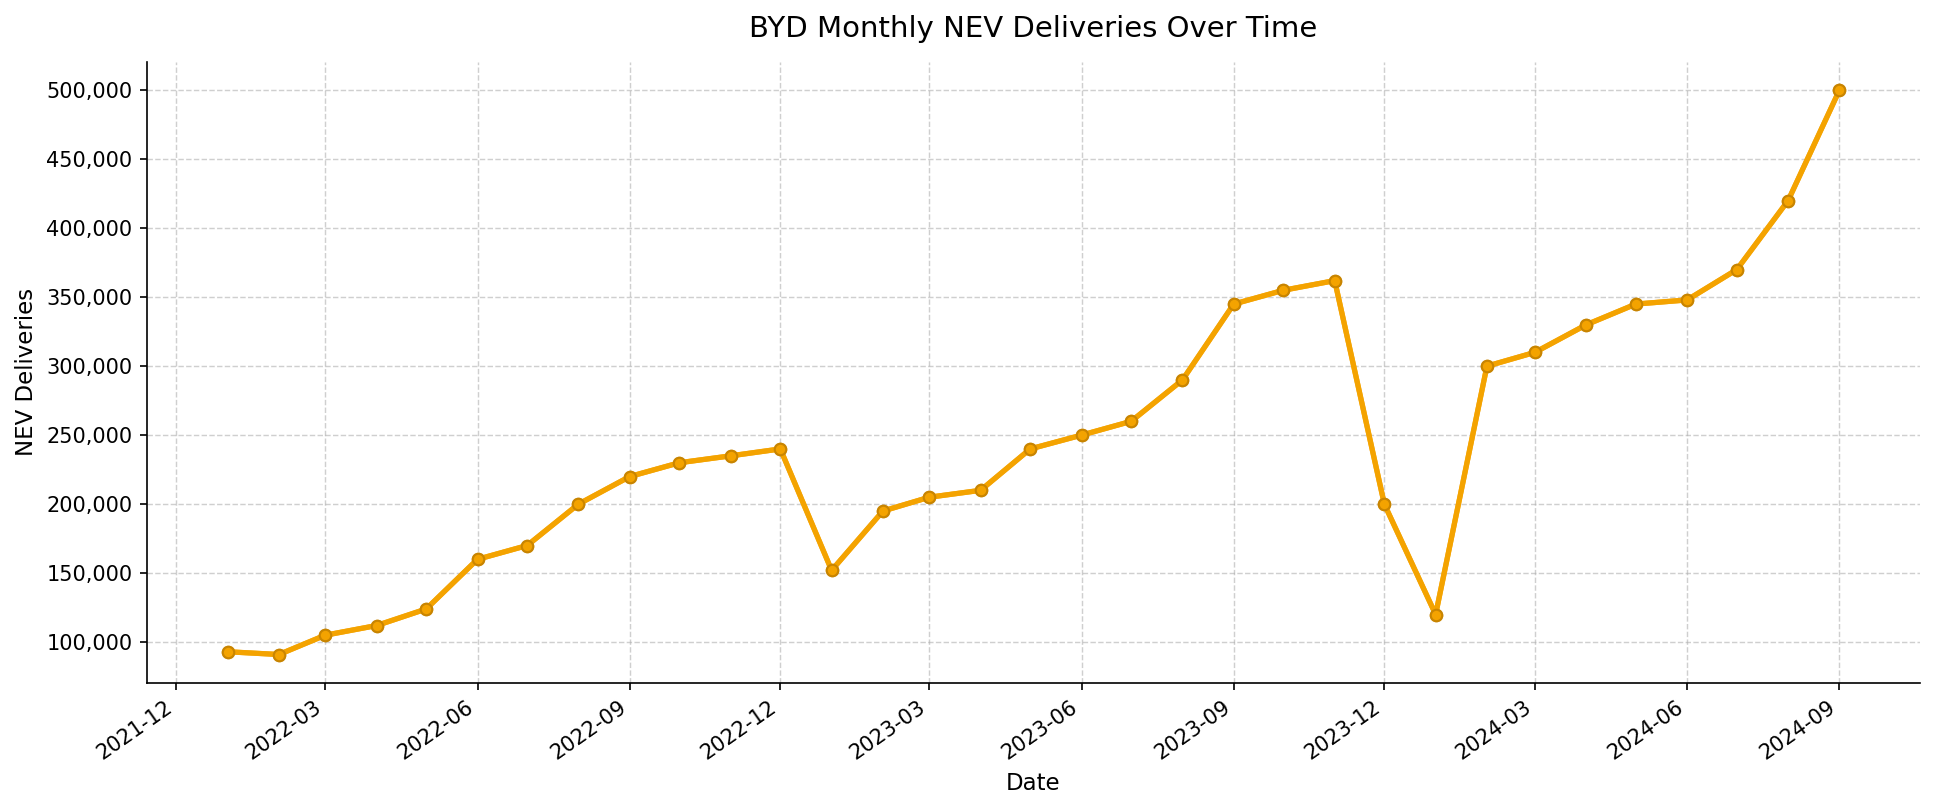

In [ ]:
# monthly_deliveries_plot.py
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

def _prep_df(df, date_col="date", value_col="deliveries"):
    """
    Normalizes and cleans the dataframe:
    - parses dates
    - keeps the latest entry per month if duplicates exist
    - sorts by date
    """
    df = df.copy()
    # Parse dates (accepts YYYY-MM or YYYY-MM-DD)
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df = df.dropna(subset=[date_col, value_col])
    # Ensure numeric
    df[value_col] = pd.to_numeric(df[value_col], errors="coerce")
    df = df.dropna(subset=[value_col])

    # Use month start to collapse to monthly granularity
    df["_month"] = df[date_col].dt.to_period("M").dt.to_timestamp()

    # If duplicates per month, keep the last one (or use .mean() if you prefer)
    df = df.sort_values([ "_month", date_col])
    df = df.groupby("_month", as_index=False).tail(1)

    # Sort final
    df = df.sort_values("_month").rename(columns={"_month": "date"})
    return df[["date", value_col]]

def _thousands(x, pos):
    # 300000 -> "300,000"
    try:
        return f"{int(x):,}"
    except Exception:
        return x

def plot_monthly_series(df,
                        value_col="deliveries",
                        title="Monthly NEV Deliveries Over Time",
                        ylabel="NEV Deliveries",
                        figsize=(13, 5.5),
                        line_color="#F4A300",          # match your orange
                        marker_edge="#C88400",
                        save_path=None,
                        show=True):
    """
    Plots a single monthly time series with markers, grid, and nice date/y formatting.
    """
    df = _prep_df(df, date_col="date", value_col=value_col)

    fig, ax = plt.subplots(figsize=figsize, dpi=150)

    ax.plot(
        df["date"], df[value_col],
        marker="o",
        linewidth=2.5,
        markersize=5.5,
        color=line_color,
        markeredgecolor=marker_edge,
        markerfacecolor=line_color,
        alpha=0.95
    )

    # Title & labels
    ax.set_title(title, fontsize=14, pad=12)
    ax.set_xlabel("Date", fontsize=11)
    ax.set_ylabel(ylabel, fontsize=11)

    # X-axis: monthly ticks with quarter major ticks for readability
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.setp(ax.get_xticklabels(), rotation=35, ha="right")

    # Y-axis formatting with thousands separators
    ax.yaxis.set_major_formatter(FuncFormatter(_thousands))

    # Grid & spines (similar look to your figure)
    ax.grid(True, which="major", linestyle="--", linewidth=0.7, alpha=0.6)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

    # Tight layout
    plt.tight_layout()

    # Save / show
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    if show:
        plt.show()
    plt.close(fig)

def plot_from_csv(csv_path,
                  date_col="date",
                  value_col="deliveries",
                  **plot_kwargs):
    """
    Convenience wrapper for CSVs.
    CSV expected columns:
      - date (YYYY-MM or YYYY-MM-DD)
      - deliveries (integer)
    """
    df = pd.read_csv(csv_path)
    df = df.rename(columns={date_col: "date", value_col: "deliveries"})
    plot_monthly_series(df, value_col="deliveries", **plot_kwargs)

def plot_from_mapping(month_to_value,
                      **plot_kwargs):
    """
    Convenience wrapper for a Python mapping like:
      {"2022-01": 93000, "2022-02": 91000, ...}
    """
    df = pd.DataFrame(
        {"date": list(month_to_value.keys()),
         "deliveries": list(month_to_value.values())}
    )
    plot_monthly_series(df, value_col="deliveries", **plot_kwargs)

# -------------------------
# EXAMPLES
# -------------------------
if __name__ == "__main__":
    # 1) From CSV
    # plot_from_csv(
    #     "byd_nev_monthly.csv",
    #     date_col="date",
    #     value_col="deliveries",
    #     title="BYD Monthly NEV Deliveries Over Time",
    #     ylabel="NEV Deliveries",
    #     save_path="byd_nev_deliveries.png"
    # )

    # 2) From a Python dict (toy sample — replace with your real values)
    sample = {
        "2022-01": 93000, "2022-02": 91000, "2022-03": 105000, "2022-04": 112000,
        "2022-05": 124000, "2022-06": 160000, "2022-07": 170000, "2022-08": 200000,
        "2022-09": 220000, "2022-10": 230000, "2022-11": 235000, "2022-12": 240000,
        "2023-01": 152000, "2023-02": 195000, "2023-03": 205000, "2023-04": 210000,
        "2023-05": 240000, "2023-06": 250000, "2023-07": 260000, "2023-08": 290000,
        "2023-09": 345000, "2023-10": 355000, "2023-11": 362000, "2023-12": 200000,
        "2024-01": 120000, "2024-02": 300000, "2024-03": 310000, "2024-04": 330000,
        "2024-05": 345000, "2024-06": 348000, "2024-07": 370000, "2024-08": 420000,
        "2024-09": 500000
    }
    plot_from_mapping(
        sample,
        title="BYD Monthly NEV Deliveries Over Time",
        ylabel="NEV Deliveries",
        save_path="byd_nev_deliveries.png"
    )


/tmp/ipython-input-1114522462.py:75: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  r = g.resample(freq).last()


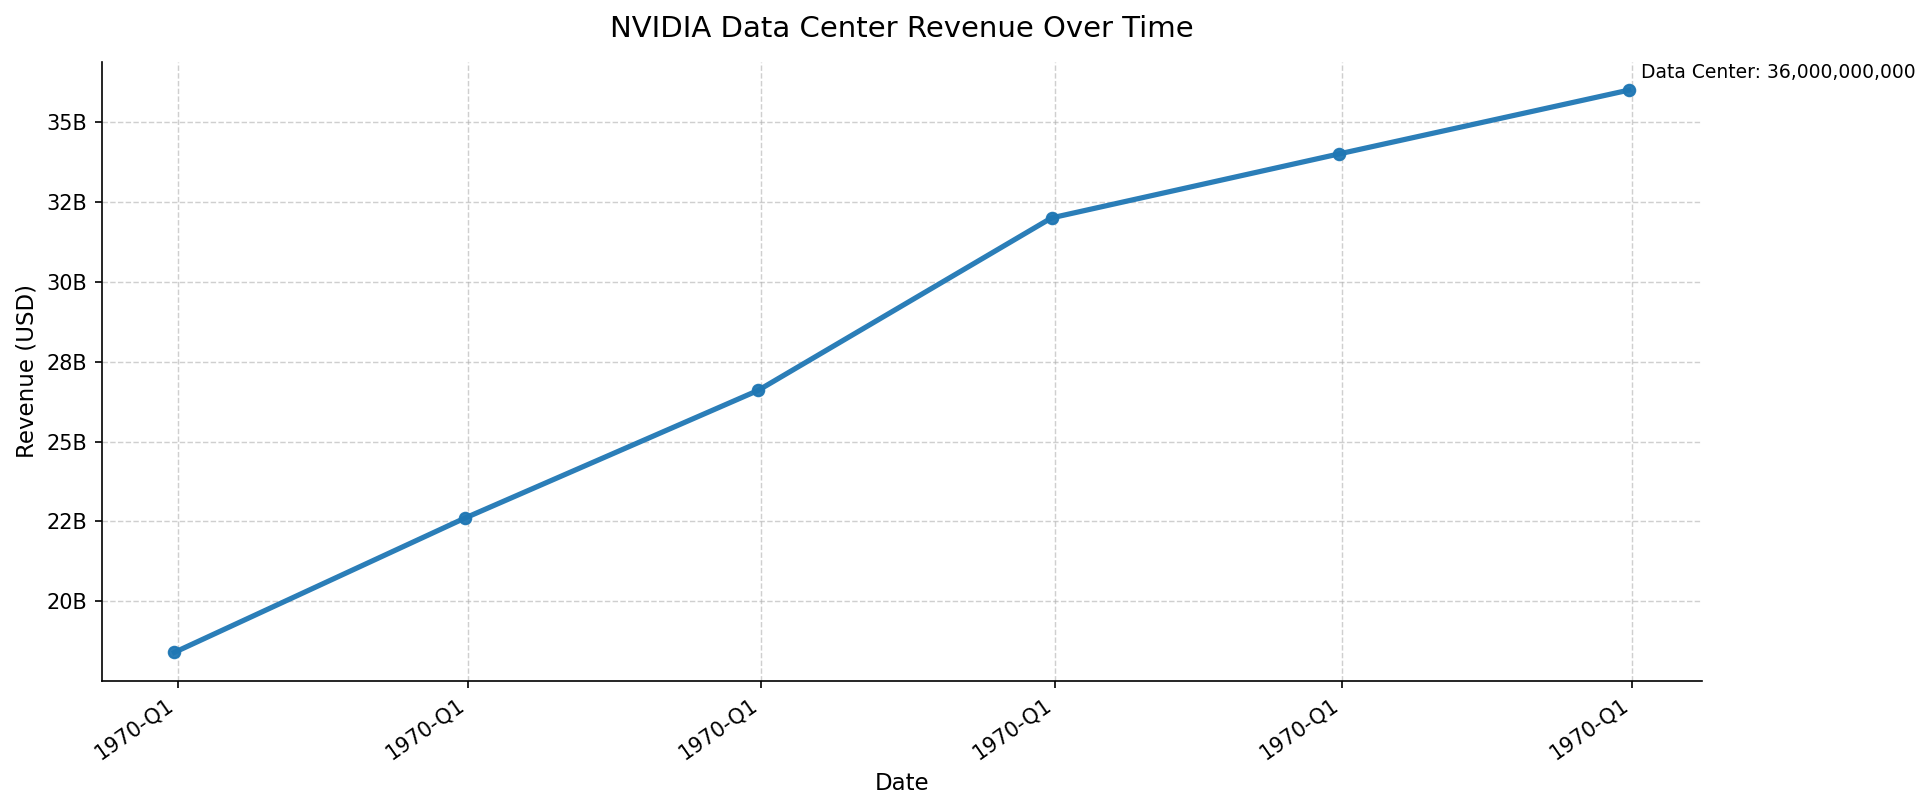

/tmp/ipython-input-1114522462.py:75: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  r = g.resample(freq).last()


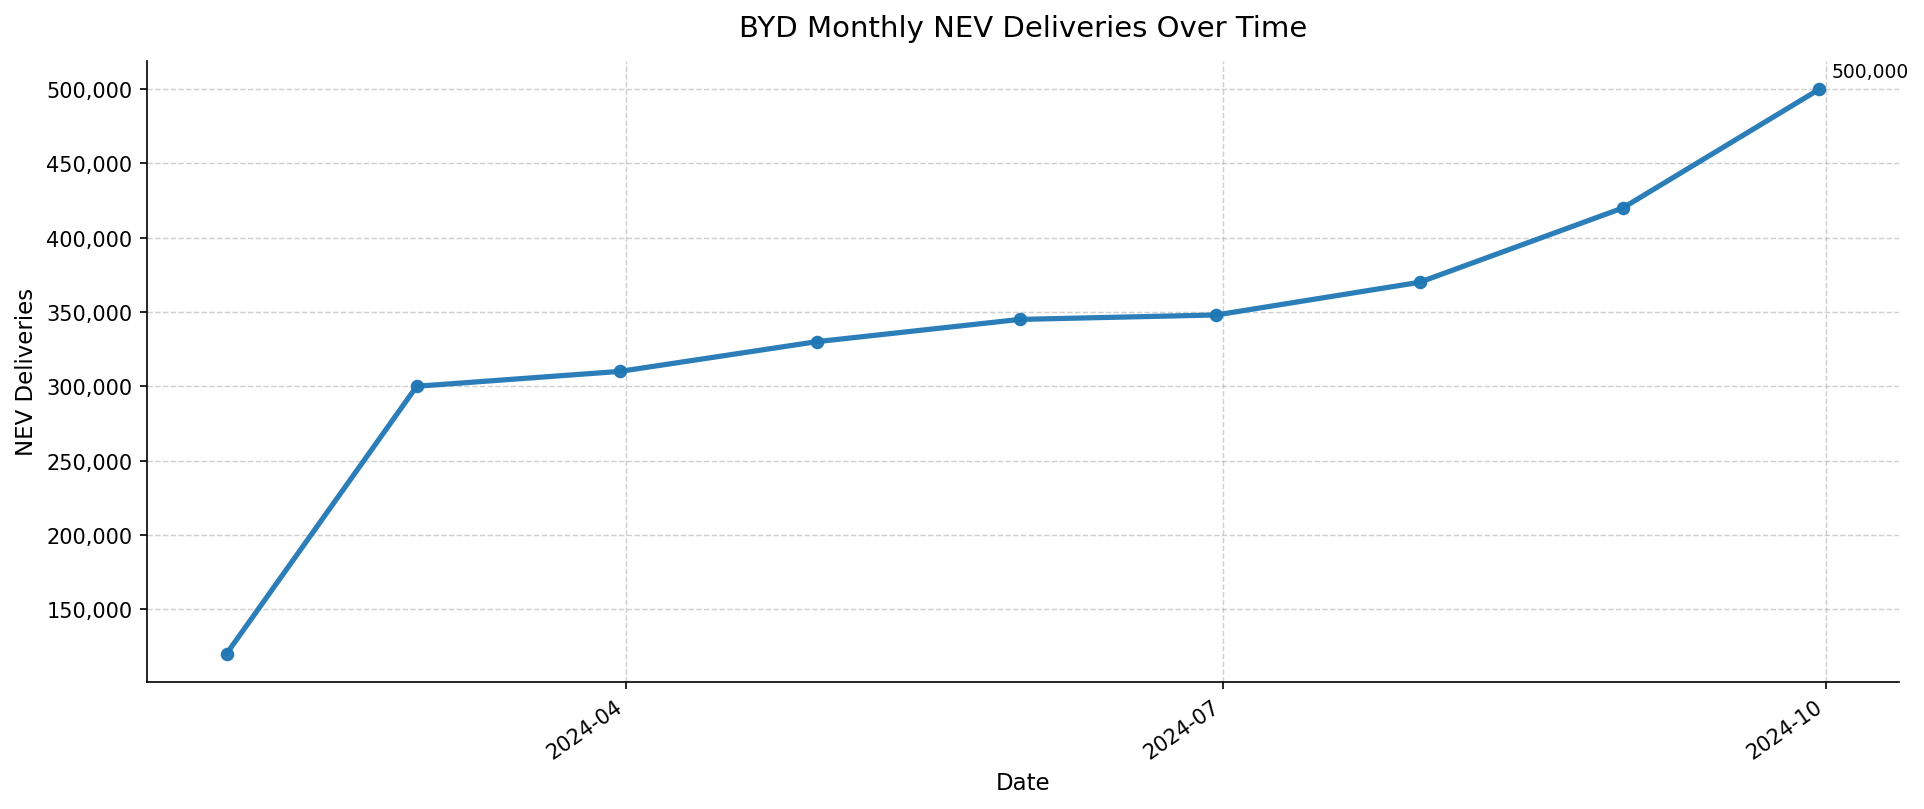

/tmp/ipython-input-1114522462.py:75: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  r = g.resample(freq).last()
/tmp/ipython-input-1114522462.py:75: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  r = g.resample(freq).last()
/tmp/ipython-input-1114522462.py:75: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  r = g.resample(freq).last()


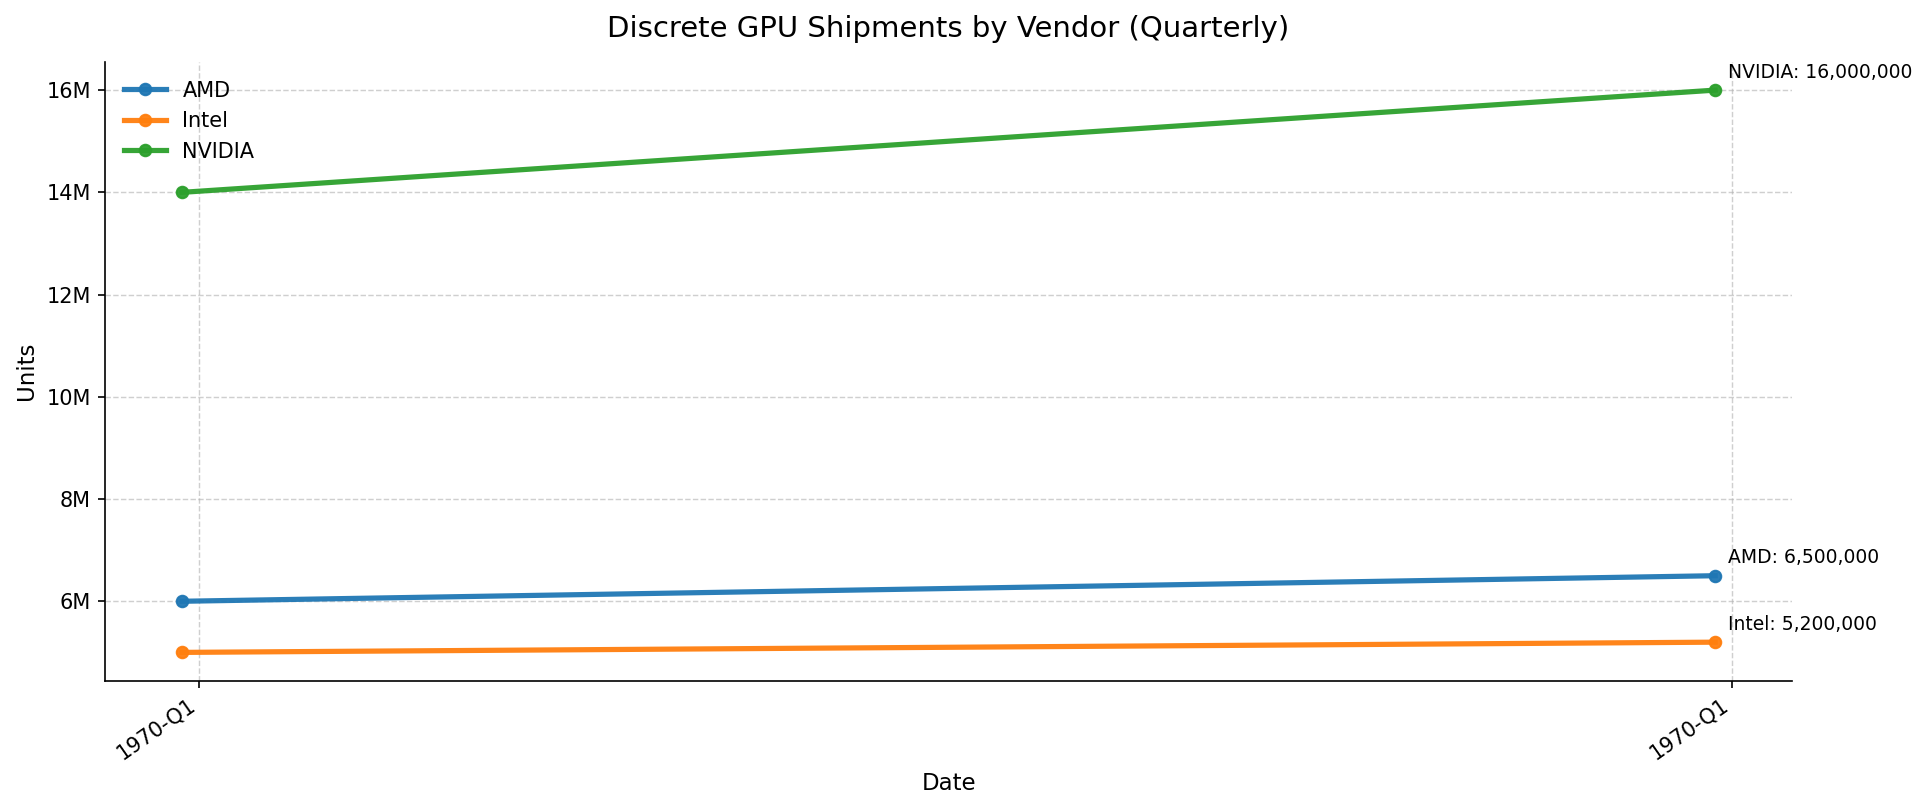

In [ ]:
# generic_timeseries_plot.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

# ---------- helpers ----------
def _read_any(data):
    """Return a DataFrame from path/JSON/Excel/CSV or a DataFrame itself."""
    if isinstance(data, pd.DataFrame):
        return data.copy()
    if isinstance(data, str):
        lower = data.lower()
        if lower.endswith((".csv", ".tsv")):
            sep = "," if lower.endswith(".csv") else "\t"
            return pd.read_csv(data, sep=sep)
        if lower.endswith((".xlsx", ".xls")):
            return pd.read_excel(data)
        if lower.endswith(".json"):
            return pd.read_json(data)
    raise ValueError("Provide a DataFrame or a file path (.csv/.tsv/.xlsx/.xls/.json).")

def _prep_df(data, date_col="date", value_col="value", series_col=None,
             aggregate="last"):
    """
    Normalize columns:
      - date_col -> parsed datetime
      - value_col -> numeric
      - series_col (optional) -> string
    De-duplicate within same period using aggregate: 'last'|'sum'|'mean'
    """
    df = _read_any(data)
    # rename to canonical names (so callers can pass arbitrary column names)
    df = df.rename(columns={date_col: "date", value_col: "value"})
    if series_col and series_col in df.columns:
        df = df.rename(columns={series_col: "series"})
    else:
        df["series"] = "_single"

    # parse + clean
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df["value"] = pd.to_numeric(df["value"], errors="coerce")
    df = df.dropna(subset=["date", "value"])

    # sort for stable aggregation
    df = df.sort_values(["series", "date"])

    # pick aggregator for duplicates on the exact same date
    aggfunc = {"last": "last", "sum": "sum", "mean": "mean"}[aggregate]
    df = df.groupby(["series", "date"], as_index=False).agg({"value": aggfunc})
    return df

def _infer_freq(dates):
    """Infer 'M' (monthly) or 'Q' (quarterly) from median spacing."""
    if len(dates) < 3:
        return "M"
    diffs = pd.Series(dates).sort_values().diff().dropna().dt.days
    med = diffs.median()
    # loose thresholds
    if med >= 70:   # ~ 3 months
        return "Q"
    return "M"

def _resample(df, target_freq="auto", aggregate="last"):
    """
    Resample each series to monthly ('M') or quarterly ('Q') grid.
    Accepts irregular dates and collapses to period start.
    """
    out = []
    for s, g in df.groupby("series"):
        freq = _infer_freq(g["date"]) if target_freq == "auto" else target_freq
        g = g.set_index("date").sort_index()
        if aggregate == "last":
            r = g.resample(freq).last()
        elif aggregate == "sum":
            r = g.resample(freq).sum()
        else:
            r = g.resample(freq).mean()
        r["series"] = s
        out.append(r.reset_index())
    res = pd.concat(out, ignore_index=True)
    return res, (target_freq if target_freq != "auto" else _infer_freq(res["date"]))

def _fmt_thousands(x, pos):
    try:
        return f"{int(x):,}"
    except Exception:
        return str(x)

def _fmt_human_scale(x, pos):
    n = float(x)
    for unit in ["", "K", "M", "B", "T"]:
        if abs(n) < 1000:
            return f"{n:,.0f}{unit}"
        n /= 1000.0
    return f"{n:,.0f}P"

# ---------- main plotter ----------
def plot_time_series(
    data,
    date_col="date",
    value_col="value",
    series_col=None,
    target_freq="auto",         # 'M', 'Q', or 'auto'
    aggregate="last",           # 'last'|'sum'|'mean' when resampling
    title="Time Series Over Time",
    ylabel="Value",
    y_format="comma",           # 'comma' or 'human'
    annotate_last=True,
    annotate_record=False,
    figsize=(13, 5.5),
    save_path=None,
    show=True,
):
    """
    General-purpose plotting for monthly or quarterly series (single or multi).
    Examples:
      - BYD monthly deliveries
      - NVDA quarterly revenue (e.g., Data Center)
      - GPU shipments by vendor (multi-line, quarterly)
    """
    df = _prep_df(data, date_col, value_col, series_col, aggregate=aggregate)
    df, freq = _resample(df, target_freq=target_freq, aggregate=aggregate)

    # axis formatter
    if y_format == "human":
        yfmt = FuncFormatter(_fmt_human_scale)
    else:
        yfmt = FuncFormatter(_fmt_thousands)

    # pick date locators/formatters
    if freq == "Q":
        # quarter ticks every quarter; custom label "YYYY-Qn"
        locator = mdates.MonthLocator(bymonth=[1, 4, 7, 10], interval=1)
        def quarter_fmt(d, pos):
            d = pd.Timestamp(d)
            q = (d.month - 1) // 3 + 1
            return f"{d.year}-Q{q}"
        formatter = FuncFormatter(quarter_fmt)
    else:  # 'M'
        locator = mdates.MonthLocator(interval=3)
        formatter = mdates.DateFormatter("%Y-%m")

    # plot
    fig, ax = plt.subplots(figsize=figsize, dpi=150)
    for i, (s, g) in enumerate(df.groupby("series")):
        g = g.sort_values("date")
        line, = ax.plot(
            g["date"], g["value"],
            marker="o", linewidth=2.5, markersize=5.5, alpha=0.95,
            label=None if s == "_single" else s
        )
        # annotate last point
        if annotate_last and len(g):
            last = g.iloc[-1]
            ax.annotate(
                f"{'' if s == '_single' else s+': '}{last['value']:,.0f}",
                xy=(last["date"], last["value"]),
                xytext=(6, 6), textcoords="offset points", fontsize=9
            )
        # annotate record high
        if annotate_record and len(g):
            idx = g["value"].idxmax()
            peak = g.loc[idx]
            ax.scatter([peak["date"]], [peak["value"]], s=30)
            ax.annotate(
                f"Peak: {peak['value']:,.0f}",
                xy=(peak["date"], peak["value"]),
                xytext=(0, -18), textcoords="offset points",
                ha="center", fontsize=9
            )

    ax.set_title(title, fontsize=14, pad=12)
    ax.set_xlabel("Date", fontsize=11)
    ax.set_ylabel(ylabel, fontsize=11)

    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    plt.setp(ax.get_xticklabels(), rotation=35, ha="right")

    ax.yaxis.set_major_formatter(yfmt)

    ax.grid(True, linestyle="--", linewidth=0.7, alpha=0.6)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

    # legend only if multiple series
    if df["series"].nunique() > 1:
        ax.legend(frameon=False)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    if show:
        plt.show()
    plt.close(fig)

# ---------- quick recipes ----------
if __name__ == "__main__":
    # 1) NVDA quarterly revenue (example structure; replace with real numbers)
    nvda = pd.DataFrame({
        "segment": ["Data Center"] * 6,
        "date": ["2024-01-28","2024-04-28","2024-07-28","2024-10-27","2025-01-26","2025-04-27"],
        "revenue_usd": [18400000000, 22600000000, 26600000000, 32000000000, 34000000000, 36000000000]
    })
    plot_time_series(
        nvda, date_col="date", value_col="revenue_usd", series_col="segment",
        target_freq="Q",
        title="NVIDIA Data Center Revenue Over Time",
        ylabel="Revenue (USD)",
        y_format="human",
        save_path="nvda_datacenter_revenue.png"
    )

    # 2) BYD monthly deliveries (single-line)
    byd = pd.DataFrame({
        "date": ["2024-01","2024-02","2024-03","2024-04","2024-05","2024-06","2024-07","2024-08","2024-09"],
        "deliveries": [120000,300000,310000,330000,345000,348000,370000,420000,500000]
    })
    plot_time_series(
        byd, date_col="date", value_col="deliveries",
        target_freq="M",
        title="BYD Monthly NEV Deliveries Over Time",
        ylabel="NEV Deliveries",
        y_format="comma",
        save_path="byd_deliveries.png"
    )

    # 3) Multi-series comparison (e.g., GPU shipments by vendor, quarterly)
    shipments = pd.DataFrame({
        "vendor": ["NVIDIA","AMD","Intel","NVIDIA","AMD","Intel"],
        "date":   ["2024-01-01","2024-01-01","2024-01-01","2024-04-01","2024-04-01","2024-04-01"],
        "units":  [14000000, 6000000, 5000000, 16000000, 6500000, 5200000]
    })
    plot_time_series(
        shipments, date_col="date", value_col="units", series_col="vendor",
        target_freq="Q",
        title="Discrete GPU Shipments by Vendor (Quarterly)",
        ylabel="Units",
        y_format="human",
        save_path="gpu_shipments.png"
    )


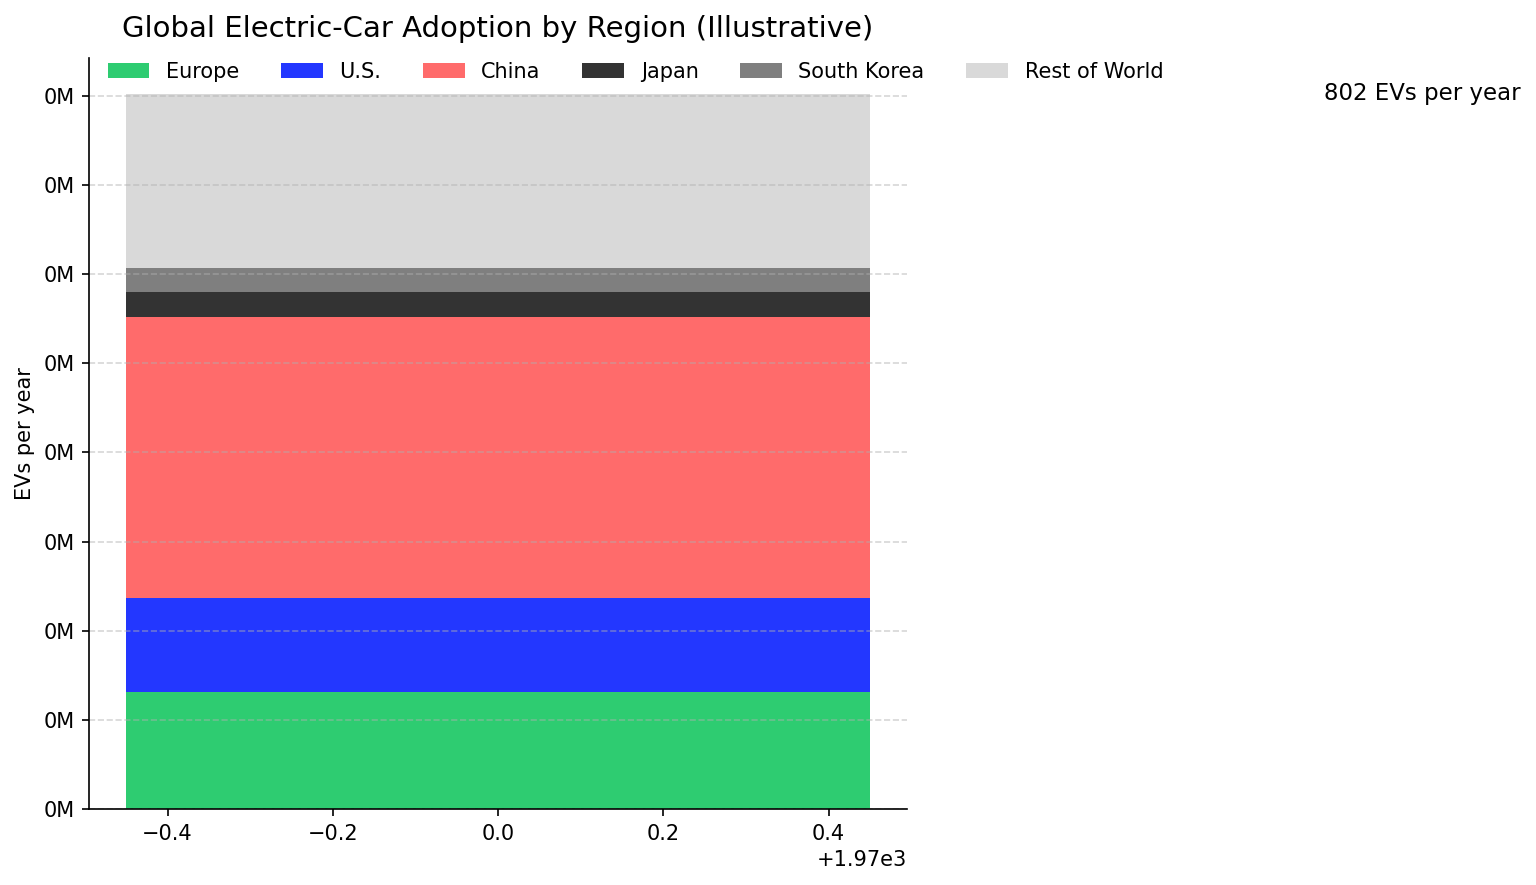

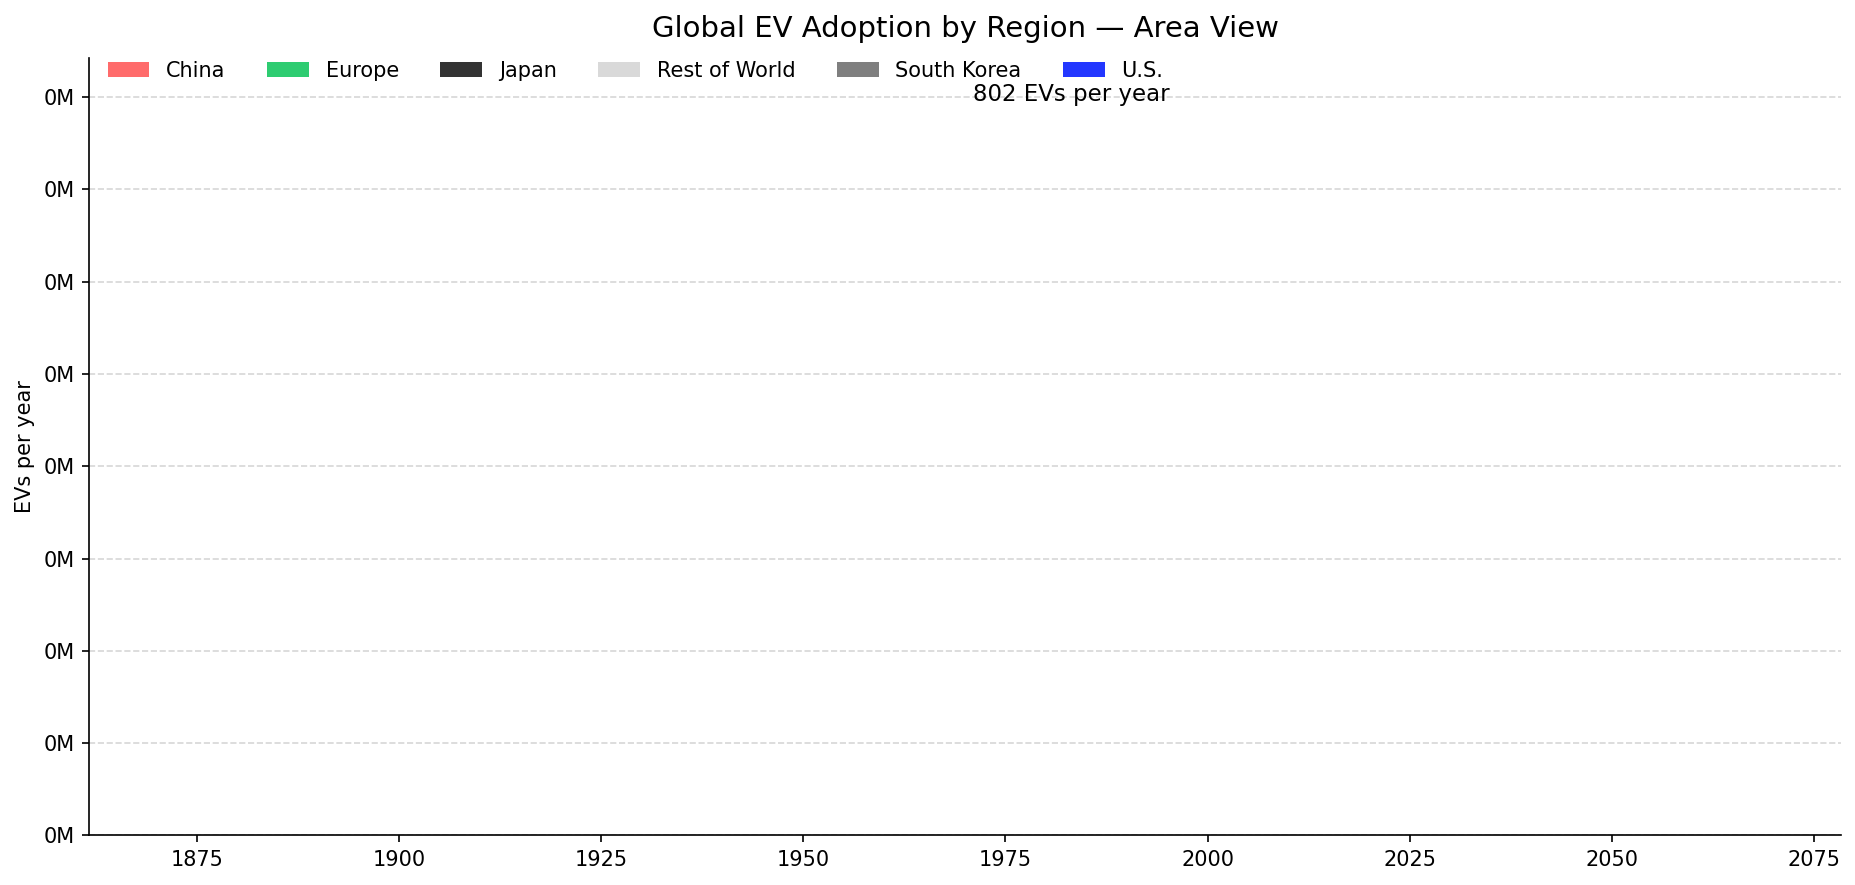

In [ ]:
# stacked_regions_plot.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# ---------- I/O & shaping ----------
def _read_any(data):
    if isinstance(data, pd.DataFrame): return data.copy()
    if isinstance(data, str) and data.lower().endswith((".csv", ".tsv")):
        return pd.read_csv(data, sep="," if data.lower().endswith(".csv") else "\t")
    if isinstance(data, str) and data.lower().endswith((".xlsx", ".xls")):
        return pd.read_excel(data)
    if isinstance(data, str) and data.lower().endswith(".json"):
        return pd.read_json(data)
    raise ValueError("Pass a DataFrame or a file path (.csv/.tsv/.xlsx/.xls/.json).")

def _to_long(df, time_col="year", category_col=None, value_col=None):
    """
    Accepts:
      LONG:  columns = [time_col, category_col, value_col]
      WIDE:  columns = [time_col, region1, region2, ...]
    Returns long df: [time, category, value]
    """
    if category_col and value_col:
        out = df.rename(columns={time_col:"time", category_col:"category", value_col:"value"})
    else:
        # wide → long
        id_vars = [time_col]
        value_vars = [c for c in df.columns if c not in id_vars]
        out = df.melt(id_vars=id_vars, value_vars=value_vars,
                      var_name="category", value_name="value").rename(columns={time_col:"time"})
    # clean
    out["value"] = pd.to_numeric(out["value"], errors="coerce")
    # year/int
    try:
        out["time"] = pd.to_datetime(out["time"], errors="coerce").dt.year
    except Exception:
        pass
    out["time"] = pd.to_numeric(out["time"], errors="coerce").astype("Int64")
    out = out.dropna(subset=["time","category","value"])
    out["time"] = out["time"].astype(int)
    return out

# ---------- main ----------
def plot_stacked_regions(
    data,
    time_col="year",
    category_col=None,     # required for long; ignored for wide
    value_col=None,        # required for long; ignored for wide
    order=None,            # list for stack order (bottom→top). If None, uses alphabetical.
    colors=None,           # dict {category: "#hex"} or list aligned to 'order'
    total_category=None,   # if provided and present, creates RestOfWorld = Total - sum(others)
    rest_label="Rest of World",
    chart="bar",           # 'bar' or 'area'
    y_scale="million",     # 'raw' | 'million' | 'human'
    unit_label="EVs per year",
    title="Global EV Projections by Region",
    annotate_total=True,   # show right-side total like "60M EVs per year"
    figsize=(12.5, 6),
    save_path=None,
    show=True,
):
    # ingest → long
    df_raw = _read_any(data)
    df = _to_long(df_raw, time_col=time_col, category_col=category_col, value_col=value_col)

    # pivot to wide by year for easy stacking math
    piv = df.pivot_table(index="time", columns="category", values="value", aggfunc="sum").fillna(0)
    piv = piv.sort_index()

    # derive Rest of World from a Total column if asked
    if total_category and total_category in piv.columns:
        others = [c for c in piv.columns if c != total_category]
        rest = (piv[total_category] - piv[others].sum(axis=1)).clip(lower=0)
        piv = piv[others]  # drop Total
        piv[rest_label] = rest

    # stack order
    cols = list(piv.columns)
    if order:
        # keep only those present; then add any leftover at end
        ordered = [c for c in order if c in cols] + [c for c in cols if c not in set(order)]
        cols = ordered
    piv = piv.reindex(columns=cols)

    # scaling & y-axis formatter
    if y_scale == "million":
        scale = 1e6
        yfmt = FuncFormatter(lambda x, pos: f"{x/1e6:,.0f}M")
        ylab = f"{unit_label}"
    elif y_scale == "human":
        def human(x, pos):
            n = float(x)
            for u in ["","K","M","B","T"]:
                if abs(n) < 1000: return f"{n:,.0f}{u}"
                n /= 1000
            return f"{n:,.0f}P"
        scale, yfmt, ylab = 1.0, FuncFormatter(human), unit_label
    else:
        scale, yfmt, ylab = 1.0, FuncFormatter(lambda x,p: f"{x:,.0f}"), unit_label

    W = piv / scale
    years = W.index.values
    totals = W.sum(axis=1)

    # default palette (Bloomberg-ish)
    default_palette = {
        "Europe": "#2ecc71",      # green
        "U.S.": "#2337ff",        # blue
        "China": "#ff6b6b",       # red/coral
        "Japan": "#333333",       # dark gray
        "South Korea": "#7f7f7f", # mid gray
        rest_label: "#d9d9d9"     # light gray
    }
    if isinstance(colors, dict):
        color_list = [colors.get(c, default_palette.get(c, None)) for c in W.columns]
    elif isinstance(colors, (list, tuple)):
        color_list = list(colors) + [None] * (W.shape[1] - len(colors))
    else:
        color_list = [default_palette.get(c, None) for c in W.columns]

    # ----- plot -----
    fig, ax = plt.subplots(figsize=figsize, dpi=150)

    if chart == "area":
        ax.stackplot(years, W.T.values, labels=W.columns, colors=color_list, edgecolor="none")
    else:
        bottoms = np.zeros(len(W))
        for i, col in enumerate(W.columns):
            ax.bar(years, W[col].values, bottom=bottoms, width=0.9,
                   label=col, color=(color_list[i] if i < len(color_list) else None))
            bottoms += W[col].values

    # axes, legend, grid
    ax.set_title(title, fontsize=14, pad=10)
    ax.set_ylabel(ylab)
    ax.set_xlabel("")
    ax.yaxis.set_major_formatter(yfmt)
    # nice year ticks
    if len(years) > 10:
        step = max(1, (years[-1] - years[0]) // 10)
        ax.set_xticks(np.arange(years[0], years[-1] + 1, step))
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    ax.legend(ncol=min(6, W.shape[1]), frameon=False, loc="upper left", bbox_to_anchor=(0, 1.02))
    for s in ("top","right"): ax.spines[s].set_visible(False)

    # right-side total annotation (e.g., "60M EVs per year")
    if annotate_total and len(years):
        last_y, last_total = years[-1], totals.iloc[-1]
        pad = max(1, (years[-1] - years[0]) * 0.01)
        ax.text(last_y + pad, last_total, f"{last_total:,.0f} " + unit_label,
                va="center", fontsize=11)

    plt.tight_layout()
    if save_path: plt.savefig(save_path, bbox_inches="tight")
    if show: plt.show()
    plt.close(fig)


# -------------- examples --------------
if __name__ == "__main__":
    # Example (toy numbers; replace with your projections or historicals)
    df_example = pd.DataFrame({
        "year":  list(range(2015, 2041)),
        "Europe":       np.linspace(0.1, 10, 26),
        "U.S.":         np.linspace(0.1, 10, 26) * 0.8,
        "China":        np.linspace(0.2, 20, 26) * 1.2,
        "Japan":        np.linspace(0.02, 2.2, 26),
        "South Korea":  np.linspace(0.03, 2.0, 26),
        "Rest of World":np.linspace(0.05, 15, 26)
    }) * 1e6  # values in units; we'll display as "M"

    # WIDE → Stacked BAR (Bloomberg style)
    plot_stacked_regions(
        df_example,
        time_col="year",                 # wide format → category_col/value_col not needed
        order=["Europe","U.S.","China","Japan","South Korea","Rest of World"],
        chart="bar",
        y_scale="million",               # show as M on the y-axis
        unit_label="EVs per year",
        title="Global Electric-Car Adoption by Region (Illustrative)",
        save_path="ev_projection_stacked_bar.png"
    )

    # LONG format variant (same plot as AREA)
    long_example = df_example.melt(id_vars="year", var_name="region", value_name="value")
    plot_stacked_regions(
        long_example,
        time_col="year",
        category_col="region",
        value_col="value",
        chart="area",
        y_scale="million",
        unit_label="EVs per year",
        title="Global EV Adoption by Region — Area View",
        save_path="ev_projection_stack_area.png"
    )


In [ ]:
# dcf_general.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# helpers
# ---------------------------
def linear_path(start, end, years):
    """Inclusive linear path of length `years` from start -> end."""
    return np.linspace(start, end, years)

def ensure_path(spec, years):
    """
    Make an array of length `years` from a spec:
      - number -> flat path
      - (start, end) -> linear path
      - list/np.array -> used as-is (len must == years)
    """
    if isinstance(spec, (int, float)):
        return np.full(years, float(spec))
    if isinstance(spec, (list, tuple, np.ndarray)) and len(spec) == 2:
        return linear_path(float(spec[0]), float(spec[1]), years)
    arr = np.array(spec, dtype=float)
    if arr.size != years:
        raise ValueError(f"path length {arr.size} != years {years}")
    return arr

def stable_roic(margin, tax_rate, sales_to_capital):
    """
    Approximate incremental ROIC from margin, tax, and Sales/Capital:
      ROIC ≈ EBIT margin * (1 - tax) * (Sales/Capital)
    """
    return float(margin) * (1 - float(tax_rate)) * float(sales_to_capital)

# ---------------------------
# core DCF
# ---------------------------
def dcf_valuation(
    years=10,
    start_revenue=1.0,                # currency units (e.g., USD)
    growth=0.05,                      # % per year (scalar, (start,end), or list of len years)
    ebit_margin=(0.10, 0.12),         # % of revenue
    tax_rate=(0.20, 0.25),            # effective tax rate %
    sales_to_capital=(1.0, 1.4),      # revenue / invested capital
    wacc=(0.09, 0.085),               # discount rate path
    terminal_growth=0.03,             # long-run g
    # balance-sheet adjustments at valuation date (now)
    cash_and_nonop=0.0,
    debt=0.0,
    minority_interest=0.0,
    shares_outstanding=1.0,
    currency="USD"
):
    """
    Returns (df, summary) where:
      df: year-by-year projections
      summary: dict with PVs, equity value, value/share, implied stable ROIC, etc.
    """
    # Build paths
    g      = ensure_path(growth, years)            # revenue growth
    m      = ensure_path(ebit_margin, years)       # EBIT margin
    t      = ensure_path(tax_rate, years)          # tax
    s2c    = ensure_path(sales_to_capital, years)  # Sales/Capital
    r      = ensure_path(wacc, years)              # WACC

    # Project revenue
    rev = np.zeros(years)
    rev[0] = start_revenue * (1 + g[0])
    for i in range(1, years):
        rev[i] = rev[i-1] * (1 + g[i])

    # Operating metrics
    ebit  = rev * m
    nopat = ebit * (1 - t)

    # Reinvestment from Sales-to-Capital:
    # ΔRevenue / (Sales/Capital). Negative allowed (releases capital).
    delta_rev = np.diff(np.insert(rev, 0, start_revenue))
    reinvest  = delta_rev / s2c

    # FCFF
    fcff = nopat - reinvest

    # Discount factors & PV of FCFF
    disc = np.cumprod(1 + r)
    pv_fcff = fcff / disc

    # Terminal value (end of Year N): FCFF_{N+1} / (WACC_N - g)
    # Use stable reinvestment rate = g / ROIC_stable
    m_T, t_T, s2c_T, r_T = m[-1], t[-1], s2c[-1], r[-1]
    roic_T = stable_roic(m_T, t_T, s2c_T)
    if r_T <= terminal_growth:
        raise ValueError("WACC must be > terminal growth for finite TV.")
    # Next-year revenue & NOPAT in steady state
    rev_T1   = rev[-1] * (1 + terminal_growth)
    ebit_T1  = rev_T1 * m_T
    nopat_T1 = ebit_T1 * (1 - t_T)

    reinvest_rate_T = (terminal_growth / max(roic_T, 1e-9))  # guard tiny ROIC
    reinvest_T1     = nopat_T1 * reinvest_rate_T
    fcff_T1         = nopat_T1 - reinvest_T1
    terminal_value  = fcff_T1 / (r_T - terminal_growth)
    pv_terminal     = terminal_value / disc[-1]

    # Totals
    pv_fcff_sum = pv_fcff.sum()
    op_assets   = pv_fcff_sum + pv_terminal
    equity_value = op_assets + cash_and_nonop - debt - minority_interest
    value_per_share = equity_value / shares_outstanding

    # Pack table
    df = pd.DataFrame({
        "Year": np.arange(1, years + 1),
        "Revenue": rev,
        "Growth": g,
        "EBIT_Margin": m,
        "EBIT": ebit,
        "TaxRate": t,
        "NOPAT": nopat,
        "Sales_to_Capital": s2c,
        "ΔRevenue": delta_rev,
        "Reinvestment": reinvest,
        "FCFF": fcff,
        "WACC": r,
        "Disc_Factor": disc,
        "PV_FCFF": pv_fcff
    })

    summary = {
        "PV_FCFF_10y": pv_fcff_sum,
        "Terminal_Value": terminal_value,
        "PV_Terminal": pv_terminal,
        "Operating_Assets_Value": op_assets,
        "Cash_and_NonOperating": cash_and_nonop,
        "Debt": debt,
        "Minority_Interest": minority_interest,
        "Equity_Value": equity_value,
        "Shares_Outstanding": shares_outstanding,
        "Value_per_Share": value_per_share,
        "Stable_ROIC": roic_T,
        "Stable_Reinvestment_Rate": reinvest_rate_T,
        "Currency": currency
    }
    return df, summary

# ---------------------------
# optional quick plot
# ---------------------------
def plot_dcf(df):
    fig, ax = plt.subplots(figsize=(10,4), dpi=120)
    ax.plot(df["Year"], df["Revenue"], marker="o")
    ax.set_xlabel("Year"); ax.set_ylabel("Revenue")
    ax2 = ax.twinx()
    ax2.plot(df["Year"], df["FCFF"], marker="o", linestyle="--")
    ax2.set_ylabel("FCFF")
    ax.grid(True, linestyle="--", alpha=0.5)
    fig.tight_layout()
    plt.show()

# ---------------------------
# usage examples (EDIT numbers!)
# ---------------------------
if __name__ == "__main__":
    # --- Example A: BYD-style inputs (replace with your actuals) ---
    byd_df, byd_sum = dcf_valuation(
        years=10,
        start_revenue=662.6e9,           # last FY revenue (CNY/USD—keep units consistent)
        growth=[0.10,0.095,0.09,0.085,0.08,0.07,0.06,0.055,0.05,0.0437],
        ebit_margin=(0.0588, 0.07),
        tax_rate=(0.1707, 0.25),
        sales_to_capital=(1.20, 1.60),
        wacc=(0.0889, 0.0870),
        terminal_growth=0.0437,
        cash_and_nonop=91_734.52e6,
        debt=46_886.03e6,
        minority_interest=0.0,
        shares_outstanding=1.098e9,
        currency="USD"
    )
    print("BYD summary:", byd_sum)

    # --- Example B: Semiconductor focus (NVIDIA-style scaffold) ---
    # NOTE: Numbers below are placeholders; plug in your latest FY revenue,
    # margin, tax, S/C, WACC, cash, debt, and shares to value NVDA.
    nvda_df, nvda_sum = dcf_valuation(
        years=10,
        start_revenue=80e9,              # <- replace with NVDA latest FY revenue
        growth=(0.20, 0.05),             # fast → mature growth
        ebit_margin=(0.40, 0.33),        # semis often high operating leverage
        tax_rate=(0.13, 0.16),
        sales_to_capital=(1.5, 2.0),     # asset-light vs foundry-heavy; tune as needed
        wacc=(0.09, 0.085),
        terminal_growth=0.03,
        cash_and_nonop=30e9,
        debt=12e9,
        minority_interest=0.0,
        shares_outstanding=2.45e9,       # diluted shares; update!
        currency="USD"
    )
    print("NVDA summary (placeholder):", nvda_sum)

    # plot_dcf(byd_df)    # optional
    # plot_dcf(nvda_df)   # optional


BYD summary: {'PV_FCFF_10y': np.float64(1046739535.7510643), 'Terminal_Value': np.float64(811555383871.8499), 'PV_Terminal': np.float64(349324843038.7988), 'Operating_Assets_Value': np.float64(350371582574.54987), 'Cash_and_NonOperating': 91734520000.0, 'Debt': 46886030000.0, 'Minority_Interest': 0.0, 'Equity_Value': np.float64(395220072574.54987), 'Shares_Outstanding': 1098000000.0, 'Value_per_Share': np.float64(359.94542128829676), 'Stable_ROIC': 0.08400000000000002, 'Stable_Reinvestment_Rate': 0.5202380952380952, 'Currency': 'USD'}
NVDA summary (placeholder): {'PV_FCFF_10y': np.float64(268386279141.76035), 'Terminal_Value': np.float64(1264108095618.5837), 'PV_Terminal': np.float64(546381808926.16943), 'Operating_Assets_Value': np.float64(814768088067.9298), 'Cash_and_NonOperating': 30000000000.0, 'Debt': 12000000000.0, 'Minority_Interest': 0.0, 'Equity_Value': np.float64(832768088067.9298), 'Shares_Outstanding': 2450000000.0, 'Value_per_Share': np.float64(339.9053420685428), 'Stable

In [ ]:
# valuation_summary_table.py
import pandas as pd

def _fmt_money(x, symbol="$"):
    return f"{symbol}{x:,.2f}"

def _fmt_pct(x):
    return f"{float(x)*100:,.2f}%"

def _maybe(value, symbol=""):
    return value if value is not None else "-"

def implied_roic(margin, tax_rate, sales_to_capital):
    """Approx incremental ROIC ≈ EBIT margin * (1 - tax) * Sales/Capital."""
    if margin is None or tax_rate is None or sales_to_capital is None:
        return None
    return float(margin) * (1 - float(tax_rate)) * float(sales_to_capital)

def build_valuation_summary(
    *,
    # Revenue block
    current_revenue,                  # last FY revenue (same units as you want to display)
    next_year_growth,                 # e.g., 0.10 for 10% or 0.0297 for 2.97%
    growth_2_5,                       # scalar (e.g., 0.10)
    growth_6_10,                      # scalar (e.g., 0.07)
    terminal_growth,                  # scalar (e.g., 0.0437)
    currency_symbol="$",
    # Operating margin path
    margin_next_year,                 # e.g., 0.0588
    margin_2_5=None,                  # e.g., 0.050 (optional)
    margin_6_10_to=None,              # e.g., 0.0667 (text: "Moves to X%")
    margin_after_10=None,             # e.g., 0.0700
    # Tax path
    tax_next_year=None,               # e.g., 0.1707
    tax_6_10=None,                    # value shown in "Years 6–10"
    tax_after_10=None,                # shown as "Changes to X%"
    # Sales-to-Capital
    s2c_2_5=None,                     # e.g., 1.20
    s2c_6_10=None,                    # e.g., 1.20
    s2c_after_10=None,                # e.g., 1.60
    # Return on capital (ROIC) — computed or override
    roic_next_year=None,              # if None, computed from margin_next_year, tax_next_year, s2c_2_5
    roic_2_5=None,                    # if None, computed from margin_2_5, tax_6_10, s2c_2_5
    roic_after_10=None,               # if None, computed from margin_after_10, tax_after_10, s2c_after_10
    # Cost of capital (WACC)
    wacc_2_5=None,                    # e.g., 0.0889
    wacc_after_10=None,               # e.g., 0.0870
):
    # Compute next-year revenue
    next_year_revenue = current_revenue * (1 + float(next_year_growth))

    # Compute ROICs if not provided
    if roic_next_year is None and all(v is not None for v in [margin_next_year, tax_next_year, s2c_2_5]):
        roic_next_year = implied_roic(margin_next_year, tax_next_year, s2c_2_5)
    if roic_2_5 is None and all(v is not None for v in [margin_2_5, tax_6_10, s2c_2_5]):
        roic_2_5 = implied_roic(margin_2_5, tax_6_10, s2c_2_5)
    if roic_after_10 is None and all(v is not None for v in [margin_after_10, tax_after_10, s2c_after_10]):
        roic_after_10 = implied_roic(margin_after_10, tax_after_10, s2c_after_10)

    # Build rows
    rows = []

    # (1) Revenues
    rows.append([
        "Revenues (a)",
        _fmt_money(next_year_revenue, currency_symbol),
        _fmt_pct(growth_2_5),
        _fmt_pct(growth_6_10),
        f"Changes to {_fmt_pct(terminal_growth)}"
    ])

    # (2) Operating margin
    rows.append([
        "Operating margin (b)",
        _fmt_pct(margin_next_year),
        _maybe(_fmt_pct(margin_2_5) if margin_2_5 is not None else "-"),
        _maybe(f"Moves to {_fmt_pct(margin_6_10_to)}" if margin_6_10_to is not None else "-"),
        _maybe(_fmt_pct(margin_after_10) if margin_after_10 is not None else "-"),
    ])

    # (3) Tax rate
    rows.append([
        "Tax rate",
        _maybe(_fmt_pct(tax_next_year) if tax_next_year is not None else "-"),
        "-",
        _maybe(_fmt_pct(tax_6_10) if tax_6_10 is not None else "-"),
        _maybe(f"Changes to {_fmt_pct(tax_after_10)}" if tax_after_10 is not None else "-"),
    ])

    # (4) Sales to Capital
    def fmt_ratio(x): return f"{x:,.2f}"
    rows.append([
        "Sales to Capital (c)",
        "-",
        _maybe(fmt_ratio(s2c_2_5) if s2c_2_5 is not None else "-"),
        _maybe(fmt_ratio(s2c_6_10) if s2c_6_10 is not None else "-"),
        _maybe(fmt_ratio(s2c_after_10) if s2c_after_10 is not None else "-"),
    ])

    # (5) Return on capital
    rows.append([
        "Return on capital",
        _maybe(_fmt_pct(roic_next_year) if roic_next_year is not None else "-"),
        _maybe(_fmt_pct(roic_2_5) if roic_2_5 is not None else "-"),
        "-",
        _maybe(_fmt_pct(roic_after_10) if roic_after_10 is not None else "-"),
    ])

    # (6) Cost of capital
    rows.append([
        "Cost of capital (d)",
        "-",
        _maybe(_fmt_pct(wacc_2_5) if wacc_2_5 is not None else "-"),
        "-",
        _maybe(_fmt_pct(wacc_after_10) if wacc_after_10 is not None else "-"),
    ])

    df = pd.DataFrame(rows, columns=[
        "valuation", "Next year", "Years 2-5", "Years 6-10", "After year 10"
    ])
    return df

# -------------------- EXAMPLES --------------------
if __name__ == "__main__":
    # Example A: BYD-like (fill with your actuals)
    byd_tbl = build_valuation_summary(
        current_revenue=662_600.00,          # in $ millions (example)
        next_year_growth=0.0297,             # to produce ~$682,291.83
        growth_2_5=0.10,
        growth_6_10=0.07,
        terminal_growth=0.0437,
        currency_symbol="$",
        margin_next_year=0.0588,
        margin_2_5=0.0500,
        margin_6_10_to=0.0667,
        margin_after_10=0.0700,
        tax_next_year=0.1707,
        tax_6_10=0.1707,
        tax_after_10=0.25,
        s2c_2_5=1.20,
        s2c_6_10=1.20,
        s2c_after_10=1.60,
        roic_next_year=0.3539,              # override if you have it
        roic_2_5=0.0794,                     # override to match your table
        roic_after_10=0.0870,                # stable ROIC
        wacc_2_5=0.0889,
        wacc_after_10=0.0870
    )
    print(byd_tbl.to_csv(index=False))

    # Example B: NVIDIA-style scaffold (edit inputs)
    nvda_tbl = build_valuation_summary(
        current_revenue=80_000.0,            # $ millions
        next_year_growth=0.18,
        growth_2_5=0.20,
        growth_6_10=0.08,
        terminal_growth=0.03,
        currency_symbol="$",
        margin_next_year=0.40,
        margin_2_5=0.38,
        margin_6_10_to=0.35,
        margin_after_10=0.33,
        tax_next_year=0.13,
        tax_6_10=0.15,
        tax_after_10=0.16,
        s2c_2_5=1.80,
        s2c_6_10=1.90,
        s2c_after_10=2.00,
        # Let ROIC be computed from margin/tax/S2C, or pass overrides if you have analyst values:
        wacc_2_5=0.09,
        wacc_after_10=0.085
    )
    print(nvda_tbl.to_csv(index=False))


valuation,Next year,Years 2-5,Years 6-10,After year 10
Revenues (a),"$682,279.22",10.00%,7.00%,Changes to 4.37%
Operating margin (b),5.88%,5.00%,Moves to 6.67%,7.00%
Tax rate,17.07%,-,17.07%,Changes to 25.00%
Sales to Capital (c),-,1.20,1.20,1.60
Return on capital,35.39%,7.94%,-,8.70%
Cost of capital (d),-,8.89%,-,8.70%

valuation,Next year,Years 2-5,Years 6-10,After year 10
Revenues (a),"$94,400.00",20.00%,8.00%,Changes to 3.00%
Operating margin (b),40.00%,38.00%,Moves to 35.00%,33.00%
Tax rate,13.00%,-,15.00%,Changes to 16.00%
Sales to Capital (c),-,1.80,1.90,2.00
Return on capital,62.64%,58.14%,-,55.44%
Cost of capital (d),-,9.00%,-,8.50%



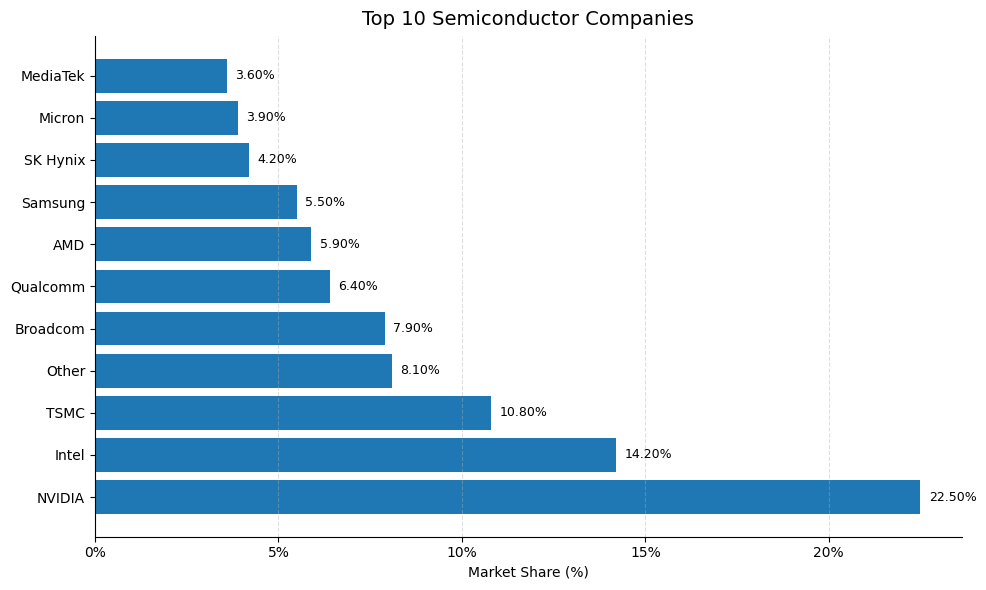

In [ ]:
# top10_semis_bar.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# ---------- I/O ----------
def _read_any(data):
    if isinstance(data, pd.DataFrame):
        return data.copy()
    path = str(data).lower()
    if path.endswith((".csv", ".tsv")):
        return pd.read_csv(data, sep="," if path.endswith(".csv") else "\t")
    if path.endswith((".xlsx", ".xls")):
        return pd.read_excel(data)
    if path.endswith(".json"):
        return pd.read_json(data)
    raise ValueError("Provide a DataFrame or file path (.csv/.tsv/.xlsx/.xls/.json).")

# ---------- prepare Top10 + Other ----------
def prepare_top10_other(data, company_col="company", share_col="share", top_n=10):
    """
    Returns a DataFrame with 11 rows: Top-N companies + 'Other'.
    - share can be in [0..1] or [0..100]. Converts to %.
    - If there are <= top_n rows, 'Other' = max(0, 100 - sum(top_n)).
    - If there are > top_n rows, 'Other' = sum of the remaining rows.
    """
    df = _read_any(data).rename(columns={company_col: "company", share_col: "share"})
    df["share"] = pd.to_numeric(df["share"], errors="coerce").fillna(0).abs()

    # Convert fraction to percent if needed
    if df["share"].max() <= 1.0:
        df["share"] *= 100.0

    # Sort and slice
    df = df.sort_values("share", ascending=False)
    top = df.head(top_n)
    if len(df) > top_n:
        other_share = df["share"].iloc[top_n:].sum()
    else:
        other_share = max(0.0, 100.0 - top["share"].sum())

    out = pd.concat(
        [top, pd.DataFrame({"company": ["Other"], "share": [other_share]})],
        ignore_index=True
    )

    # Round for nicer labels (doesn't affect logic)
    out["share"] = out["share"].round(2)
    return out

# ---------- plot ----------
def plot_top10_other_barh(prepped_df,
                          title="Top 10 Semiconductor Companies by Market Share",
                          xlabel="Market Share (%)",
                          colormap="skyblue",
                          save_path=None,
                          show=True):
    """
    Plots a horizontal bar chart for the given 11-row DataFrame (Top10 + Other).
    """
    df = prepped_df.copy().sort_values("share")  # small→large so largest sits at top after invert

    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    ax.barh(df["company"], df["share"])  # default matplotlib style (no custom colors)

    ax.set_title(title, fontsize=14, pad=8)
    ax.set_xlabel(xlabel)

    # X labels as percentages
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:.0f}%"))

    # Value labels at the end of bars
    for i, v in enumerate(df["share"].values):
        ax.text(v + max(df["share"])*0.01, i, f"{v:.2f}%", va="center", fontsize=9)

    # Make largest at top (optional)
    ax.invert_yaxis()

    # Style
    ax.grid(axis="x", linestyle="--", alpha=0.4)
    for s in ("top", "right"):
        ax.spines[s].set_visible(False)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    if show:
        plt.show()
    plt.close(fig)

# ---------- example usage ----------
if __name__ == "__main__":
    # EXAMPLE 1: from CSV
    # CSV must have columns: company, share
    # df = prepare_top10_other("semiconductor_market_shares_2024.csv")
    # plot_top10_other_barh(df, save_path="semis_top10_other.png")

    # EXAMPLE 2: from Python list/dict (placeholder numbers)
    sample = pd.DataFrame({
        "company": [
            "NVIDIA","Intel","TSMC","Broadcom","Qualcomm","AMD","Samsung",
            "SK Hynix","Micron","MediaTek","Apple","Sony","Marvell","ASE","Infineon"
        ],
        "share": [22.5, 14.2, 10.8, 7.9, 6.4, 5.9, 5.5, 4.2, 3.9, 3.6, 2.1, 1.8, 1.6, 1.4, 1.2]  # % or fraction
    })
    top11 = prepare_top10_other(sample, company_col="company", share_col="share", top_n=10)
    plot_top10_other_barh(top11, title="Top 10 Semiconductor Companies")


/tmp/ipython-input-1645940434.py:132: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vals = plot_df[plot_df["segment"] == seg].groupby("company")["x"].sum().reindex(order, fill_value=0.0)
/tmp/ipython-input-1645940434.py:132: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vals = plot_df[plot_df["segment"] == seg].groupby("company")["x"].sum().reindex(order, fill_value=0.0)
/tmp/ipython-input-1645940434.py:132: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future de

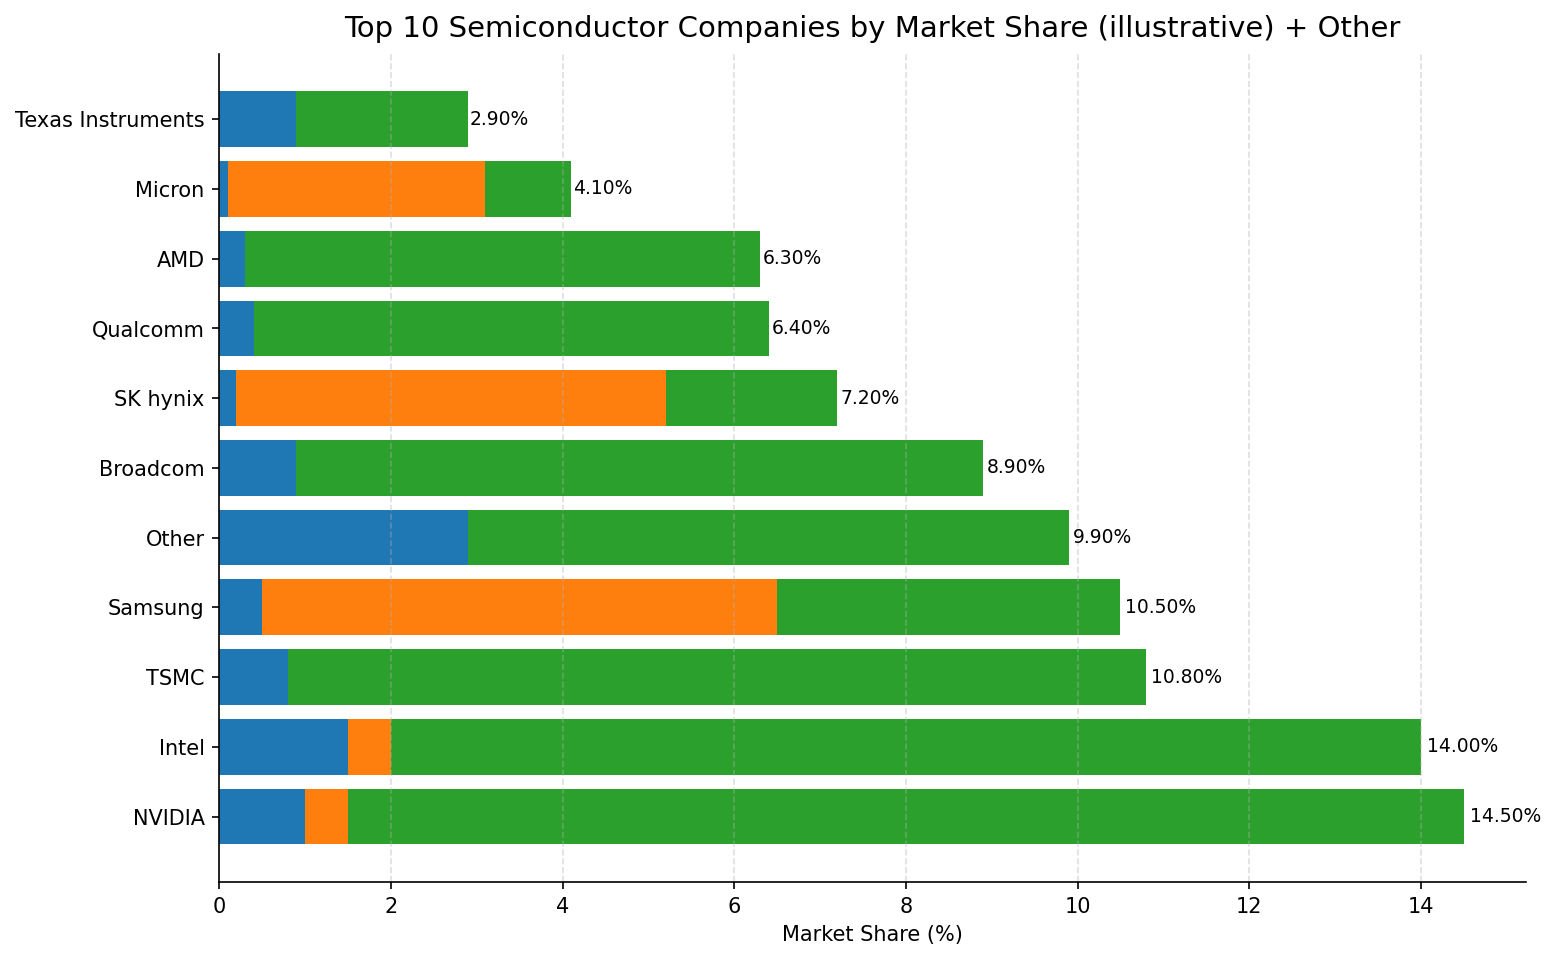

/tmp/ipython-input-1645940434.py:132: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vals = plot_df[plot_df["segment"] == seg].groupby("company")["x"].sum().reindex(order, fill_value=0.0)
/tmp/ipython-input-1645940434.py:132: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vals = plot_df[plot_df["segment"] == seg].groupby("company")["x"].sum().reindex(order, fill_value=0.0)
/tmp/ipython-input-1645940434.py:132: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future de

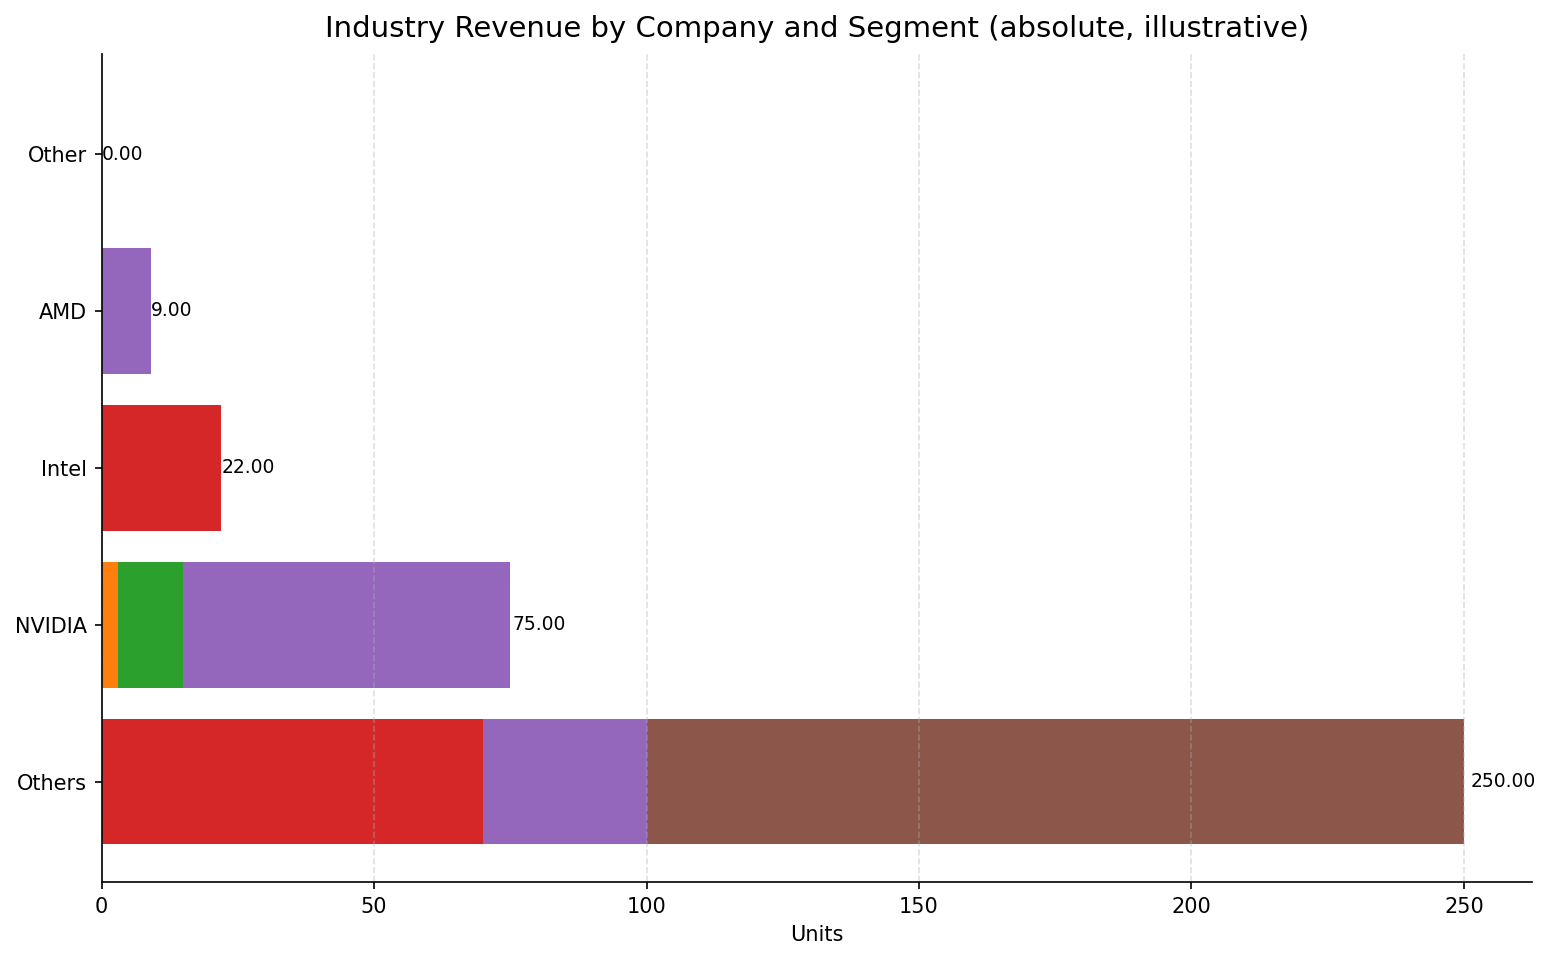

In [ ]:
# stacked_top10_other.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# ---------------- I/O helpers ----------------
def _read_any(data):
    if isinstance(data, pd.DataFrame):
        return data.copy()
    p = str(data).lower()
    if p.endswith((".csv", ".tsv")):
        return pd.read_csv(data, sep="," if p.endswith(".csv") else "\t")
    if p.endswith((".xlsx", ".xls")):
        return pd.read_excel(data)
    if p.endswith(".json"):
        return pd.read_json(data)
    raise ValueError("Pass a DataFrame or a file path (.csv/.tsv/.xlsx/.xls/.json).")

def _to_long(df, company_col=None, segment_col=None, value_col=None):
    """
    Accepts:
      LONG:  company_col, segment_col, value_col provided → return as long
      WIDE:  columns = [company, seg1, seg2, ...] → melt to long
    Returns columns: company, segment, value
    """
    if company_col and segment_col and value_col:
        out = df.rename(columns={company_col:"company", segment_col:"segment", value_col:"value"})
    else:
        # first col = company; others are segments in wide format
        company_col = df.columns[0]
        seg_cols = [c for c in df.columns if c != company_col]
        out = df.melt(id_vars=company_col, value_vars=seg_cols,
                      var_name="segment", value_name="value") \
                .rename(columns={company_col:"company"})
    # clean
    out["value"] = pd.to_numeric(out["value"], errors="coerce").fillna(0.0)
    out["company"] = out["company"].astype(str)
    out["segment"] = out["segment"].astype(str)
    return out

# ------------- Prep: TopN + Other -------------
def prep_topn_other_stacked(data,
                            company_col=None, segment_col=None, value_col=None,
                            top_n=10,
                            input_is_share=False,   # True if 'value' already % or fraction
                            share_as_percent=True   # plot in % on x-axis if True
                           ):
    """
    Returns a long dataframe with Top-N companies + one 'Other' row (per segment).
    If input_is_share=False, values are totals; we compute company shares from them.
    """
    df = _read_any(data)
    long_df = _to_long(df, company_col, segment_col, value_col)

    # If values are absolute, compute shares within total market:
    if not input_is_share:
        grand_total = long_df.groupby("company")["value"].sum().sum()
        # guard against 0 total
        if grand_total <= 0:
            raise ValueError("Total is zero; cannot compute shares.")
        long_df["share"] = long_df["value"] / grand_total * 100.0
    else:
        # Convert fractions to %
        if long_df["value"].max() <= 1.0:
            long_df["share"] = long_df["value"] * 100.0
        else:
            long_df["share"] = long_df["value"]

    # Find Top-N by total share
    totals = long_df.groupby("company")["share"].sum().sort_values(ascending=False)
    top_companies = list(totals.head(top_n).index)
    rest = long_df[~long_df["company"].isin(top_companies)]
    top = long_df[long_df["company"].isin(top_companies)].copy()

    # Build aggregated "Other" across remaining companies, per segment
    if len(rest):
        other = rest.groupby("segment", as_index=False)["share"].sum()
        other["company"] = "Other"
        long_out = pd.concat([top, other[["company","segment","share"]]], ignore_index=True)
    else:
        # If <= top_n companies provided, set 'Other' = 100 - sum(top)
        remainder = max(0.0, 100.0 - totals.head(top_n).sum())
        other = pd.DataFrame({"company":["Other"], "segment":["Total"], "share":[remainder]})
        long_out = pd.concat([top, other], ignore_index=True)

    # If we want to plot absolute units on x-axis instead of %, convert back:
    if not share_as_percent and not input_is_share:
        # Use original totals to get absolute "Other" too:
        totals_abs = _to_long(df, company_col, segment_col, value_col) \
                        .groupby("company")["value"].sum().sort_values(ascending=False)
        if len(totals_abs) > top_n:
            other_abs = totals_abs.iloc[top_n:].sum()
        else:
            other_abs = 0.0
        keep_abs = totals_abs.head(top_n).reset_index().rename(columns={"value":"abs_total"})
        long_out = long_out.merge(keep_abs, on="company", how="left")
        long_out.loc[long_out["company"]=="Other", "abs_total"] = other_abs
        # scale segment shares to the absolute totals:
        long_out["value_abs"] = long_out.groupby("company")["share"].transform(lambda s: s / s.sum()) \
                               * long_out["abs_total"]
        long_out["x"] = long_out["value_abs"]
        xlabel = "Units"
    else:
        long_out["x"] = long_out["share"]
        xlabel = "Market Share (%)"

    return long_out, top_companies, xlabel

# ------------- Plot: horizontal stacked bars -------------
def plot_topn_other_stacked_barh(long_df, top_companies, xlabel="Market Share (%)",
                                 title="Top 10 Companies + Other (stacked by segment)",
                                 annotate_totals=True,
                                 save_path=None, show=True):
    """
    Expects a long df with columns: company, segment, x (value to plot).
    """
    # order companies (TopN by total, then Other), and compute totals for labels
    totals = long_df.groupby("company")["x"].sum().sort_values(ascending=True)
    order = list(totals.index)  # ascending -> smallest at bottom; we invert axis later
    plot_df = long_df.copy()
    plot_df["company"] = pd.Categorical(plot_df["company"], categories=order, ordered=True)
    plot_df = plot_df.sort_values(["company", "segment"])

    # pivot to get consistent stacking order of segments (by total)
    seg_order = plot_df.groupby("segment")["x"].sum().sort_values(ascending=True).index.tolist()

    fig, ax = plt.subplots(figsize=(10.5, 6.5), dpi=150)

    bottoms = np.zeros(len(order))
    for seg in seg_order:
        vals = plot_df[plot_df["segment"] == seg].groupby("company")["x"].sum().reindex(order, fill_value=0.0)
        ax.barh(order, vals.values, left=bottoms)  # default colors
        bottoms += vals.values

    ax.set_title(title, fontsize=14, pad=8)
    ax.set_xlabel(xlabel)
    ax.grid(axis="x", linestyle="--", alpha=0.4)
    for s in ("top","right"): ax.spines[s].set_visible(False)

    # put the largest company at the top
    ax.invert_yaxis()

    # annotate totals at the end of each bar
    if annotate_totals:
        for i, (comp, total) in enumerate(totals.items()):
            ax.text(total * 1.005, i, f"{total:,.2f}" + ("" if "%" not in xlabel else "%"),
                    va="center", fontsize=9)

    plt.tight_layout()
    if save_path: plt.savefig(save_path, bbox_inches="tight")
    if show: plt.show()
    plt.close(fig)

# --------------------- Examples ---------------------
if __name__ == "__main__":
    # EXAMPLE 1 — Semiconductor industry (Top10 by revenue share),
    # segments = Logic vs Memory vs Other (illustrative numbers)
    wide = pd.DataFrame({
        "company": ["NVIDIA","Intel","TSMC","Broadcom","Qualcomm","AMD","Samsung","SK hynix","Micron","MediaTek",
                    "Texas Instruments","Infineon","Analog Devices","Marvell","Sony"],
        "Logic":   [13, 12,  10, 8, 6, 6, 4, 2, 1, 2, 2, 1.5, 1.5, 1, 1],
        "Memory":  [0.5, 0.5, 0, 0, 0, 0, 6, 5, 3, 0, 0, 0, 0, 0, 0],
        "Other":   [1, 1.5, 0.8, 0.9, 0.4, 0.3, 0.5, 0.2, 0.1, 0.3, 0.9, 0.7, 0.8, 0.6, 0.5]
    })
    # values are in PERCENT already → input_is_share=True
    long1, top10, xlabel = prep_topn_other_stacked(
        wide, top_n=10, input_is_share=True, share_as_percent=True
    )
    plot_topn_other_stacked_barh(
        long1, top10,
        xlabel=xlabel,
        title="Top 10 Semiconductor Companies by Market Share (illustrative) + Other"
    )

    # EXAMPLE 2 — NVIDIA by product segments vs rest of industry (absolute units)
    # Suppose we have total industry revenue (USD billions) by vendor & segment:
    long_nvda = pd.DataFrame({
        "company": ["NVIDIA","NVIDIA","NVIDIA","AMD","Intel","Others","Others","Others"],
        "segment": ["Data Center","Gaming","Auto","Data Center","Client/PC","All Other","Data Center","Client/PC"],
        "value":   [60, 12, 3, 9, 22, 150, 30, 70]   # absolute values (e.g., $B) — toy numbers
    })
    # Here we want Top10 + Other (but dataset is small; still works) and plot **absolute** totals:
    long2, topN, xlabel2 = prep_topn_other_stacked(
        long_nvda, company_col="company", segment_col="segment", value_col="value",
        top_n=10, input_is_share=False, share_as_percent=False
    )
    plot_topn_other_stacked_barh(
        long2, topN, xlabel=xlabel2,
        title="Industry Revenue by Company and Segment (absolute, illustrative)"
    )
